In [1]:
from skimage import img_as_float64, img_as_uint
from skimage.filters import gaussian
from joblib import Parallel, delayed
import multiprocessing
import bigfish.stack as stack
import bigfish.plot as plot
import bigfish.detection as detection
import bigfish.multistack as multistack
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import re  
from skimage.io import imread
from scipy.ndimage import gaussian_filter
from skimage.morphology import erosion
from scipy import ndimage
from scipy.optimize import curve_fit
import itertools
import glob
import tifffile
import sys
import datetime
import getpass
import pkg_resources
import platform
import math
from cellpose import models
import os; from os import listdir; from os.path import isfile, join
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from skimage.measure import find_contours
from scipy import signal
from scipy import ndimage
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import matplotlib as mpl
mpl.rc('image', cmap='viridis')
plt.style.use('ggplot')  # ggplot  #default
import multiprocessing
from smb.SMBConnection import SMBConnection
import socket
import pathlib
import yaml
import shutil
from fpdf import FPDF
import gc
import pickle
import pycromanager as pycro

import torch
import warnings

warnings.filterwarnings('ignore', category=matplotlib.MatplotlibDeprecationWarning)

# Selecting the GPU. This is used in case multiple scripts run in parallel.
try:
    import torch
    number_gpus = len ( [torch.cuda.device(i) for i in range(torch.cuda.device_count())] )
    if number_gpus >1 : # number_gpus
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] =  str(np.random.randint(0,number_gpus,1)[0])        
except:
    print('No GPUs are detected on this computer. Please follow the instructions for the correct installation.')
import zipfile
import seaborn as sns
import scipy.stats as stats
from  matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
font_props = {'size': 16}
import joypy
from matplotlib import cm
from scipy.ndimage import binary_dilation

# Honestly these are Utility functions

In [2]:
class Utilities():
    '''
    This class contains miscellaneous methods to perform tasks needed in multiple classes. No parameters are necessary for this class.
    '''
    def __init__(self):
        pass
    def remove_images_not_processed(images_metadata, list_images):
        if images_metadata is None:
            return list_images
        else:
            selected_images = []
            max_image_id = images_metadata['Image_id'].max()+1
            for i in range (max_image_id):
                processing_status = images_metadata[images_metadata['Image_id'] == i].Processing.values[0]
                if processing_status == 'successful':
                    selected_images.append(list_images[i])
        return selected_images
    
    def calculate_sharpness(self,list_images, channels_with_FISH, neighborhood_size=31, threshold=1.12):
        list_mean_sharpeness_image = []
        list_is_image_sharp=[]
        list_sharp_images =[]
        for _ , image in enumerate(list_images):
            temp = image[:,:,:,channels_with_FISH[0]].astype(np.uint16)
            focus = stack.compute_focus(temp, neighborhood_size=neighborhood_size)
            mean_sharpeness_image = np.round(np.mean(focus.mean(axis=(1, 2))),3)
            if mean_sharpeness_image > threshold:
                is_image_sharp = True
                list_sharp_images.append(image)
            else:
                is_image_sharp = False
            list_mean_sharpeness_image.append(mean_sharpeness_image)
            list_is_image_sharp.append(is_image_sharp)
        return list_mean_sharpeness_image, list_is_image_sharp,list_sharp_images
    
    def remove_outliers(self, array,min_percentile=1,max_percentile=98):
        max_val = np.percentile(array, max_percentile)
        if np.isnan(max_val) == True:
            max_val = np.percentile(array, max_percentile+0.1)
        min_val = np.percentile(array, min_percentile)
        if np.isnan(min_val) == True:
            min_val = np.percentile(array, min_percentile+0.1)
        array = array [array > min_val]
        array = array [array < max_val]
        return array 
    
    def is_None(self,variable_to_test):
        if (type(variable_to_test) is list):
            variable_to_test = variable_to_test[0]
        if variable_to_test in (None, 'None', 'none',['None'],['none'],[None]):
            is_none = True
        else:
            is_none = False
        return is_none
    
    def make_it_a_list(self,variable_to_test):
        if not (type(variable_to_test) is list):
            list_variable = [variable_to_test]
        else:
            list_variable = variable_to_test
        return list_variable
    
    # Function that reorder the index to make it continuos 
    def reorder_mask_image(self,mask_image_tested):
        number_masks = np.max(mask_image_tested)
        mask_new =np.zeros_like(mask_image_tested)
        if number_masks>0:
            counter = 0
            for index_mask in range(1,number_masks+1):
                if index_mask in mask_image_tested:
                    counter = counter + 1
                    if counter ==1:
                        mask_new = np.where(mask_image_tested == index_mask, -counter, mask_image_tested)
                    else:
                        mask_new = np.where(mask_new == index_mask, -counter, mask_new)
            reordered_mask = np.absolute(mask_new)
        else:
            reordered_mask = mask_new
        return reordered_mask  
    
    # Function that reorder the index to make it continuos 
    def remove_artifacts_from_mask_image(self,mask_image_tested, minimal_mask_area_size = 2000):
        number_masks = np.max(mask_image_tested)
        if number_masks>0:
            for index_mask in range(1,number_masks+1):
                mask_size = np.sum(mask_image_tested == index_mask)
                if mask_size <= minimal_mask_area_size:
                    #mask_image_tested = np.where(mask_image_tested == index_mask, mask_image_tested, 0)
                    mask_image_tested = np.where(mask_image_tested == index_mask,0,mask_image_tested )
            reordered_mask = Utilities().reorder_mask_image(mask_image_tested)
        else:
            reordered_mask=mask_image_tested
        return reordered_mask  
    
    def convert_to_standard_format(self,data_folder_path,path_to_config_file, number_color_channels=2,number_of_fov=1, download_data_from_NAS = True, use_metadata=False, is_format_FOV_Z_Y_X_C=True):
        path_to_masks_dir = None
        # Creating a folder to store all plots
        destination_folder = pathlib.Path().absolute().joinpath('temp_'+data_folder_path.name+'_sf')
        if pathlib.Path.exists(destination_folder):
            shutil.rmtree(str(destination_folder))
            destination_folder.mkdir(parents=True, exist_ok=True)
        else:
            destination_folder.mkdir(parents=True, exist_ok=True)
        
        local_data_dir, _, _, _, list_files_names_all_fov, list_images_all_fov = Utilities().read_images_from_folder(path_to_config_file, data_folder_path, path_to_masks_dir,  download_data_from_NAS)
        if download_data_from_NAS == False:
            local_data_dir = data_folder_path
        # Downloading data
        if use_metadata == True:
            try:
                metadata = pycro.Dataset(str(local_data_dir))
                number_z_slices = max(metadata.axes['z'])+1
                number_color_channels = max(metadata.axes['channel'])+1
                number_of_fov = max(metadata.axes['position'])+1
                number_of_tp = max(metadata.axes['time'])+1
                detected_metadata = True
                print('Number of z slices: ', str(number_z_slices), '\n',
                    'Number of color channels: ', str(number_color_channels) , '\n'
                    'Number of FOV: ', str(number_of_fov) , '\n',
                    'Number of TimePoints', str(number_of_tp), '\n', '\n', '\n')
            except:
                raise ValueError('The metadata file is not found. Please check the path to the metadata file.')
        
        if is_format_FOV_Z_Y_X_C == True:
            #_, _, _, _, list_files_names_all_fov, list_images_all_fov = Utilities().read_images_from_folder(path_to_config_file, data_folder_path, path_to_masks_dir,  download_data_from_NAS)
            number_images_all_fov = len(list_files_names_all_fov)
            # Re-arranging the image from shape [FOV, Z, Y, X, C] to multiple tifs with shape [Z, Y, X, C]  FOV_Z_Y_X_C
            list_images_standard_format= []
            list_files_names = []
            number_images =0
            for i in range(number_images_all_fov):
                for j in range (number_of_fov):
                    temp_image_fov = list_images_all_fov[i]
                    if use_metadata == False:
                        number_z_slices = temp_image_fov.shape[0]//2
                        if number_z_slices > 50:
                            raise ValueError('The number of automatically detected z slices is '+str(number_z_slices)+', double-check the number_of_fov and number_color_channels.' )
                    y_shape, x_shape = temp_image_fov.shape[2], temp_image_fov.shape[3]
                    list_files_names.append(  list_files_names_all_fov[i].split(".")[0]+'_fov_'+str(j) +'.tif' )
                    temp_image = np.zeros((number_z_slices,y_shape, x_shape,number_color_channels))
                    
                    temp_image = temp_image_fov[j,:,:,:] # format [Z,Y,X,C]
                    #for ch in range(number_color_channels):
                    #    temp_image[:,:,:,ch] = temp_image_fov[ch::number_color_channels,:,:] 
                    list_images_standard_format.append(temp_image)
                    number_images+=1
            
            for k in range(number_images):
                # image_name = list_files_names[i].split(".")[0] +'.tif'
                tifffile.imsave(str(destination_folder.joinpath(list_files_names[k])), list_images_standard_format[k])
            
            masks_dir = None
        else:
            if number_of_fov > 1:  
                # This option sections a single tif file containing multiple fov.
                # The format of the original FOV is [FOV_0:Ch_0-Ch_1-Z_1...Z_N, ... FOV_N:Ch_0-Ch_1-Z_1...Z_N]
                #local_data_dir, _, _, _, list_files_names_all_fov, list_images_all_fov = Utilities().read_images_from_folder(path_to_config_file, data_folder_path, path_to_masks_dir,  download_data_from_NAS)
                #if download_data_from_NAS == False:
                #    local_data_dir = data_folder_path
                number_images_all_fov = len(list_files_names_all_fov)
                number_images = 0
                # This option sections a single tif file containing multiple fov.
                # The format of the original FOV is [FOV_0:Ch_0-Ch_1-Z_1...Z_N, ... FOV_N:Ch_0-Ch_1-Z_1...Z_N]  
                for k in range(number_images_all_fov):
                    # Section that separaters all fov into single tif files
                    image_with_all_fov = list_images_all_fov[k]
                    number_total_images_in_fov = image_with_all_fov.shape[0]
                    if detected_metadata == False:
                        if (number_total_images_in_fov % (number_color_channels*number_of_fov)) == 0:
                            number_z_slices = int(number_total_images_in_fov / (number_color_channels*number_of_fov))
                        else:
                            raise ValueError('The number of z slices is not defined correctly double-check the number_of_fov and number_color_channels.' )
                        if number_z_slices > 50:
                            raise ValueError('The number of automatically detected z slices is '+str(number_z_slices)+', double-check the number_of_fov and number_color_channels.' )
                    number_elements_on_fov = number_color_channels*number_z_slices
                    list_files_names = []
                    y_shape, x_shape = image_with_all_fov.shape[1], image_with_all_fov.shape[2]                
                    # Iterating for each image. Note that the color channels are intercalated in the original image. For that reason a for loop is needed and then selecting even and odd indexes.
                    list_images_standard_format= []
                    counter=0
                    for i in range(number_of_fov):
                        list_files_names.append(  list_files_names_all_fov[k].split(".")[0]+'_img_'+str(k)+'_fov_'+str(i) +'.tif' )
                        temp_image_fov = np.zeros((number_elements_on_fov,y_shape, x_shape))
                        temp_image_fov = image_with_all_fov[counter*number_elements_on_fov:number_elements_on_fov*(counter+1),:,:]
                        temp_image = np.zeros((number_z_slices,y_shape, x_shape,number_color_channels))
                        for ch in range(number_color_channels):
                            temp_image[:,:,:,ch] = temp_image_fov[ch::number_color_channels,:,:] 
                        #temp_image[:,:,:,0] = temp_image_fov[::2,:,:] # even indexes
                        #temp_image[:,:,:,1] = temp_image_fov[1::2,:,:] # odd indexes
                        list_images_standard_format.append(temp_image)
                        counter+=1
                        number_images+=1
                        del temp_image, temp_image_fov
            elif number_of_fov == 1:
                # This option takes multiple tif files containing multiple images with format [FOV_0:Ch_0-Ch_1-Z_1...Z_N, ... FOV_N:Ch_0-Ch_1-Z_1...Z_N]
                #_, _, _, _, list_files_names_all_fov, list_images_all_fov = Utilities().read_images_from_folder(path_to_config_file, data_folder_path, path_to_masks_dir,  download_data_from_NAS)
                number_images = len(list_files_names_all_fov)
                # Re-arranging the image
                list_images_standard_format= []
                list_files_names = []
                for i in range(number_images):
                    temp_image_fov = list_images_all_fov[i]
                    number_z_slices = temp_image_fov.shape[0]//2
                    if number_z_slices > 50:
                        raise ValueError('The number of automatically detected z slices is '+str(number_z_slices)+', double-check the number_of_fov and number_color_channels.' )
                    y_shape, x_shape = temp_image_fov.shape[1], temp_image_fov.shape[2]
                    list_files_names.append(  list_files_names_all_fov[i].split(".")[0]+'_fov_'+str(i) +'.tif' )
                    temp_image = np.zeros((number_z_slices,y_shape, x_shape,number_color_channels))
                    for ch in range(number_color_channels):
                        temp_image[:,:,:,ch] = temp_image_fov[ch::number_color_channels,:,:] 
                    #temp_image[:,:,:,0] = list_images_all_fov[i][::2,:,:] # even indexes
                    #temp_image[:,:,:,1] = list_images_all_fov[i][1::2,:,:] # odd indexes
                    list_images_standard_format.append(temp_image)
            
        
        # Saving images as tif files
        for i in range(number_images):
            # image_name = list_files_names[i].split(".")[0] +'.tif'
            tifffile.imsave(str(destination_folder.joinpath(list_files_names[i])), list_images_standard_format[i])
        masks_dir = None
        return destination_folder,masks_dir, list_files_names, list_images_all_fov, list_images_standard_format, number_of_fov, number_color_channels, number_z_slices, number_of_tp
    
    def create_output_folders(self,data_folder_path,diameter_nucleus,diameter_cytosol,psf_z,psf_yx,threshold_for_spot_detection,channels_with_FISH,list_threshold_for_spot_detection):
        # testing if the images were merged.
        if data_folder_path.name == 'merged':
            data_folder_path = data_folder_path.parents[0]
        # Testing if a temporal folder was created.
        if data_folder_path.name[0:5] == 'temp_':
            original_folder_name = data_folder_path.name[5:]
        else:
            original_folder_name= data_folder_path.name
        # Creating the output_identification_string
        if (threshold_for_spot_detection is None):
            output_identification_string = original_folder_name+'___nuc_' + str(diameter_nucleus) +'__cyto_' + str(diameter_cytosol) +'__psfz_' + str(psf_z) +'__psfyx_' + str(psf_yx)+'__ts_auto'
        else:
            output_identification_string = original_folder_name +'___nuc_' + str(diameter_nucleus) +'__cyto_' + str(diameter_cytosol) +'__psfz_' + str(psf_z) +'__psfyx_' + str(psf_yx)+'__ts'
            for i in range (len(channels_with_FISH)):
                output_identification_string+='_'+ str(list_threshold_for_spot_detection[i])
                print ('\n Output folder name : ' , output_identification_string)
        # Output folders
        analysis_folder_name = 'analysis_'+ output_identification_string
        # Removing directory if exist
        if os.path.exists(analysis_folder_name):
            shutil.rmtree(analysis_folder_name)
        # Creating the directory
        os.makedirs(analysis_folder_name) 
        return output_identification_string
    
    
    def  create_list_thresholds_FISH(self,channels_with_FISH,threshold_for_spot_detection=None):
        # If more than one channel contain FISH spots. This section will create a list of thresholds for spot detection and for each channel. 
        if not(isinstance(channels_with_FISH, list)):
            channels_with_FISH=Utilities().make_it_a_list(channels_with_FISH)
        list_threshold_for_spot_detection=[]
        if not isinstance(threshold_for_spot_detection, list):
            for i in range (len(channels_with_FISH)):
                list_threshold_for_spot_detection.append(threshold_for_spot_detection)
        else:
            list_threshold_for_spot_detection = threshold_for_spot_detection
        # Lists for thresholds. If the list is smaller than the number of FISH channels and it uses the same value for all channels.
        if (isinstance(list_threshold_for_spot_detection, list)) and (len(list_threshold_for_spot_detection) < len(channels_with_FISH)):
            for i in range (len(channels_with_FISH)):
                list_threshold_for_spot_detection.append(list_threshold_for_spot_detection[0])
        return list_threshold_for_spot_detection
    
    # This function is intended to merge masks in a single image
    def merge_masks (self,list_masks):
        '''
        This method is intended to merge a list of images into a single image (Numpy array) where each cell is represented by an integer value.
        
        Parameters
        
        list_masks : List of Numpy arrays.
            List of Numpy arrays, where each array has dimensions [Y, X] with values 0 and 1, where 0 represents the background and 1 the cell mask in the image.
        '''
        n_masks = len(list_masks)
        if not ( n_masks is None):
            if n_masks > 1: # detecting if more than 1 mask are detected per cell
                base_image = np.zeros_like(list_masks[0])
                for nm in range (1, n_masks+1): # iterating for each mask in a given cell. The mask has values from 0 for background, to int n, where n is the number of detected masks.
                    tested_mask = np.where(list_masks[nm-1] == 1, nm, 0)
                    base_image = base_image + tested_mask
            # making zeros all elements outside each mask, and once all elements inside of each mask.
            else:  # do nothing if only a single mask is detected per image.
                base_image = list_masks[0]
        else:
            base_image =[]
        masks = base_image.astype(np.uint8)
        return masks
    
    def separate_masks (self,masks):
        '''
        This method is intended to separate an image (Numpy array) with multiple masks into a list of Numpy arrays where each cell is represented individually in a new NumPy array.
        
        Parameters
        
        masks : Numpy array.
            Numpy array with dimensions [Y, X] with values from 0 to n where n is the number of masks in the image.
        '''
        list_masks = []
        n_masks = np.max(masks)
        if not ( n_masks is None):
            if n_masks > 1: # detecting if more than 1 mask are detected per cell
                for nm in range (1, n_masks+1): # iterating for each mask in a given cell. The mask has values from 0 for background, to int n, where n is the number of detected masks.
                    mask_copy = masks.copy()
                    tested_mask = np.where(mask_copy == nm, 1, 0) # making zeros all elements outside each mask, and once all elements inside of each mask.
                    list_masks.append(tested_mask)
            else:  # do nothing if only a single mask is detected per image.
                list_masks.append(masks)
        else:
            list_masks.append(masks)
        return list_masks
    
    def convert_to_int8(self,image,rescale=True,min_percentile=1, max_percentile=98):
        '''
        This method converts images from int16 to uint8. Optionally, the image can be rescaled and stretched.
        
        Parameters
        
        image : NumPy array
            NumPy array with dimensions [Y, X, C]. The code expects 3 channels (RGB). If less than 3 values are passed, the array is padded with zeros.
        rescale : bool, optional
            If True it rescales the image to stretch intensity values to a 95 percentile, and then rescale the min and max intensity to 0 and 255. The default is True. 
        '''
        
        if rescale == True:
            im_zeros = np.zeros_like(image)
            for ch in range( image.shape[2]):
                if np.max(image[:,:,ch]) >0:
                    im_zeros[:,:,ch] = RemoveExtrema(image[:,:,ch],min_percentile=min_percentile, max_percentile=max_percentile).remove_outliers() 
            image = im_zeros
        image_new= np.zeros_like(image)
        for i in range(0, image.shape[2]):  # iterate for each channel
            if np.max(image[:,:,i]) >0:
                temp = image[:,:,i].copy()
                image_new[:,:,i]= ( (temp-np.min(temp))/(np.max(temp)-np.min(temp)) ) * 255
            image_new = np.uint8(image_new)
        # padding with zeros the channel dimension.
        while image_new.shape[2]<3:
            zeros_plane = np.zeros_like(image_new[:,:,0])
            image_new = np.concatenate((image_new,zeros_plane[:,:,np.newaxis]),axis=2)
        return image_new

    def read_zipfiles_from_NAS(self,list_dirs,path_to_config_file,share_name,mandatory_substring,local_folder_path):
        # This function iterates over all zip files in a remote directory and download them to a local directory
        list_remote_files=[]
        list_local_files =[]
        if (isinstance(list_dirs, tuple)==False) and (isinstance(list_dirs, list)==False):
            list_dirs = [list_dirs]
        for folder in list_dirs:
            print(folder)
            list_files = NASConnection(path_to_config_file,share_name = share_name).read_files(folder,timeout=60)
            for file in list_files:
                if ('.zip' in file) and (mandatory_substring in file):   # add an argument with re conditions 
                    # Listing all zip files
                    zip_file_path = pathlib.Path().joinpath(folder,file)
                    list_remote_files.append (zip_file_path)
                    list_local_files.append(pathlib.Path().joinpath(local_folder_path,zip_file_path.name)) 
                    # downloading the zip files from NAS
                    NASConnection(path_to_config_file,share_name = share_name).download_file(zip_file_path, local_folder_path,timeout=200)
        return list_local_files
    
    def unzip_local_folders(self,list_local_files,local_folder_path):
        list_local_folders =[]
        for zip_folder in list_local_files:
            # Reads from a list of zip files
            file_to_unzip = zipfile.ZipFile(str(zip_folder)) # opens zip
            temp_folder_name = pathlib.Path().joinpath(local_folder_path, zip_folder.stem)
            if (os.path.exists(temp_folder_name)) :
                shutil.rmtree(temp_folder_name)
                os.makedirs(temp_folder_name) # make a new directory
            # Iterates for each file in zip file
            for file_in_zip in file_to_unzip.namelist():
                # Extracts data to specific folder
                file_to_unzip.extract(file_in_zip,temp_folder_name)
            # Closes the zip file
            file_to_unzip.close()
            # removes the original zip file
            os.remove(pathlib.Path().joinpath(local_folder_path, zip_folder.name))
            list_local_folders.append(temp_folder_name)
        return list_local_folders
    
    def dataframe_extract_data(self,dataframe,spot_type, minimum_spots_cluster=2):
        ''' This function is intended to read a dataframe and returns 
            number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, number_of_TS_per_cell, ts_size, cell_size
        '''
        # Number of cells
        number_cells = dataframe['cell_id'].nunique()
        # Number of spots in cytosol
        number_of_spots_per_cell_cytosol = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i) & (dataframe['is_nuc']==False) & (dataframe['spot_type']==spot_type)  & (dataframe['is_cell_fragmented']!=-1) ].spot_id) for i in range(0, number_cells)])
        # Number of spots in nucleus.  Spots without TS.
        number_of_spots_per_cell_nucleus = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i) & (dataframe['is_nuc']==True) & (dataframe['spot_type']==spot_type)  & (dataframe['is_cell_fragmented']!=-1)    ].spot_id) for i in range(0, number_cells)])
        # Number of spots
        number_of_spots_per_cell = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i)  & (dataframe['spot_type']==spot_type) & (dataframe['is_cell_fragmented']!=-1)].spot_id) for i in range(0, number_cells)])
        # Number of TS per cell.
        number_of_TS_per_cell = [len( dataframe.loc[  (dataframe['cell_id']==i) &  (dataframe['is_cluster']==True) & (dataframe['is_nuc']==True) & (dataframe['spot_type']==spot_type)  &   (dataframe['cluster_size']>=minimum_spots_cluster)  & (dataframe['is_cell_fragmented']!=-1)  ].spot_id) for i in range(0, number_cells)]
        number_of_TS_per_cell= np.asarray(number_of_TS_per_cell)
        # Number of RNA in a TS
        ts_size =  dataframe.loc[ (dataframe['is_cluster']==True) & (dataframe['is_nuc']==True)  & (dataframe['spot_type']==spot_type) &   (dataframe['cluster_size']>=minimum_spots_cluster)  & (dataframe['is_cell_fragmented']!=-1)   ].cluster_size.values
        # Size of each cell
        cell_size = [dataframe.loc[   (dataframe['cell_id']==i) ].cell_area_px.values[0] for i in range(0, number_cells)]
        cell_size = np.asarray(cell_size)
        # Cyto size
        cyto_size = [dataframe.loc[   (dataframe['cell_id']==i) ].cyto_area_px.values[0] for i in range(0, number_cells)]
        cyto_size = np.asarray(cyto_size)
        # Size of the nucleus of each cell
        nuc_size = [dataframe.loc[   (dataframe['cell_id']==i) ].nuc_area_px.values[0] for i in range(0, number_cells)]
        nuc_size = np.asarray(nuc_size)
        # removing values less than zeros
        number_of_spots_per_cell.clip(0)
        number_of_spots_per_cell_cytosol.clip(0)
        number_of_spots_per_cell_nucleus.clip(0)
        number_of_TS_per_cell.clip(0)
        ts_size.clip(0)
        return number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, number_of_TS_per_cell, ts_size,cell_size, number_cells, nuc_size, cyto_size
    
    def extracting_data_for_each_df_in_directory(self,list_local_folders, current_dir,spot_type=0, minimum_spots_cluster=2):
        '''
        This method is intended to extract data from the dataframe
        '''
        # Extracting data from dataframe and converting it into lists for each directory.
        list_spots_total=[]
        list_spots_nuc=[]
        list_spots_cytosol=[]
        list_number_cells =[]
        list_transcription_sites =[]
        list_cell_size=[]
        list_nuc_size =[]
        list_dataframes =[]
        list_cyto_size =[]
        for i in range (0, len (list_local_folders)):
            dataframe_dir = current_dir.joinpath('analyses',list_local_folders[i])    # loading files from "analyses" folder
            dataframe_file = glob.glob( str(dataframe_dir.joinpath('dataframe_*')) )[0]
            dataframe = pd.read_csv(dataframe_file)
            # Extracting values from dataframe
            number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, number_of_TS_per_cell, ts_size, cell_size, number_cells, nuc_size, cyto_size = Utilities().dataframe_extract_data(dataframe,spot_type,minimum_spots_cluster=minimum_spots_cluster)            
            # Appending each condition to a list
            list_spots_total.append(number_of_spots_per_cell)  # This list includes spots and TS in the nucleus
            list_spots_nuc.append(number_of_spots_per_cell_nucleus)   #
            list_spots_cytosol.append(number_of_spots_per_cell_cytosol)
            list_number_cells.append(number_cells)
            list_transcription_sites.append(number_of_TS_per_cell)
            list_cell_size.append(cell_size)
            list_nuc_size.append(nuc_size)
            list_dataframes.append(dataframe)
            list_cyto_size.append(cyto_size)
            # Deleting variables
            del number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, number_of_TS_per_cell, ts_size, cell_size, number_cells,nuc_size
        return list_spots_total, list_spots_nuc, list_spots_cytosol, list_number_cells, list_transcription_sites,list_cell_size,list_dataframes,list_nuc_size,list_cyto_size
    
    def extract_data_interpretation(self,list_dirs, path_to_config_file, current_dir, mandatory_substring, local_folder_path, list_labels, share_name='share',minimum_spots_cluster=2, connect_to_NAS=0, spot_type=0, remove_extreme_values=False):
        if connect_to_NAS == True:
            # Reading the data from NAS, unziping files, organizing data as single dataframe for comparison. 
            list_local_files = Utilities().read_zipfiles_from_NAS(list_dirs,path_to_config_file,share_name, mandatory_substring, local_folder_path)
            list_local_folders = Utilities().unzip_local_folders(list_local_files,local_folder_path)
        else: 
            list_local_folders = list_dirs # Use this line to process files from a local repository
        # Extracting data from each repository
        list_spots_total, list_spots_nuc, list_spots_cytosol, list_number_cells, list_transcription_sites, list_cell_size, list_dataframes, list_nuc_size, list_cyto_size = Utilities().extracting_data_for_each_df_in_directory(  list_local_folders=list_local_folders,current_dir=current_dir,spot_type=spot_type,minimum_spots_cluster=minimum_spots_cluster)
        # Final dataframes for nuc, cyto and total spots
        df_all = Utilities().convert_list_to_df (list_number_cells, list_spots_total, list_labels, remove_extreme_values= remove_extreme_values)
        df_cyto = Utilities().convert_list_to_df (list_number_cells, list_spots_cytosol, list_labels, remove_extreme_values= remove_extreme_values)
        df_nuc = Utilities().convert_list_to_df (list_number_cells, list_spots_nuc, list_labels, remove_extreme_values= remove_extreme_values)
        df_transcription_sites = Utilities().convert_list_to_df (list_number_cells, list_transcription_sites, list_labels, remove_extreme_values= remove_extreme_values)
        return df_all, df_cyto, df_nuc, df_transcription_sites, list_spots_total, list_spots_nuc, list_spots_cytosol, list_number_cells, list_transcription_sites, list_cell_size, list_dataframes, list_nuc_size, list_cyto_size 
    
    def function_get_df_columns_as_array(self,df, colum_to_extract, extraction_type='all_values'):
        '''This method is intended to extract a column from a dataframe and convert its values to an array format.
            The argument <<<extraction_type>>> accepts two possible values. 
                values_per_cell: this returns an unique value that represents a cell parameter and is intended to be used with the following columns 
                        'nuc_int_ch", cyto_int_ch', 'nuc_loc_y', 'nuc_loc_x', 'cyto_loc_y', 'cyto_loc_x', 'nuc_area_px', 'cyto_area_px', 'cell_area_px'
                all_values: this returns all fields in the dataframe for the specified column.  
        '''
        number_cells = df['cell_id'].nunique()
        if extraction_type == 'values_per_cell':
            return np.asarray( [       df.loc[(df['cell_id']==i)][colum_to_extract].values[0]            for i in range(0, number_cells)] )
        elif extraction_type == 'all_values' :
            return np.asarray( [       df.loc[(df['cell_id']==i)][colum_to_extract].values          for i in range(0, number_cells)] )      
    
    def convert_list_to_df (self,list_number_cells, list_spots, list_labels, remove_extreme_values= False,max_quantile=0.98) :
        # defining the dimensions for the array.
        max_number_cells = max(list_number_cells)
        number_conditions = len(list_number_cells)
        # creating an array with the same dimensions
        spots_array = np.empty((max_number_cells, number_conditions))
        spots_array[:] = np.NaN
        # replace the elements in the array
        for i in range(0, number_conditions ):
            spots_array[0:list_number_cells[i], i] = list_spots[i] 
        # creating a dataframe
        df = pd.DataFrame(data = spots_array, columns=list_labels)
        # Removing 1% extreme values.
        if remove_extreme_values == True:
            for col in df.columns:
                max_data_value = df[col].quantile(max_quantile)
                df[col] = np.where(df[col] >= max_data_value, np.nan, df[col])
        return df

    def download_data_NAS(self,path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200):
        '''
        This method is inteded to download data from a NAS. to a local directory.
        path_to_config_file
        data_folder_path
        path_to_masks_dir
        share_name,timeout
        '''
        # Downloading data from NAS
        local_folder_path = pathlib.Path().absolute().joinpath('temp_' + data_folder_path.name)
        NASConnection(path_to_config_file,share_name = share_name).copy_files(data_folder_path, local_folder_path,timeout=timeout)
        local_data_dir = local_folder_path     # path to a folder with images.
        # Downloading masks from NAS
        if not (path_to_masks_dir is None):
            local_folder_path_masks = pathlib.Path().absolute().joinpath( path_to_masks_dir.stem  )
            zip_file_path = local_folder_path_masks.joinpath( path_to_masks_dir.stem +'.zip')
            NASConnection(path_to_config_file,share_name = share_name).download_file(path_to_masks_dir, local_folder_path_masks,timeout=timeout)
            # Unzip downloaded images and update mask directory
            file_to_unzip = zipfile.ZipFile(str(zip_file_path)) # opens zip
            # Iterates for each file in zip file
            for file_in_zip in file_to_unzip.namelist():
                # Extracts data to specific folder
                file_to_unzip.extract(file_in_zip,local_folder_path_masks)
            # Closes the zip file
            file_to_unzip.close()
            # removes the original zip file
            os.remove(zip_file_path)
            masks_dir = local_folder_path_masks
        else:
            masks_dir = None
        return local_data_dir, masks_dir
    
    def read_images_from_folder(self, path_to_config_file, data_folder_path, path_to_masks_dir=None, download_data_from_NAS=False, substring_to_detect_in_file_name = '.*_C0.tif'):
        # Download data from NAS
        if download_data_from_NAS == True:
            share_name = 'share'
            local_data_dir, masks_dir = Utilities().download_data_NAS(path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200)
        else:
            local_data_dir = data_folder_path 
            masks_dir = path_to_masks_dir 
        # Detecting if images need to be merged
        is_needed_to_merge_images = MergeChannels(local_data_dir, substring_to_detect_in_file_name = substring_to_detect_in_file_name, save_figure =1).checking_images()
        if is_needed_to_merge_images == True:
            _, _, number_images, _ = MergeChannels(local_data_dir, substring_to_detect_in_file_name = substring_to_detect_in_file_name, save_figure =1).merge()
            local_data_dir = local_data_dir.joinpath('merged')
            list_images, path_files, list_files_names, number_images = ReadImages(directory= local_data_dir).read()
        else:
            list_images, path_files, list_files_names, number_images = ReadImages(directory= local_data_dir).read()  # list_images, path_files, list_files_names, number_files        
        # Printing image properties
        if len(list_images[0].shape) < 4:
            number_color_channels = None
        else:
            number_color_channels = list_images[0].shape[-1] 
        print('Image shape: ', list_images[0].shape , '\n')
        print('Number of images: ',number_images , '\n')
        print('Local directory with images: ', local_data_dir, '\n')
        return local_data_dir, masks_dir, number_images, number_color_channels, list_files_names,list_images
        
    def save_output_to_folder (self, output_identification_string, data_folder_path,
                                list_files_distributions=None,
                                file_plots_bleed_thru = None,
                                file_plots_int_ratio=None,
                                file_plots_int_pseudo_ratio=None,
                                channels_with_FISH=None,
                                save_pdf_report=True):
        #  Moving figures to the final folder 
        if not (list_files_distributions is None) and (type(list_files_distributions) is list):
            file_plots_distributions = list_files_distributions[0]
            file_plots_cell_size_vs_num_spots = list_files_distributions[1]
            file_plots_cell_intensity_vs_num_spots = list_files_distributions[2]
            file_plots_spot_intensity_distributions = list_files_distributions[3]
            for i in range (len(file_plots_distributions)):
                if not (file_plots_distributions is None):
                    pathlib.Path().absolute().joinpath(file_plots_distributions[i]).rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string),file_plots_distributions[i]))
                if not (file_plots_cell_size_vs_num_spots is None):
                    pathlib.Path().absolute().joinpath(file_plots_cell_size_vs_num_spots[i]).rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string),file_plots_cell_size_vs_num_spots[i]))
                if not (file_plots_cell_intensity_vs_num_spots is None):
                    pathlib.Path().absolute().joinpath(file_plots_cell_intensity_vs_num_spots[i]).rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string),file_plots_cell_intensity_vs_num_spots[i]))
                if not (file_plots_spot_intensity_distributions is None):
                    pathlib.Path().absolute().joinpath(file_plots_spot_intensity_distributions[i]).rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string),file_plots_spot_intensity_distributions[i]))
            
        if not (file_plots_bleed_thru is None):
            pathlib.Path().absolute().joinpath(file_plots_bleed_thru).rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string),file_plots_bleed_thru))
        if not (file_plots_int_ratio is None):
            pathlib.Path().absolute().joinpath(file_plots_int_ratio).rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string),file_plots_int_ratio))
        if not (file_plots_int_pseudo_ratio is None):
            pathlib.Path().absolute().joinpath(file_plots_int_pseudo_ratio).rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string),file_plots_int_pseudo_ratio))
        
        # all original images
        pathlib.Path().absolute().joinpath('original_images_' + data_folder_path.name +'.pdf').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string    ),'original_images_'+ data_folder_path.name +'.pdf'))
        # all cell images
        for i in range (len(channels_with_FISH)):
            temp_plot_name = 'cells_channel_'+ str(channels_with_FISH[i])+'_'+ data_folder_path.name +'.pdf'
            pathlib.Path().absolute().joinpath(temp_plot_name).rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string    ),temp_plot_name))
        #metadata_path
        pathlib.Path().absolute().joinpath('images_report_'+ data_folder_path.name +'.csv').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string),'images_report_'+ data_folder_path.name +'.csv'))
        pathlib.Path().absolute().joinpath('metadata_'+ data_folder_path.name +'.txt').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string),'metadata_'+ data_folder_path.name +'.txt'))
        #dataframe_path 
        pathlib.Path().absolute().joinpath('dataframe_' + data_folder_path.name +'.csv').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string),'dataframe_'+ data_folder_path.name +'.csv'))
        #pdf_path 
        if save_pdf_report == True:
            pathlib.Path().absolute().joinpath('pdf_report_' + data_folder_path.name +'.pdf').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string    ),'pdf_report_'+ data_folder_path.name +'.pdf'))
        #pdf_path segmentation 
        pathlib.Path().absolute().joinpath('segmentation_images_' + data_folder_path.name +'.pdf').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ output_identification_string    ),'segmentation_images_'+ data_folder_path.name +'.pdf'))

        return None

    def sending_data_to_NAS(self,output_identification_string, data_folder_path, path_to_config_file, path_to_masks_dir, diameter_nucleus, diameter_cytosol, send_data_to_NAS = False, masks_dir = None, share_name = 'share'):
        # Writing analyses data to NAS
        analysis_folder_name = 'analysis_'+ output_identification_string
        if send_data_to_NAS == True:
            shutil.make_archive(analysis_folder_name,'zip',pathlib.Path().absolute().joinpath(analysis_folder_name))
            local_file_to_send_to_NAS = pathlib.Path().absolute().joinpath(analysis_folder_name+'.zip')
            NASConnection(path_to_config_file,share_name = share_name).write_files_to_NAS(local_file_to_send_to_NAS, data_folder_path)
            os.remove(pathlib.Path().absolute().joinpath(analysis_folder_name+'.zip'))
        # Writing masks to NAS
        ## Creating mask directory name
        if path_to_masks_dir == None: 
            mask_folder_created_by_pipeline = 'masks_'+ data_folder_path.name # default name by pipeline
            name_final_masks = data_folder_path.name +'___nuc_' + str(diameter_nucleus) + '__cyto_' + str(diameter_cytosol) 
            mask_dir_complete_name = 'masks_'+ name_final_masks # final name for masks dir
            shutil.move(mask_folder_created_by_pipeline, mask_dir_complete_name ) # remaing the masks dir
        elif masks_dir is None:
            mask_dir_complete_name = None
        else: 
            mask_dir_complete_name = masks_dir.name
        ## Sending masks to NAS
        if (send_data_to_NAS == True) and (path_to_masks_dir == None) :
            shutil.make_archive( mask_dir_complete_name , 'zip', pathlib.Path().absolute().joinpath(mask_dir_complete_name))
            local_file_to_send_to_NAS = pathlib.Path().absolute().joinpath(mask_dir_complete_name+'.zip')
            NASConnection(path_to_config_file,share_name = share_name).write_files_to_NAS(local_file_to_send_to_NAS, data_folder_path)
            os.remove(pathlib.Path().absolute().joinpath(mask_dir_complete_name+'.zip'))
        return analysis_folder_name, mask_dir_complete_name
    
    def move_results_to_analyses_folder(self, output_identification_string,  data_folder_path,mask_dir_complete_name,path_to_masks_dir, save_filtered_images = False, download_data_from_NAS = False):
        # Moving all results to "analyses" folder
        if not os.path.exists(str('analyses')):
            os.makedirs(str('analyses'))
        # Subfolder name
        analysis_folder_name = 'analysis_'+ output_identification_string
        final_dir_name =pathlib.Path().absolute().joinpath('analyses', analysis_folder_name)
        # Removing directory if exist
        if os.path.exists(str(final_dir_name)):
            shutil.rmtree(str(final_dir_name))
        # Moving results to a subdirectory in 'analyses' folder
        pathlib.Path().absolute().joinpath(analysis_folder_name).rename(final_dir_name )
        # Moving masks to a subdirectory in 'analyses' folder
        if (download_data_from_NAS == True) or (path_to_masks_dir == None):
            final_mask_dir_name = pathlib.Path().absolute().joinpath('analyses', mask_dir_complete_name)
            if os.path.exists(str(final_mask_dir_name)):
                shutil.rmtree(str(final_mask_dir_name))
            pathlib.Path().absolute().joinpath(mask_dir_complete_name).rename(final_mask_dir_name )
        if save_filtered_images == True:
            filtered_folder_name = 'filtered_images_' + data_folder_path.name 
            pathlib.Path().absolute().joinpath(filtered_folder_name).rename(pathlib.Path().absolute().joinpath('analyses',str('analysis_'+ output_identification_string    ),filtered_folder_name))
        # Delete local temporal files
        temp_results_folder_name = pathlib.Path().absolute().joinpath('temp_results_' + data_folder_path.name)
        shutil.rmtree(temp_results_folder_name)
        # Removing local folder
        # Removing directory if exist
        std_format_folder_name = 'temp_'+data_folder_path.name+'_sf'
        std_format_folder_name_dir_name =pathlib.Path().absolute().joinpath(std_format_folder_name)
        if os.path.exists(str(std_format_folder_name_dir_name)):
            shutil.rmtree(str(std_format_folder_name_dir_name))
        
        if (download_data_from_NAS == True):
            # Delete temporal images downloaded from NAS
            shutil.rmtree('temp_'+data_folder_path.name)
        return None
    
    def export_data_to_CSV(self,list_spots_total, list_spots_nuc, list_spots_cytosol, destination_folder, plot_title_suffix=''):
        # Exporting data to CSV. 
        # ColumnA = time, 
        # ColumnB= #RNA in nucleus, 
        # ColumnC = #RNA in cytoplasm, 
        # ColumnD = total RNA.
        num_time_points = len(list_spots_total)
        num_columns = 4 # time, RNA_nuc, RNA_cyto, total
        array_data_spots =  np.empty(shape=(0, num_columns))
        for i in range(0, num_time_points):
            num_cells = len(list_spots_total[i])
            temp_array_data_spots = np.zeros((num_cells,num_columns))
            temp_array_data_spots[:,0] = i
            temp_array_data_spots[:,1] = list_spots_nuc[i] # nuc
            temp_array_data_spots[:,2] = list_spots_cytosol[i] # cyto
            temp_array_data_spots[:,3] = list_spots_total[i] # all spots
            array_data_spots = np.append(array_data_spots, temp_array_data_spots, axis=0)
        array_data_spots.shape
        # final data frame with format for the model
        df_for_model = pd.DataFrame(data=array_data_spots, columns =['time_index', 'RNA_nuc','RNA_cyto','RNA_total'] )
        new_dtypes = {'time_index':int, 'RNA_nuc':int, 'RNA_cyto':int,'RNA_total':int}
        df_for_model = df_for_model.astype(new_dtypes)
        # Save to csv
        df_for_model.to_csv(pathlib.Path().absolute().joinpath(destination_folder,plot_title_suffix+'.csv'))
        return df_for_model
    def extract_images_masks_dataframe( self,data_folder_path, mandatory_substring, path_to_config_file,connect_to_NAS,path_to_masks_dir=None, rescale=False,max_percentile=99.5):
        local_folder_path = pathlib.Path().absolute().joinpath('temp_local__'+data_folder_path.name)
        # This section downloads results including the dataframe
        if connect_to_NAS == True:
            list_local_files = Utilities().read_zipfiles_from_NAS(list_dirs=data_folder_path,path_to_config_file=path_to_config_file,share_name='share', mandatory_substring=mandatory_substring, local_folder_path=local_folder_path)
            list_local_folders = Utilities().unzip_local_folders(list_local_files,local_folder_path)
        else: 
            list_local_folders = data_folder_path # Use this line to process files from a local repository
        # Extracting the dataframe
        dataframe_file_path = glob.glob( str(list_local_folders[0].joinpath('dataframe_*')) )[0]
        dataframe = pd.read_csv(dataframe_file_path)
        # Extracting the dataframe with cell ids
        try:
            dataframe_file_path_metadata = glob.glob( str(list_local_folders[0].joinpath('images_report_*')) )[0]     
            images_metadata = pd.read_csv(dataframe_file_path_metadata)
        except:
            images_metadata = None
        # Extracting Original images
        local_data_dir, masks_dir, number_images, number_color_channels, list_files_names,_ = Utilities().read_images_from_folder( path_to_config_file, data_folder_path = data_folder_path, path_to_masks_dir = path_to_masks_dir,  download_data_from_NAS = connect_to_NAS, substring_to_detect_in_file_name = '.*_C0.tif')        
        # Reading images from folders
        list_images, path_files, list_files_names, _ = ReadImages(directory= local_data_dir).read()
        if not (path_to_masks_dir is None):
            list_masks, path_files_masks, list_files_names_masks, _ = ReadImages(directory= masks_dir).read()
        else:
            list_masks = None
        # Converting the images to int8
        return list_images, list_masks, dataframe, number_images, number_color_channels,list_local_folders,local_data_dir, images_metadata
    
    
    def image_cell_selection(self,cell_id, list_images, dataframe, mask_cell=None, mask_nuc=None, scaling_value_radius_cell=1.1):
        SCALING_RADIUS_NUCLEUS = scaling_value_radius_cell #1.1
        SCALING_RADIUS_CYTOSOL = scaling_value_radius_cell
        # selecting only the dataframe containing the values for the selected field
        df_selected_cell = dataframe.loc[   (dataframe['cell_id']==cell_id)]
        selected_image_id = df_selected_cell.image_id.values[0]
        y_max_image_shape = list_images[selected_image_id].shape[1]-1
        x_max_image_shape = list_images[selected_image_id].shape[2]-1
        # Cell location in image
        scaling_value_radius_cell = scaling_value_radius_cell # use this parameter to increase or decrease the number of radius to plot from the center of the cell.
        nuc_loc_x = df_selected_cell.nuc_loc_x.values[0]
        nuc_loc_y = df_selected_cell.nuc_loc_y.values[0]
        cyto_loc_x = df_selected_cell.cyto_loc_x.values[0]
        cyto_loc_y = df_selected_cell.cyto_loc_y.values[0]
        nuc_radius_px =  int(np.sqrt(df_selected_cell.nuc_area_px.values[0])*SCALING_RADIUS_NUCLEUS)
        cyto_radius_px = int(np.sqrt(df_selected_cell.cyto_area_px.values[0])*SCALING_RADIUS_CYTOSOL)
        # Detecting if a mask for the cytosol was used. If true, the code will plot the complete cell. Else, it will only plot the cell nucleus.
        if cyto_loc_x:
            plot_complete_cell = True
        else:
            plot_complete_cell = False
        if plot_complete_cell == True:
            x_min_value = cyto_loc_x - cyto_radius_px
            x_max_value = cyto_loc_x + cyto_radius_px
            y_min_value = cyto_loc_y - cyto_radius_px
            y_max_value = cyto_loc_y + cyto_radius_px
        else:
            x_min_value = nuc_loc_x - nuc_radius_px
            x_max_value = nuc_loc_x + nuc_radius_px
            y_min_value = nuc_loc_y - nuc_radius_px
            y_max_value = nuc_loc_y + nuc_radius_px
        # making sure that the selection doesnt go outside the limits of the original image
        x_min_value = np.max((0,x_min_value ))
        y_min_value = np.max((0,y_min_value ))
        x_max_value = np.min((x_max_value,x_max_image_shape))
        y_max_value = np.min((y_max_value,y_max_image_shape))
        # coordinates to select in the image 
        subsection_image_with_selected_cell = list_images[selected_image_id][:,y_min_value: y_max_value,x_min_value:x_max_value,:]
        # coordinates to select in the masks image
        if not (mask_cell is None):
            subsection_mask_cell = mask_cell[y_min_value: y_max_value,x_min_value:x_max_value]
            subsection_mask_cell[0, :] = 0; subsection_mask_cell[-1, :] = 0; subsection_mask_cell[:, 0] = 0; subsection_mask_cell[:, -1] = 0
        else:
            subsection_mask_cell = None
        if not (mask_nuc is None):
            subsection_mask_nuc = mask_nuc[y_min_value: y_max_value,x_min_value:x_max_value]
            subsection_mask_nuc[0, :] = 0; subsection_mask_nuc[-1, :] = 0; subsection_mask_nuc[:, 0] = 0; subsection_mask_nuc[:, -1] = 0
        else:
            subsection_mask_nuc = None 
        # spots
        df_spots = df_selected_cell[['spot_id', 'z', 'y', 'x','is_nuc', 'is_cluster','cluster_size','spot_type']]
        df_spots = df_spots.reset_index(drop=True)
        # Removing columns with -1. 
        df_spots = df_spots[df_spots.spot_id >= 0]
        # Re-organizing the origin of the image based on the subsection.
        df_spots_subsection_coordinates = df_spots.copy()
        df_spots_subsection_coordinates['y'] = df_spots_subsection_coordinates['y'] - y_min_value
        df_spots_subsection_coordinates['x'] = df_spots_subsection_coordinates['x'] - x_min_value
        return subsection_image_with_selected_cell, df_spots_subsection_coordinates,subsection_mask_cell, subsection_mask_nuc,selected_image_id
    
    
    def extract_spot_location_from_cell(self,df, spot_type=0, min_ts_size= None,z_slice=None):
        df_spots_all_z = df.loc[ (df['spot_type']==spot_type)  & (df['is_cluster']==0) ] 
        number_spots = len (  df_spots_all_z  )
        
        # Locating spots in the dataframe
        if (z_slice is None):
            df_spots = df.loc[ (df['spot_type']==spot_type)  & (df['is_cluster']==0) ] 
        else:
            df_spots = df.loc[ (df['spot_type']==spot_type)  & (df['is_cluster']==0) & (df['z']==z_slice) ] 
        number_spots_selected_z = len (  df_spots  )
        
        if number_spots_selected_z >0:
            y_spot_locations = df_spots['y'].values
            x_spot_locations = df_spots['x'].values
        else:
            y_spot_locations = None
            x_spot_locations = None
        
        # locating the TS in  the dataframe 
        if not (min_ts_size is None):
            df_TS = df.loc[ (df['spot_type']==spot_type)  & (df['is_cluster']==1) & (df['cluster_size']>=min_ts_size) ] 
        else:
            df_TS = df.loc[ (df['spot_type']==spot_type)  & (df['is_cluster']==1)]
        number_TS = len (  df_TS  )
        # TS location
        if number_TS >0:
            y_TS_locations = df_TS['y'].values
            x_TS_locations = df_TS['x'].values
        else:
            y_TS_locations = None
            x_TS_locations = None
        return y_spot_locations, x_spot_locations, y_TS_locations, x_TS_locations,number_spots, number_TS,number_spots_selected_z
    
    def spot_crops (self,image,df,number_crops_to_show,spot_size=5):
        number_crops_to_show = np.min((number_crops_to_show, len(df)/2))
        def return_crop(image, x, y,spot_size):
            spot_range = np.linspace(-(spot_size - 1) / 2, (spot_size - 1) / 2, spot_size,dtype=int)
            crop_image = image[y+spot_range[0]:y+(spot_range[-1]+1), x+spot_range[0]:x+(spot_range[-1]+1)].copy()
            return crop_image
        list_crops_0 = []
        list_crops_1 = []
        counter =0
        i =0
        while counter <= number_crops_to_show:
            x_co = df['x'].values[i]
            y_co = df['y'].values[i]
            if (x_co> (spot_size - 1) / 2) and (y_co>(spot_size - 1) / 2):
                crop_0 = return_crop(image=image[:,:,0], x=x_co, y=y_co, spot_size=spot_size)
                crop_1 = return_crop(image=image[:,:,1], x=x_co, y=y_co, spot_size=spot_size)
                list_crops_0.append(crop_0) 
                list_crops_1.append(crop_1)
                counter+=1
            i+=1
        return list_crops_0, list_crops_1


In [3]:
class Plots():
    '''
    This class contains miscellaneous methods to generate plots. No parameters are necessary for this class.
    '''
    def __init__(self):
        pass
    
    def plotting_segmentation_images(self,directory,list_files_names,list_segmentation_successful=[None],image_name='temp.pdf',show_plots=True):
        number_images = len(list_files_names)
        NUM_COLUMNS = 1
        NUM_ROWS = number_images
        # Plotting
        _, axes = plt.subplots(nrows = NUM_ROWS, ncols = NUM_COLUMNS, figsize = (15, NUM_ROWS*3))
        # Prealocating plots
        for i in range (0, NUM_ROWS):
            if NUM_ROWS == 1:
                axis_index = axes
            else:
                axis_index = axes[i]
            axis_index.grid(False)
            axis_index.set_xticks([])
            axis_index.set_yticks([])
        # Plotting each image
        for i in range(0, number_images):
            if NUM_ROWS == 1:
                axis_index = axes
            else:
                axis_index = axes[i]
            if (list_segmentation_successful[i] == True): # or (list_segmentation_successful[i] is None):
                temp_segmented_img_name = directory.joinpath('seg_' + list_files_names[i].split(".")[0] +'.png' )
                temp_img =  imread(str( temp_segmented_img_name ))
                axis_index.imshow( temp_img)
            img_title= list_files_names[i]
            axis_index.grid(False)
            axis_index.set_xticks([])
            axis_index.set_yticks([])
            axis_index.set_title(img_title[:-4], fontsize=6 )
        plt.savefig(image_name, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        if show_plots ==True:
            plt.show()
        else:
            plt.close()
        plt.show()
        
        
    def plotting_all_original_images(self,list_images,list_files_names,image_name,show_plots=True):
        number_images = len(list_images)
        NUM_COLUMNS = 5
        NUM_ROWS = math.ceil(number_images/ NUM_COLUMNS)
        # Plotting
        _, axes = plt.subplots(nrows = NUM_ROWS, ncols = NUM_COLUMNS, figsize = (15, NUM_ROWS*3))
        # Prealocating plots
        for i in range (0, NUM_ROWS):
            for j in range(0,NUM_COLUMNS):
                if NUM_ROWS == 1:
                    axis_index = axes[j]
                else:
                    axis_index = axes[i,j]
                axis_index.grid(False)
                axis_index.set_xticks([])
                axis_index.set_yticks([])
        # Plotting each image
        r = 0
        c = 0
        counter = 0
        for i in range(0, number_images):
            if NUM_ROWS == 1:
                axis_index = axes[c]
            else:
                axis_index = axes[r,c]
            temp_img =  list_images[i] #imread(str( local_data_dir.joinpath(list_files_names[i]) ))
            max_image = np.max (temp_img,axis =0)
            max_nun_channels = np.min([3, max_image.shape[2]])
            img_title= list_files_names[i]
            image_int8 = Utilities().convert_to_int8(max_image[ :, :, 0:max_nun_channels], rescale=True, min_percentile=1, max_percentile=95)  
            axis_index.imshow( image_int8)
            axis_index.grid(False)
            axis_index.set_xticks([])
            axis_index.set_yticks([])
            axis_index.set_title(img_title[:-4], fontsize=6 )
            c+=1
            if (c>0) and (c%NUM_COLUMNS ==0):
                c=0
                r+=1
            counter +=1
        plt.savefig(image_name, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        if show_plots ==True:
            plt.show()
        else:
            plt.close()
        plt.show()
        
        
        
    
    def plot_images(self,image,figsize=(8.5, 5),image_name='temp',show_plots=True, use_maximum_projection=False):
        '''
        This method is intended to plot all the channels from an image with format  [Z, Y, X, C].
        
        Parameters
        
        image: NumPy array
            Array of images with dimensions [Z, Y, X, C].
        figsize : tuple with figure size, optional.
            Tuple with format (x_size, y_size). the default is (8.5, 5).
        '''
        number_channels = image.shape[3]
        number_z_slices = image.shape[0]
        if number_z_slices ==1:
            center_slice =0
        else:
            center_slice = image.shape[0]//2
            
        _, axes = plt.subplots(nrows=1, ncols=number_channels, figsize=figsize)
        for i in range (0,number_channels ):
            if number_z_slices >1:
                if use_maximum_projection == True:
                    temp_max = np.max(image[:,:,:,i],axis =0)
                    rescaled_image = RemoveExtrema(temp_max,min_percentile=1, max_percentile=98).remove_outliers() 
                else:
                    rescaled_image = RemoveExtrema(image[center_slice,:,:,i],min_percentile=1, max_percentile=98).remove_outliers() 
            else:
                rescaled_image = RemoveExtrema(image[center_slice,:,:,i],min_percentile=1, max_percentile=98).remove_outliers() #image
            if number_channels ==1:
                axis_index = axes
                axis_index.imshow( rescaled_image ,cmap='Spectral') 
                #axis_index.imshow( rescaled_image[center_slice,:,:,i] ,cmap='Spectral') 
            else:
                axis_index = axes[i]
                axis_index.imshow( rescaled_image ,cmap='Spectral') 
            axis_index.set_title('Channel_'+str(i))
            axis_index.grid(color='k', ls = '-.', lw = 0.5)
        plt.savefig(image_name,bbox_inches='tight',dpi=180)

            
        if show_plots ==True:
            plt.show()
        else:
            plt.close()
        return None

    
    def plotting_masks_and_original_image(self,image, masks_complete_cells, masks_nuclei, channels_with_cytosol, channels_with_nucleus,image_name,show_plots,df_labels=None):
    # This functions makes zeros the border of the mask, it is used only for plotting.
        NUM_POINTS_MASK_EDGE_LINE = 50
        def erode_mask(img,px_to_remove = 1):
            img[0:px_to_remove, :] = 0;img[:, 0:px_to_remove] = 0;img[img.shape[0]-px_to_remove:img.shape[0]-1, :] = 0; img[:, img.shape[1]-px_to_remove: img.shape[1]-1 ] = 0#This line of code ensures that the corners are zeros.
            return erosion(img) # performin erosion of the mask to remove not connected pixeles.
        # This section converst the image into a 2d maximum projection.
        if len(image.shape) > 3:  # [ZYXC]
            if image.shape[0] ==1:
                max_image = image[0,:,:,:]
            else:
                max_image = np.max(image[:,:,:,:],axis=0)    # taking the mean value
        else:
            max_image = image # [YXC] 
        # Plotting
        n_channels = np.min([3, max_image.shape[2]])
        im = Utilities().convert_to_int8(max_image[ :, :, 0:n_channels], rescale=True, min_percentile=1, max_percentile=95)  
        if np.max(masks_complete_cells) != 0 and not(channels_with_cytosol in (None,[None])) and not(channels_with_nucleus in (None,[None])):
            _, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 10))
            masks_plot_cyto= masks_complete_cells 
            masks_plot_nuc = masks_nuclei              
            axes[0].imshow(im)
            axes[0].set(title = 'All channels')
            axes[1].imshow(masks_plot_cyto)
            axes[1].set(title = 'Cytosol mask')
            axes[2].imshow(masks_plot_nuc)
            axes[2].set(title = 'Nuclei mask')
            axes[3].imshow(im)
            n_masks =np.max(masks_complete_cells)                 
            for i in range(1, n_masks+1 ):
                # Removing the borders just for plotting
                tested_mask_cyto = np.where(masks_complete_cells == i, 1, 0).astype(bool)
                tested_mask_nuc = np.where(masks_nuclei == i, 1, 0).astype(bool)
                # Remove border for plotting
                temp_nucleus_mask= erode_mask(tested_mask_nuc)
                temp_complete_mask = erode_mask(tested_mask_cyto)
                temp_nucleus_mask[0, :] = 0; temp_nucleus_mask[-1, :] = 0; temp_nucleus_mask[:, 0] = 0; temp_nucleus_mask[:, -1] = 0
                temp_complete_mask[0, :] = 0; temp_complete_mask[-1, :] = 0; temp_complete_mask[:, 0] = 0; temp_complete_mask[:, -1] = 0
                temp_contour_n = find_contours(temp_nucleus_mask, 0.1, fully_connected='high',positive_orientation='high')
                temp_contour_c = find_contours(temp_complete_mask, 0.1, fully_connected='high',positive_orientation='high')
                contours_connected_n = np.vstack((temp_contour_n))
                contour_n = np.vstack((contours_connected_n[-1,:],contours_connected_n))
                if contour_n.shape[0] > NUM_POINTS_MASK_EDGE_LINE :
                    contour_n = signal.resample(contour_n, num = NUM_POINTS_MASK_EDGE_LINE)
                contours_connected_c = np.vstack((temp_contour_c))
                contour_c = np.vstack((contours_connected_c[-1,:],contours_connected_c))
                if contour_c.shape[0] > NUM_POINTS_MASK_EDGE_LINE :
                    contour_c = signal.resample(contour_c, num = NUM_POINTS_MASK_EDGE_LINE)
                axes[3].fill(contour_n[:, 1], contour_n[:, 0], facecolor = 'none', edgecolor = 'red', linewidth=2) # mask nucleus
                axes[3].fill(contour_c[:, 1], contour_c[:, 0], facecolor = 'none', edgecolor = 'red', linewidth=2) # mask cytosol
                axes[3].set(title = 'Paired masks')
            if not (df_labels is None):
                cell_ids_labels = df_labels.loc[ :,'cell_id'].values
                for _, label in enumerate(cell_ids_labels):
                    cell_idx_string = str(label)
                    Y_cell_location = df_labels.loc[df_labels['cell_id'] == label, 'nuc_loc_y'].item()
                    X_cell_location = df_labels.loc[df_labels['cell_id'] == label, 'nuc_loc_x'].item()
                    axes[3].text(x=X_cell_location, y=Y_cell_location, s=cell_idx_string, fontsize=12, color='black')
        else:
            if not(channels_with_cytosol in (None,[None])) and (channels_with_nucleus in (None,[None])):
                masks_plot_cyto= masks_complete_cells 
                n_channels = np.min([3, max_image.shape[2]])
                _, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))
                axes[0].imshow(im)
                axes[0].set(title = 'All channels')
                axes[1].imshow(masks_plot_cyto)
                axes[1].set(title = 'Cytosol mask')
                axes[2].imshow(im)
                n_masks =np.max(masks_complete_cells)                 
                for i in range(1, n_masks+1 ):
                    # Removing the borders just for plotting
                    tested_mask_cyto = np.where(masks_complete_cells == i, 1, 0).astype(bool)
                    # Remove border for plotting
                    temp_complete_mask = erode_mask(tested_mask_cyto)
                    temp_complete_mask[0, :] = 0; temp_complete_mask[-1, :] = 0; temp_complete_mask[:, 0] = 0; temp_complete_mask[:, -1] = 0
                    temp_contour_c = find_contours(temp_complete_mask, 0.1, fully_connected='high',positive_orientation='high')
                    try:
                        contours_connected_c = np.vstack((temp_contour_c))
                        contour_c = np.vstack((contours_connected_c[-1,:],contours_connected_c))
                        if contour_c.shape[0] > NUM_POINTS_MASK_EDGE_LINE :
                            contour_c = signal.resample(contour_c, num = NUM_POINTS_MASK_EDGE_LINE)
                            axes[2].fill(contour_c[:, 1], contour_c[:, 0], facecolor = 'none', edgecolor = 'red', linewidth=2) # mask cytosol
                    except:
                        contour_c = 0
                    axes[2].set(title = 'Original + Masks')
                if not (df_labels is None):
                    cell_ids_labels = df_labels.loc[ :,'cell_id'].values
                    for _, label in enumerate(cell_ids_labels):
                        cell_idx_string = str(label)
                        Y_cell_location = df_labels.loc[df_labels['cell_id'] == label, 'cyto_loc_y'].item()
                        X_cell_location = df_labels.loc[df_labels['cell_id'] == label, 'cyto_loc_x'].item()
                        axes[2].text(x=X_cell_location, y=Y_cell_location, s=cell_idx_string, fontsize=12, color='black')
            if (channels_with_cytosol in (None,[None])) and not(channels_with_nucleus in (None,[None])):
                masks_plot_nuc = masks_nuclei    
                _, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))
                axes[0].imshow(im)
                axes[0].set(title = 'All channels')
                axes[1].imshow(masks_plot_nuc)
                axes[1].set(title = 'Nuclei mask')
                axes[2].imshow(im)
                n_masks =np.max(masks_nuclei)                 
                for i in range(1, n_masks+1 ):
                    # Removing the borders just for plotting
                    tested_mask_nuc = np.where(masks_nuclei == i, 1, 0).astype(bool)
                    # Remove border for plotting
                    temp_nucleus_mask= erode_mask(tested_mask_nuc)
                    temp_nucleus_mask[0, :] = 0; temp_nucleus_mask[-1, :] = 0; temp_nucleus_mask[:, 0] = 0; temp_nucleus_mask[:, -1] = 0
                    temp_contour_n = find_contours(temp_nucleus_mask, 0.1, fully_connected='high',positive_orientation='high')
                    contours_connected_n = np.vstack((temp_contour_n))
                    contour_n = np.vstack((contours_connected_n[-1,:],contours_connected_n))
                    if contour_n.shape[0] > NUM_POINTS_MASK_EDGE_LINE :
                        contour_n = signal.resample(contour_n, num = NUM_POINTS_MASK_EDGE_LINE)
                    axes[2].fill(contour_n[:, 1], contour_n[:, 0], facecolor = 'none', edgecolor = 'red', linewidth=2) # mask nucleus
                    axes[2].set(title = 'Original + Masks')
                if not (df_labels is None):
                    cell_ids_labels = df_labels.loc[ :,'cell_id'].values
                    for _, label in enumerate(cell_ids_labels):
                        cell_idx_string = str(label)
                        Y_cell_location = df_labels.loc[df_labels['cell_id'] == label, 'nuc_loc_y'].item()
                        X_cell_location = df_labels.loc[df_labels['cell_id'] == label, 'nuc_loc_x'].item()
                        axes[2].text(x=X_cell_location, y=Y_cell_location, s=cell_idx_string, fontsize=12, color='black')
        if not(image_name is None):
            plt.savefig(image_name,bbox_inches='tight',dpi=180)
        if show_plots == 1:
            plt.show()
        else:
            plt.close()


    def dist_plots(self, df, plot_title,destination_folder,y_lim_values=None ):
        stacked_df = df.stack()
        pct = stacked_df.quantile(q=0.99)
        #color_palete = 'colorblind'
        color_palete = 'CMRmap'
        #color_palete = 'OrRd'
        sns.set_style("white")
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        max_x_val = df.max().max()
        # Distribution
        plt.figure(figsize=(10,5))
        sns.set(font_scale = 1)
        sns.set_style("white")
        p_dist =sns.kdeplot(data=df,palette=color_palete,cut=0,lw=5)
        p_dist.set_xlabel("Spots")
        p_dist.set_ylabel("Kernel Density Estimator (KDE)")
        p_dist.set_title(plot_title)
        p_dist.set(xlim=(0, pct))
        name_plot = 'Dist_'+plot_title+'.pdf'
        plt.savefig(name_plot, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))

        # ECDF
        plt.figure(figsize=(10,5))
        sns.set(font_scale = 1)
        sns.set_style("white")
        p_dist =sns.ecdfplot(data=df,palette=color_palete,lw=5)
        p_dist.set_xlabel("Spots")
        p_dist.set_ylabel("Proportion")
        p_dist.set_title(plot_title)
        p_dist.set_ylim(0,1.05)
        p_dist.set(xlim=(0, pct))
        name_plot = 'ECDF_'+ plot_title+'.pdf'
        plt.savefig(name_plot, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))

        # Whisker Plots
        plt.figure(figsize=(7,9))
        sns.set(font_scale = 1.5)
        sns.set_style("white")
        p = sns.stripplot(data=df, size=3, color='0.5', jitter=0.2)
        plt.xticks(rotation=45, ha="right")
        sns.set(font_scale = 1.5)
        bp=sns.boxplot( 
                    meanprops={'visible': True,'color': 'r', 'ls': 'solid', 'lw': 4},
                    whiskerprops={'visible': True, 'color':'k','ls': 'solid', 'lw': 1},
                    data=df,
                    showcaps={'visible': False, 'color':'orangered', 'ls': 'solid', 'lw': 1}, # Q1-Q3 25-75%
                    ax=p,
                    showmeans=True,meanline=True,zorder=10,showfliers=False,showbox=True,linewidth=1,color='w')
        p.set_xlabel("Time After Treatment")
        p.set_ylabel("Spot Count")
        p.set_title(plot_title)
        if not (y_lim_values is None):
            p.set(ylim=y_lim_values)
        sns.set(font_scale = 1.5)
        name_plot = 'Whisker_'+plot_title +'.pdf'  
        plt.savefig(name_plot, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))
        
        # Joy plots
        plt.figure(figsize=(7,5))
        sns.set(font_scale = 1.5)
        sns.set_style("white")
        fig, axes = joypy.joyplot(df,x_range=[-5,pct],bins=25,hist=False, overlap=0.8, linewidth=1, figsize=(7,5), colormap=cm.CMRmap) #
        name_plot = 'JoyPlot_'+ plot_title+'.pdf'
        plt.savefig(name_plot, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))
        
        return None

    def plot_comparing_df(self, df_all,df_cyto,df_nuc,plot_title,destination_folder):
        #color_palete = 'CMRmap'
        color_palete = 'Dark2'
        sns.set(font_scale = 1.5)
        sns.set_style("white")
        # This code creates a single colum for all conditions and adds a 'location' column.
        df_all_melt = df_all.melt()
        df_all_melt['location'] = 'all' 
        df_cyto_melt = df_cyto.melt()
        df_cyto_melt['location']= 'cyto'
        df_nuc_melt = df_nuc.melt()
        df_nuc_melt['location']= 'nuc' 
        data_frames_list = [df_all_melt, df_cyto_melt, df_nuc_melt]
        data_frames = pd.concat(data_frames_list)       
        # Plotting
        plt.figure(figsize=(12,7))
        sns.set(font_scale = 1.5)
        sns.set_style("white")
        b= sns.barplot(data=data_frames, x= 'variable',y='value', hue = 'location',palette=color_palete)
        b.set_xlabel("time after treatment")
        b.set_ylabel("Spot Count")
        b.set_title(plot_title)
        plt.xticks(rotation=45, ha="right") 
        name_plot = plot_title +'.pdf'  
        plt.savefig(name_plot, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))
        return None


    def plot_TS(self, df_original,plot_title,destination_folder,minimum_spots_cluster,remove_zeros=False):
        color_palete = 'CMRmap'
        #color_palete = 'Accent'
        sns.set(font_scale = 1.5)
        sns.set_style("white")
        df= df_original.copy()
        if remove_zeros == True:
            for col in df.columns:
                df[col] = np.where(df[col]==0, np.nan, df[col])
        plt.figure(figsize=(12,7))
        b= sns.stripplot(data=df, size=4, jitter=0.3, dodge=True,palette=color_palete)
        b.set_xlabel('time after treatment')
        b.set_ylabel('No. Cells with TS (Int. >= ' +str (minimum_spots_cluster) +' <RNAs>)' )
        b.set_title(plot_title)
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
        plt.xticks(rotation=45, ha="right")
        name_plot = plot_title +'.pdf'  
        plt.savefig(name_plot, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))
        return None


    def plot_TS_bar_stacked(self, df_original,plot_title,destination_folder,minimum_spots_cluster,remove_zeros=False,normalize=True):
        if (normalize == True) and (remove_zeros == True):
            warnings.warn("Warining: notice that normalization is only possible if zeros are not removed. To normalize the output use the options as follows: remove_zeros=False, normalize=True ")
        df= df_original.copy()
        color_palete = 'OrRd'
        sns.set(font_scale = 1.5)
        sns.set_style("white")
        if remove_zeros == True:
            for col in df.columns:
                df[col] = np.where(df[col]==0, np.nan, df[col])
            min_range = 1
            num_labels =4
            column_labels =['1 TS','2 TS','>2 TS']
            ts_values = list(range(min_range,num_labels )) # 1,2,3
            max_ts_count = 1
        else:
            min_range = 0
            num_labels =4
            column_labels =['0 TS','1 TS','2 TS','>2 TS']
            max_ts_count = 2
            ts_values = list(range(min_range, num_labels )) # 0,1,2,3
        num_columns = len(list(df.columns))
        table_data = np.zeros((len(ts_values),num_columns)) 
        
        for i, col in enumerate(df.columns):
            for indx, ts_size in enumerate (ts_values):
                if indx<=max_ts_count:
                    table_data[indx,i] = df.loc[df[col] == ts_size, col].count()
                else:
                    
                    table_data[indx,i] = df.loc[df[col] >= ts_size, col].count()
        
        if (normalize == True) and (remove_zeros == False):
            number_cells = np.sum(table_data,axis =0)
            normalized_table = table_data/number_cells
            df_new = pd.DataFrame(normalized_table.T, columns = column_labels,index=list(df.columns))
            ylabel_text = ' TS (Int. >= ' +str (minimum_spots_cluster) +' <RNAs>) / Cell' 
        else:
            df_new = pd.DataFrame(table_data.T, columns = column_labels,index=list(df.columns))
            ylabel_text = 'No. Cells with TS (Int. >= ' +str (minimum_spots_cluster) +' <RNAs>)' 
        # Plotting
        b= df_new.plot(kind='bar', stacked=True,figsize=(12,7)) #, cmap=color_palete
        b.legend(fontsize=12)
        b.set_xlabel('time after treatment')
        b.set_ylabel(ylabel_text )
        b.set_title(plot_title)
        if normalize == False:
            plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
        plt.xticks(rotation=45, ha="right")
        name_plot = plot_title +'.pdf'  
        plt.savefig(name_plot, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))
        return None


    def plotting_results_as_distributions(self, number_of_spots_per_cell,number_of_spots_per_cell_cytosol,number_of_spots_per_cell_nucleus,ts_size,number_of_TS_per_cell,minimum_spots_cluster,numBins=20,output_identification_string=None, spot_type=0):
        # Creating a name for the plot
        if not (output_identification_string is None):
            index_string = output_identification_string.index('__')
            if index_string >=0:
                title_string = output_identification_string[0:index_string]
            else :
                title_string = ''
        else:
            title_string = ''
        # Plotting intensity distributions
        def plot_probability_distribution(data_to_plot, numBins = 10, title='', xlab='', ylab='', color='r', subplots=False, show_grid=True, fig=plt.figure() ):
            n, bins, _ = plt.hist(data_to_plot,bins=numBins,density=False,color=color)
            plt.xlabel(xlab, size=16)
            plt.ylabel(ylab, size=16)
            plt.grid(show_grid)
            plt.text(bins[(len(bins)//2)],(np.amax(n)//2).astype(int),'mean = '+str(round( np.mean(data_to_plot) ,1) ), fontsize=14,bbox=dict(facecolor='w', alpha=0.5) )
            plt.title(title, size=16)
            return (f)
        # Section that generates each subplot
        number_subplots = int(np.any(number_of_spots_per_cell)) + int(np.any(number_of_spots_per_cell_cytosol)) + int(np.any(number_of_spots_per_cell_nucleus)) + int(np.any(ts_size)) + int(np.any(number_of_TS_per_cell))
        file_name = 'spot_distributions_'+title_string+'_spot_type_'+str(spot_type)+'.pdf'
        #Plotting
        fig_size = (25, 5)
        f = plt.figure(figsize=fig_size)
        #ylab='Probability'
        ylab='Frequency Count' 
        selected_color = '#1C00FE' 
        # adding subplots
        subplot_counter = 0
        if np.any(number_of_spots_per_cell):
            subplot_counter+=1
            f.add_subplot(1,number_subplots,subplot_counter) 
            plot_probability_distribution( number_of_spots_per_cell, numBins=20,  title='Total Num Spots per cell', xlab='Number', ylab=ylab, fig=f, color=selected_color)
        if np.any(number_of_spots_per_cell_cytosol):
            subplot_counter+=1
            f.add_subplot(1,number_subplots,subplot_counter)  
            plot_probability_distribution(number_of_spots_per_cell_cytosol,   numBins=20,  title='Num Spots in Cytosol', xlab='Number', ylab=ylab, fig=f, color=selected_color)
        if np.any(number_of_spots_per_cell_nucleus):
            subplot_counter+=1
            f.add_subplot(1,number_subplots,subplot_counter)  
            plot_probability_distribution(number_of_spots_per_cell_nucleus, numBins=20,    title='Num Spots in Nucleus', xlab='Number', ylab=ylab, fig=f, color=selected_color)
        if np.any(ts_size):
            subplot_counter+=1
            f.add_subplot(1,number_subplots,subplot_counter)  
            plot_probability_distribution(ts_size, numBins=20,    title='Clusters in nucleus', xlab='RNA per Cluster', ylab=ylab, fig=f, color=selected_color)
        if np.any(number_of_TS_per_cell):
            subplot_counter+=1
            f.add_subplot(1,number_subplots,subplot_counter)  
            plot_probability_distribution(number_of_TS_per_cell ,  numBins=20, title='Number TS per cell', xlab='[TS (>= '+str(minimum_spots_cluster)+' rna)]', ylab=ylab, fig=f, color=selected_color)
        plt.savefig(file_name, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf' )
        plt.show()
        return file_name



    def plot_scatter_and_distributions(self, x,y, plot_title,  x_label_scatter='cell_size', y_lable_scatter = 'number_of_spots_per_cell', destination_folder=None, selected_color = '#1C00FE',save_plot=False,temporal_figure=False):
        r, p = stats.pearsonr(x, y)
        df_join_distribution = pd.DataFrame({x_label_scatter:x,y_lable_scatter:y})
        sns.set(font_scale = 1.3)
        b = sns.jointplot(data=df_join_distribution, y=y_lable_scatter, x=x_label_scatter, color= selected_color , marginal_kws=dict(bins=40, rug=True))
        b.plot_joint(sns.rugplot, height=0, color=[0.7,0.7,0.7], clip_on=True)
        b.plot_joint(sns.kdeplot, color=[0.5,0.5,0.5], levels=5)
        b.plot_joint(sns.regplot,scatter_kws={'color': 'orangered',"s":10, 'marker':'o'}, line_kws={'color': selected_color,'lw': 2} )
        blank_plot, = b.ax_joint.plot([], [], linestyle="", alpha=0)
        b.ax_joint.legend([blank_plot],['r={:.2f}'.format( np.round(r,2))],loc='upper left',)
        b.ax_joint.set_xlim(np.percentile(x,0.01), np.percentile(x,99.9))
        b.ax_joint.set_ylim(np.percentile(y,0.01), np.percentile(y,99.9))
        b.fig.suptitle(plot_title)
        b.ax_joint.collections[0].set_alpha(0)
        b.fig.tight_layout()
        b.fig.subplots_adjust(top=0.92) 
        name_plot = plot_title 
        if temporal_figure == True:
            file_name = 'temp__'+str(np.random.randint(1000, size=1)[0])+'__'+name_plot+'.png' # generating a random name for the temporal plot
            plt.savefig(file_name, transparent=False,dpi=360, bbox_inches = 'tight', format='png')
            plt.close(b.fig)
        else:
            file_name = name_plot+'.pdf'
        if (save_plot == True) and (temporal_figure == False):
            plt.savefig(file_name, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
            plt.show()
        if not (destination_folder is None) and (save_plot == True) and (temporal_figure==False):
            pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,file_name))
        return b.fig, file_name

    def plot_cell_size_spots(self, channels_with_cytosol, channels_with_nucleus, cell_size, number_of_spots_per_cell, cyto_size, number_of_spots_per_cell_cytosol, nuc_size, number_of_spots_per_cell_nucleus,output_identification_string=None,spot_type=0):  
        '''
        This function is intended to plot the spot count as a function of the cell size. 
        
        '''
        # Creating a name for the plot
        if not (output_identification_string is None):
            index_string = output_identification_string.index('__')
            if index_string >=0:
                title_string = output_identification_string[0:index_string]
            else :
                title_string = ''
        else:
            title_string = ''
        
        if not channels_with_cytosol in (None, 'None', 'none',['None'],['none'],[None]):
            cyto_exists = True
        else:
            cyto_exists = False
        if not channels_with_nucleus in (None, 'None', 'none',['None'],['none'],[None]):
            nuc_exists = True
        else:
            nuc_exists = False
        # Plot title
        title_plot='cell'
        file_name = 'scatter_cell_size_vs_spots_'+title_string+'_spot_type_'+str(spot_type)+'.pdf'
        # Complete cell
        if (cyto_exists == True) and (nuc_exists == True):
            x = cell_size
            y = number_of_spots_per_cell
            _,fig1_temp_name = Plots().plot_scatter_and_distributions(x,y,title_plot,x_label_scatter='cell_size', y_lable_scatter = 'number_of_spots_per_cell',temporal_figure=True)
        # Cytosol
        if cyto_exists == True:
            x = cyto_size
            y = number_of_spots_per_cell_cytosol
            title_plot='cytosol'
            _,fig2_temp_name = Plots().plot_scatter_and_distributions(x,y,title_plot ,x_label_scatter='cyto_size', y_lable_scatter = 'number_of_spots_per_cyto',temporal_figure=True)
        # Nucleus
        if nuc_exists == True:
            x = nuc_size
            y = number_of_spots_per_cell_nucleus
            title_plot='nucleus'
            _,fig3_temp_name = Plots().plot_scatter_and_distributions(x,y,title_plot ,x_label_scatter='nuc_size', y_lable_scatter = 'number_of_spots_per_nuc',temporal_figure=True)
        # Plotting
        _, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))
        counter = 0
        if cyto_exists == True:
            axes[counter].imshow(plt.imread(fig2_temp_name))
            os.remove(fig2_temp_name)
            counter +=1
        if nuc_exists == True:
            axes[counter].imshow(plt.imread(fig3_temp_name))
            os.remove(fig3_temp_name)
        if (cyto_exists == True) and (nuc_exists == True):
            axes[2].imshow(plt.imread(fig1_temp_name))
            os.remove(fig1_temp_name)
        # removing axis
        axes[0].grid(False)
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        axes[1].grid(False)
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        axes[2].grid(False)
        axes[2].set_xticks([])
        axes[2].set_yticks([])
        plt.savefig(file_name, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        return file_name

    def plot_cell_intensity_spots(self, dataframe, number_of_spots_per_cell_nucleus = None, number_of_spots_per_cell_cytosol = None,output_identification_string=None,spot_type=0):  
        # Creating a name for the plot
        if not (output_identification_string is None):
            index_string = output_identification_string.index('__')
            if index_string >=0:
                title_string = output_identification_string[0:index_string]
            else :
                title_string = ''
        else:
            title_string = ''
        # Counting the number of color channels in the dataframe
        pattern = r'^spot_int_ch_\d'
        string_list = dataframe.columns
        number_color_channels = 0
        for string in string_list:
            match = re.match(pattern, string)
            if match:
                number_color_channels += 1
        # Detecting if the nucleus and cytosol are detected
        if np.any(number_of_spots_per_cell_cytosol):
            cyto_exists = True
        else:
            cyto_exists = False
        if np.any(number_of_spots_per_cell_nucleus):
            nucleus_exists = True
        else:
            nucleus_exists = False
        if (nucleus_exists==True) and (cyto_exists==True):
            number_rows = 2
        else:
            number_rows = 1
        # Creating plot
        file_name  = 'ch_int_vs_spots_'+title_string+'_spot_type_'+str(spot_type)+'.pdf'
        counter = 0
        _, axes = plt.subplots(nrows = number_rows, ncols = number_color_channels, figsize = (15, 10))
        for j in range(number_rows):
            for i in range(number_color_channels):
                if number_rows==1 and (number_color_channels==1):
                    axis_index = axes
                elif number_rows==1 and (number_color_channels>=1):
                    axis_index = axes[j]
                elif number_rows==2 and (number_color_channels>1):
                    axis_index = axes[j,i]                
                if (nucleus_exists==True) and (counter ==0):
                    column_with_intensity = 'nuc_int_ch_'+str(i)
                    title_plot='nucleus'
                    x = Utilities().function_get_df_columns_as_array(df=dataframe, colum_to_extract=column_with_intensity, extraction_type='values_per_cell') 
                    y = number_of_spots_per_cell_nucleus
                if ((cyto_exists==True) and (counter ==1)) or ((cyto_exists==True) and (counter ==0) and (number_rows==1)):
                    column_with_intensity = 'cyto_int_ch_'+str(i)
                    title_plot='cytosol'
                    x = Utilities().function_get_df_columns_as_array(df=dataframe, colum_to_extract=column_with_intensity, extraction_type='values_per_cell') 
                    y = number_of_spots_per_cell_cytosol
                _,fig_temp_name = Plots().plot_scatter_and_distributions(x,y,title_plot,x_label_scatter='Intensity_Ch_'+str(i), y_lable_scatter = 'number_of_spots',temporal_figure=True)
                
                if number_rows ==1:
                    axis_index.imshow(plt.imread(fig_temp_name))
                    axis_index.grid(False)
                    axis_index.set_xticks([])
                    axis_index.set_yticks([])
                else:
                    axes[j,i].imshow(plt.imread(fig_temp_name))
                    axes[j,i].grid(False)
                    axes[j,i].set_xticks([])
                    axes[j,i].set_yticks([])
                os.remove(fig_temp_name)
                del x, y
            counter +=1
        plt.savefig(file_name, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        return file_name

    def plot_scatter_bleed_thru (self, dataframe,channels_with_cytosol, channels_with_nucleus,output_identification_string=None):
        # Creating a name for the plot
        if not (output_identification_string is None):
            index_string = output_identification_string.index('__')
            if index_string >=0:
                title_string = output_identification_string[0:index_string]
            else :
                title_string = ''
        else:
            title_string = ''
        # Counting the number of color channels in the dataframe
        pattern = r'^spot_int_ch_\d'
        string_list = dataframe.columns
        number_color_channels = 0
        for string in string_list:
            match = re.match(pattern, string)
            if match:
                number_color_channels += 1
        # Calculating the number of combination of color channels
        combinations_channels = list(itertools.combinations(range(number_color_channels), 2))
        _, axes = plt.subplots(nrows = 1, ncols = len(combinations_channels), figsize = (20, 10))
        for i in range(len(combinations_channels)):
            if len(combinations_channels) == 1:
                axis_index = axes
            else:
                axis_index = axes[i]
            title_plot=title_string
            file_name  = 'bleed_thru_'+title_string+'.pdf'
            if not channels_with_cytosol in (None, 'None', 'none',['None'],['none'],[None]):
                x = Utilities().function_get_df_columns_as_array(df=dataframe, colum_to_extract='cyto_int_ch_'+str(combinations_channels[i][0]), extraction_type='values_per_cell') 
                y = Utilities().function_get_df_columns_as_array(df=dataframe, colum_to_extract='cyto_int_ch_'+str(combinations_channels[i][1]), extraction_type='values_per_cell') 
            if not channels_with_nucleus in (None, 'None', 'none',['None'],['none'],[None]):
                x = Utilities().function_get_df_columns_as_array(df=dataframe, colum_to_extract='nuc_int_ch_'+str(combinations_channels[i][0]), extraction_type='values_per_cell') 
                y = Utilities().function_get_df_columns_as_array(df=dataframe, colum_to_extract='nuc_int_ch_'+str(combinations_channels[i][1]), extraction_type='values_per_cell') 
            _,fig_temp_name = Plots().plot_scatter_and_distributions(x,y,title_plot,x_label_scatter='intensity_Ch_'+str(combinations_channels[i][0]), y_lable_scatter = 'intensity_Ch_'+str(combinations_channels[i][1]),temporal_figure=True)
            axis_index.imshow(plt.imread(fig_temp_name))
            axis_index.grid(False)
            axis_index.set_xticks([])
            axis_index.set_yticks([])
            del x, y 
            os.remove(fig_temp_name)
        plt.savefig(file_name, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        return file_name
    
    def plot_interpretation_distributions (self, df_all, df_cyto, df_nuc, destination_folder, plot_title_suffix='',y_lim_values_all_spots=None, y_lim_values_cyto=None,y_lim_values_nuc=None):
        if (df_cyto.dropna().any().any() == True) and (df_nuc.dropna().any().any() == True):  # removing nans from df and then testing if any element is non zero. If this is true, the plot is generated
            plot_title_complete = 'all_spots__'+plot_title_suffix
            Plots().dist_plots(df_all, plot_title_complete, destination_folder,y_lim_values_all_spots)
        
        if df_cyto.dropna().any().any() == True:  # removing nans from df and then testing if any element is non zero. If this is true, the plot is generated
            # Plotting for all Cytosol only
            plot_title_cyto = 'cyto__'+plot_title_suffix
            Plots().dist_plots(df_cyto, plot_title_cyto, destination_folder,y_lim_values_cyto)
        
        if df_nuc.dropna().any().any() == True:  # removing nans from df and then testing if any element is non zero. If this is true, the plot is generated
            # Plotting for all nucleus
            plot_title_nuc = 'nuc__'+plot_title_suffix
            Plots().dist_plots(df_nuc, plot_title_nuc, destination_folder,y_lim_values_nuc)


    def plot_spot_intensity_distributions(self, dataframe,output_identification_string=None,remove_outliers=True, spot_type=0):
        # Creating a name for the plot
        if not (output_identification_string is None):
            index_string = output_identification_string.index('__')
            if index_string >=0:
                title_string = output_identification_string[0:index_string]
            else :
                title_string = ''
        else:
            title_string=''
        # Counting the number of color channels in the dataframe
        pattern = r'^spot_int_ch_\d'
        string_list = dataframe.columns
        number_color_channels = 0
        for string in string_list:
            match = re.match(pattern, string)
            if match:
                number_color_channels += 1
        # Plotting
        _, axes = plt.subplots(nrows = 1, ncols = number_color_channels, figsize = (25, 5))
        max_percentile = 99
        min_percentile = 0.5
        title_plot  = 'spot_intensities'
        file_name = title_plot +'_'+title_string+'_spot_type_'+str(spot_type)+'.pdf'
        colors = ['r','g','b','m']
        for i in range (0,number_color_channels ):
            if number_color_channels ==1:
                axis_index = axes
            else:
                axis_index = axes[i]
            column_name = 'spot_int_ch_'+str(i)
            df_spot_intensity = dataframe.loc[   (dataframe['is_cluster']==False) & (dataframe['spot_type']==spot_type)]
            spot_intensity = df_spot_intensity[column_name].values
            if remove_outliers ==True:
                spot_intensity =Utilities().remove_outliers( spot_intensity,min_percentile=1,max_percentile=98)
            axis_index.hist(x=spot_intensity, bins=30, density = True, histtype ='bar',color = colors[i],label = 'spots')
            axis_index.set_xlabel('spot intensity Ch_'+str(i) )
            axis_index.set_ylabel('probability' )
        plt.savefig(file_name, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        return file_name
    
    
    def plot_nuc_cyto_int_ratio_distributions(self, dataframe,output_identification_string=None, plot_for_pseudo_cytosol=False,remove_outliers=True):
        # Creating a name for the plot
        if not (output_identification_string is None):
            index_string = output_identification_string.index('__')
            if index_string >=0:
                title_string = output_identification_string[0:index_string]
            else :
                title_string = ''
        else:
            title_string=''
        # Counting the number of color channels in the dataframe
        if plot_for_pseudo_cytosol == True:
            pattern = r'nuc_pseudo_cyto_int_ratio_ch_\d'
            title_plot  = 'nuc_pseudo_cyto_ratio'
            prefix_column_to_extract = 'nuc_pseudo_cyto_int_ratio_ch_'
            prefix_x_label = 'nuc_pseudo_cyto_int_ratio_ch_'
        else:
            pattern = r'^nuc_cyto_int_ratio_ch_\d'
            title_plot  = 'nuc_cyto_ratio'
            prefix_column_to_extract = 'nuc_cyto_int_ratio_ch_'
            prefix_x_label = 'nuc_cyto_int_ratio_ch_'
        
        string_list = dataframe.columns
        number_color_channels = 0
        for string in string_list:
            match = re.match(pattern, string)
            if match:
                number_color_channels += 1
        # Plotting
        _, ax = plt.subplots(nrows = 1, ncols = number_color_channels, figsize = (25, 5))
        file_name = title_plot +'_'+title_string+'.pdf'
        colors = ['r','g','b','m']
        number_cells = dataframe['cell_id'].nunique()
        for i in range (0,number_color_channels ):
            colum_to_extract = prefix_column_to_extract+str(i)
            int_ratio = np.asarray( [  dataframe.loc[(dataframe['cell_id']==i)][colum_to_extract].values[0]  for i in range(0, number_cells)] )
            if remove_outliers ==True:
                int_ratio =Utilities().remove_outliers( int_ratio,min_percentile=1,max_percentile=99)
            ax[i].hist(x=int_ratio, bins=30, density = True, histtype ='bar',color = colors[i],label = 'spots')
            ax[i].set_xlabel(prefix_x_label+str(i) )
            ax[i].set_ylabel('probability' )
        plt.savefig(file_name, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        return file_name
        
    def plot_all_distributions (self, dataframe,channels_with_cytosol, channels_with_nucleus,channels_with_FISH,minimum_spots_cluster,output_identification_string ):
        if isinstance(channels_with_FISH, list):
            number_fish_channels = (len(channels_with_FISH))
        else:
            number_fish_channels = 1
        list_file_plots_spot_intensity_distributions =[]
        list_file_plots_distributions =[]
        list_file_plots_cell_size_vs_num_spots =[]
        list_file_plots_cell_intensity_vs_num_spots =[]
        # extracting data for each spot type
        for i in range (number_fish_channels):
            number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, number_of_TS_per_cell, ts_size, cell_size, number_cells, nuc_size, cyto_size = Utilities().dataframe_extract_data(dataframe,spot_type=i,minimum_spots_cluster=minimum_spots_cluster)
            file_plots_cell_intensity_vs_num_spots = Plots().plot_cell_intensity_spots(dataframe, number_of_spots_per_cell_nucleus, number_of_spots_per_cell_cytosol,output_identification_string,spot_type=i)
            file_plots_spot_intensity_distributions = Plots().plot_spot_intensity_distributions(dataframe,output_identification_string=output_identification_string,remove_outliers=True,spot_type=i) 
            file_plots_distributions = Plots().plotting_results_as_distributions(number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, ts_size, number_of_TS_per_cell, minimum_spots_cluster, output_identification_string=output_identification_string,spot_type=i)
            file_plots_cell_size_vs_num_spots = Plots().plot_cell_size_spots(channels_with_cytosol, channels_with_nucleus, cell_size, number_of_spots_per_cell, cyto_size, number_of_spots_per_cell_cytosol, nuc_size, number_of_spots_per_cell_nucleus,output_identification_string=output_identification_string,spot_type=i)
            # Appending list of files
            list_file_plots_spot_intensity_distributions.append(file_plots_spot_intensity_distributions)
            list_file_plots_distributions.append(file_plots_distributions)
            list_file_plots_cell_size_vs_num_spots.append(file_plots_cell_size_vs_num_spots)
            list_file_plots_cell_intensity_vs_num_spots.append(file_plots_cell_intensity_vs_num_spots)
            del number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, number_of_TS_per_cell, ts_size
            list_files_distributions = [list_file_plots_spot_intensity_distributions,list_file_plots_distributions,list_file_plots_cell_size_vs_num_spots,list_file_plots_cell_intensity_vs_num_spots]
        return list_files_distributions #list_file_plots_spot_intensity_distributions,list_file_plots_distributions,list_file_plots_cell_size_vs_num_spots,list_file_plots_cell_intensity_vs_num_spots
    
    def compare_intensities_spots_interpretation(self, merged_dataframe, list_dataframes, list_number_cells,  list_labels, plot_title_suffix, destination_folder, column_name, remove_extreme_values= True,max_quantile=0.97,color_palete='CMRmap'):
        file_name = 'ch_int_vs_spots_'+plot_title_suffix+'__'+column_name+'.pdf'
        sns.set(font_scale = 1.5)
        sns.set_style("white")
        # Detecting the number of columns in the dataset
        my_list = list_dataframes[0].columns
        filtered_list = [elem for elem in my_list if column_name in elem]
        list_column_names = sorted(filtered_list)
        number_color_channels = len(list_column_names)
        # Iterating for each color channel
        y_value_label = 'Spot_Count'
        list_file_names =[]
        for i,column_with_intensity in enumerate(list_column_names):
            x_value_label = 'Channel '+str(i) +' Intensity'
            title_plot='temp__'+str(np.random.randint(1000, size=1)[0])+'_ch_'+str(i)+'_spots.png'
            list_file_names.append(title_plot)
            #column_with_intensity = column_name +str(i)
            list_cell_int = []
            for j in range (len(list_dataframes)):
                list_cell_int.append( Utilities().function_get_df_columns_as_array(df=list_dataframes[j], colum_to_extract=column_with_intensity, extraction_type='values_per_cell')  )
            df_cell_int = Utilities().convert_list_to_df (list_number_cells, list_cell_int, list_labels, remove_extreme_values= remove_extreme_values,max_quantile=max_quantile)
            # This code creates a single column for all conditions and adds a 'location' column.
            df_all_melt = merged_dataframe.melt()
            df_all_melt.rename(columns={'value' : y_value_label}, inplace=True)
            df_int_melt = df_cell_int.melt()
            df_int_melt.rename(columns={'value' : x_value_label}, inplace=True)
            data_frames_list = [df_all_melt, df_int_melt[x_value_label]]
            data_frames = pd.concat(data_frames_list, axis=1)
            data_frames
            # Plotting
            plt.figure(figsize=(5,5))
            sns.set(font_scale = 1.5)
            b= sns.scatterplot( data = data_frames, x = x_value_label, y = y_value_label, hue = 'variable',  alpha = 0.9, palette = color_palete)
            b.set_xlabel(x_value_label)
            b.set_ylabel(y_value_label)
            b.legend(fontsize=10)
            plt.xticks(rotation=45, ha="right")
            plt.savefig(title_plot, transparent=False,dpi=360, bbox_inches = 'tight', format='png')
            plt.close()
            del b, data_frames, df_int_melt, df_all_melt, df_cell_int
        # Saving a plot with all channels
        _, axes = plt.subplots(nrows = 1, ncols = number_color_channels, figsize = (15, 7))
        for i in range(number_color_channels):
            axes[i].imshow(plt.imread(list_file_names[i]))
            os.remove(list_file_names[i])
            axes[i].grid(False)
            axes[i].set_xticks([])
            axes[i].set_yticks([])
        plt.savefig(file_name, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        plt.show()
        pathlib.Path().absolute().joinpath(file_name).rename(pathlib.Path().absolute().joinpath(destination_folder,file_name))
        
    def plot_single_cell_all_channels(self, image, df=None, spot_type=0,min_ts_size=4,show_spots=False,image_name=None,microns_per_pixel=None,max_percentile=99.8):
        # Extracting spot localization
        if not (df is None):
            y_spot_locations, x_spot_locations, y_TS_locations, x_TS_locations, number_spots, number_TS, number_spots_selected_z = Utilities().extract_spot_location_from_cell(df=df, spot_type=spot_type, min_ts_size= min_ts_size)
        number_color_channels = image.shape[3]
        # Plotting
        _, axes = plt.subplots(nrows = 1, ncols = number_color_channels, figsize = (25, 7))
        for i in range(0, number_color_channels):
            temp_image = np.max(image[:,: ,:,i],axis=0)
            max_visualization_value = np.percentile(temp_image,max_percentile)
            min_visualization_value = np.percentile(temp_image, 0)
            axes[i].imshow( temp_image,cmap = 'plasma', vmin=min_visualization_value,vmax=max_visualization_value)
            axes[i].grid(False)
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            axes[i].set_title(r'$_{max}$z (channel '+str(i)+')')
            if (show_spots == True) and (not(df is None)):
            # Plotting spots on image
                for sp in range (number_spots):
                    circle1=plt.Circle((x_spot_locations[sp], y_spot_locations[sp]), 2, color = 'k', fill = False,lw=1)
                    axes[i].add_artist(circle1)     
                # Plotting TS
                if number_TS >0:
                    for ts in range (number_TS):
                        circleTS=plt.Circle((x_TS_locations[ts], y_TS_locations[ts]), 6, color = 'b', fill = False,lw=3)
                        axes[i].add_artist(circleTS)  
            if not (microns_per_pixel is None): 
                scalebar = ScaleBar(dx = microns_per_pixel, units= 'um', length_fraction=0.25,location='lower right',box_color='k',color='w', font_properties=font_props)
                axes[i].add_artist(scalebar)
        # Saving the image
        if not (image_name is None):               
            if image_name[-4:] != '.png':
                image_name = image_name+'.png'
            plt.savefig(image_name, transparent=False,dpi=360, bbox_inches = 'tight', format='png')
        plt.show()
        return None
    
    def plot_single_cell(self, image, df, selected_channel, spot_type=0,min_ts_size=4,show_spots=True,image_name=None,microns_per_pixel=None,show_legend = True,max_percentile=99.5,selected_colormap = 'plasma',show_title=True):
        # Extracting spot localization
        y_spot_locations, x_spot_locations, y_TS_locations, x_TS_locations, number_spots, number_TS, number_spots_selected_z = Utilities().extract_spot_location_from_cell(df=df, spot_type=spot_type, min_ts_size= min_ts_size)
        # maximum and minimum values to plot
        max_visualization_value = np.percentile(np.max(image[:,: ,:,selected_channel],axis=0),max_percentile)
        min_visualization_value = np.percentile(np.max(image[:,: ,:,selected_channel],axis=0), 0)
        # Section that detects the number of subplots to show
        if show_spots == True:
            number_columns = 2
            x_plot_size =18
        else:
            number_columns = 1
            x_plot_size =9
        # Plotting
        _, axes = plt.subplots(nrows = 1, ncols = number_columns, figsize = (x_plot_size, 6))
        if show_spots == True:
            axis_index = axes[0]
        else:
            axis_index = axes
        # Visualizing image only
        axis_index.imshow( np.max(image[:,: ,:,selected_channel],axis=0),cmap = selected_colormap,
                    vmin=min_visualization_value, vmax=max_visualization_value)
        axis_index.grid(False)
        axis_index.set_xticks([])
        axis_index.set_yticks([])
        if show_title == True:
            axis_index.set_title(r'$_{max}$z (channel '+str(selected_channel) +')')
        if not (microns_per_pixel is None): 
            scalebar = ScaleBar(dx = microns_per_pixel, units= 'um', length_fraction=0.25,location='lower right',box_color='k',color='w', font_properties=font_props)
            axis_index.add_artist(scalebar)
        # Visualization image with detected spots
        if show_spots == True:
            axes[1].imshow( np.max(image[:,: ,:,selected_channel],axis=0),cmap = selected_colormap,
                            vmin=min_visualization_value, vmax=max_visualization_value)
            axes[1].grid(False)
            axes[1].set_xticks([])
            axes[1].set_yticks([])
            axes[1].set_title(r'$_{max}$z channel ('+str(selected_channel) + ') and detected spots')
            if not (microns_per_pixel is None): 
                scalebar = ScaleBar(dx = microns_per_pixel, units= 'um', length_fraction=0.25,location='lower right',box_color='k',color='w', font_properties=font_props)
                axes[1].add_artist(scalebar)
            if show_spots == True:
                # Plotting spots on image
                for i in range (number_spots):
                    if i < number_spots-1:
                        circle1=plt.Circle((x_spot_locations[i], y_spot_locations[i]), 2, color = 'k', fill = False,lw=1)
                    else:
                        circle1=plt.Circle((x_spot_locations[i], y_spot_locations[i]), 2, color = 'k', fill = False,lw=1, label='Spots = '+str(number_spots))
                    axes[1].add_artist(circle1)     
                # Plotting TS
                if number_TS >0:
                    for i in range (number_TS):
                        if i < number_TS-1:
                            circleTS=plt.Circle((x_TS_locations[i], y_TS_locations[i]), 6, color = 'b', fill = False,lw=3 )
                        else:
                            circleTS=plt.Circle((x_TS_locations[i], y_TS_locations[i]), 6, color = 'b', fill = False,lw=3, label= 'TS = '+str(number_TS) )
                        axes[1].add_artist(circleTS )
                # showing label with number of spots and ts.
                if show_legend == True: 
                    legend = axes[1].legend(loc='upper right',facecolor= 'white')
                    legend.get_frame().set_alpha(None)
        # Saving the image
        if not (image_name is None):                
            if image_name[-4:] != '.png':
                image_name = image_name+'.png'
            plt.savefig(image_name, transparent=False,dpi=360, bbox_inches = 'tight', format='png')
        plt.show()
        return None
    
    def plot_cell_all_z_planes(self, image, image_name=None ):
        number_color_channels = image.shape[3]
        number_z_slices = image.shape[0]
        _, axes = plt.subplots(nrows = number_color_channels , ncols = number_z_slices, figsize = ( number_z_slices*2, 10 ))
        for i in range(0, number_z_slices):
            for j in range(0, number_color_channels):
                temp_image = image[i,: ,:,j]
                max_visualization_value = np.percentile(temp_image,99.5)
                min_visualization_value = np.percentile(temp_image, 0)
                axes[j,i].imshow( temp_image,cmap='plasma', vmin=min_visualization_value,vmax=max_visualization_value)
                axes[j,i].grid(False)
                axes[j,i].set_xticks([])
                axes[j,i].set_yticks([])
                if i ==0:
                    axes[j,i].set_ylabel('Channel '+str(j) )
                if j == 0:
                    axes[j,i].set_title(r'$z_{plane}$ '+str(i) )
            # Saving the image
        if not (image_name is None):             
            if image_name[-4:] != '.png':
                image_name = image_name+'.png'
            plt.savefig(image_name, transparent=False,dpi=360, bbox_inches = 'tight', format='png')
        plt.show()
        return None
    
    
    def plot_selected_cell_colors(self, image, df, spot_type=0, min_ts_size=None, show_spots=True,use_gaussian_filter = True, image_name=None,microns_per_pixel=None, show_legend=True,list_channel_order_to_plot=[0,1,2], max_percentile=99.8):
        # Extracting spot location
        y_spot_locations, x_spot_locations, y_TS_locations, x_TS_locations, number_spots, number_TS, number_spots_selected_z = Utilities().extract_spot_location_from_cell(df=df, spot_type=spot_type, min_ts_size= min_ts_size)
        # Applying Gaussian filter
        if use_gaussian_filter == True:
            filtered_image_with_selected_cell = GaussianFilter(video=image, sigma = 1).apply_filter()
            max_subsection_image_with_selected_cell = np.max(filtered_image_with_selected_cell,axis=0)
        else:
            max_subsection_image_with_selected_cell = np.max(image[:,: ,:,:],axis=0)
        # Converting to int8
        print('max_sub',np.max(max_subsection_image_with_selected_cell))
        subsection_image_with_selected_cell_int8 = Utilities().convert_to_int8(max_subsection_image_with_selected_cell, rescale=True, min_percentile=0.5, max_percentile=max_percentile)
        print('max',np.max(subsection_image_with_selected_cell_int8))
        print('shape',subsection_image_with_selected_cell_int8.shape)
        #print('test', subsection_image_with_selected_cell_int8.shape[2]<3  )
        # padding with zeros the channel dimension.
        while subsection_image_with_selected_cell_int8.shape[2]<3:
            zeros_plane = np.zeros_like(subsection_image_with_selected_cell_int8[:,:,0])
            subsection_image_with_selected_cell_int8 = np.concatenate((subsection_image_with_selected_cell_int8,zeros_plane[:,:,np.newaxis]),axis=2)
        # Plot maximum projection
        if show_spots == True:
            number_columns = 2
            x_plot_size =12
        else:
            number_columns = 1
            x_plot_size =6
        _, axes = plt.subplots(nrows = 1, ncols = number_columns, figsize = (x_plot_size, 6))
        if show_spots == True:
            axis_index = axes[0]
        else:
            axis_index = axes
        # Plotting original image
        axis_index.imshow( subsection_image_with_selected_cell_int8[:,:,list_channel_order_to_plot])
        axis_index.grid(False)
        axis_index.set_xticks([])
        axis_index.set_yticks([])
        if not (microns_per_pixel is None): 
            scalebar = ScaleBar(dx = microns_per_pixel, units= 'um', length_fraction=0.25,location='lower right',box_color='k',color='w', font_properties=font_props)
            axis_index.add_artist(scalebar)
        if show_spots == True:
            # Plotting image with detected spots
            axes[1].imshow( subsection_image_with_selected_cell_int8[:,:,list_channel_order_to_plot])
            axes[1].grid(False)
            axes[1].set_xticks([])
            axes[1].set_yticks([])
            if not (microns_per_pixel is None): 
                scalebar = ScaleBar(dx = microns_per_pixel, units= 'um', length_fraction=0.25,location='lower right',box_color='k',color='w', font_properties=font_props)
                axes[1].add_artist(scalebar)
        if show_spots == True:
            # Plotting spots on image
                for i in range (number_spots):
                    if i < number_spots-1:
                        circle=plt.Circle((x_spot_locations[i], y_spot_locations[i]), 2, color = 'k', fill = False,lw=1)
                    else:
                        circle=plt.Circle((x_spot_locations[i], y_spot_locations[i]), 2, color = 'k', fill = False,lw=1, label='Spots = '+str(number_spots))
                    axes[1].add_artist(circle)     
                # Plotting TS
                if number_TS >0:
                    for i in range (number_TS):
                        if i < number_TS-1:
                            circleTS=plt.Circle((x_TS_locations[i], y_TS_locations[i]), 6, color = 'y', fill = False,lw=3 )
                        else:
                            circleTS=plt.Circle((x_TS_locations[i], y_TS_locations[i]), 6, color = 'y', fill = False,lw=3, label= 'TS = '+str(number_TS) )
                        axes[1].add_artist(circleTS ) 
                if show_legend == True: 
                    legend = axes[1].legend(loc='upper right',facecolor= 'white')
                    legend.get_frame().set_alpha(None)
        # Saving the image
        if not (image_name is None):                
            if image_name[-4:] != '.pdf':
                image_name = image_name+'.pdf'
            plt.savefig(image_name, transparent=False,dpi=1200, bbox_inches = 'tight', format='pdf')
        plt.show()
        return None
    
    
    def plot_complete_fov(self, list_images, df, number_of_selected_image, use_GaussianFilter=True,microns_per_pixel = None,image_name=None,show_cell_ids=True,list_channel_order_to_plot=None,min_percentile=10, max_percentile=99.5):
        df_selected_cell = df.loc[   (df['image_id']==number_of_selected_image)]
        if use_GaussianFilter == True:
            video_filtered = GaussianFilter(video=list_images[number_of_selected_image], sigma = 1).apply_filter()
            max_complete_image = np.max(video_filtered,axis=0)
        else:
            max_complete_image = np.max(list_images[number_of_selected_image],axis=0)
        max_complete_image_int8 = Utilities().convert_to_int8(max_complete_image, rescale=True, min_percentile=min_percentile, max_percentile=max_percentile)    
        # Plot maximum projection
        _, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 15))
        if not (list_channel_order_to_plot is None):
            axes.imshow( max_complete_image_int8[:,:,list_channel_order_to_plot])
        else:
            axes.imshow( max_complete_image_int8[:,:,[2,1,0]])
        axes.grid(False)
        axes.set_xticks([])
        axes.set_yticks([])
        if not (microns_per_pixel is None): 
            scalebar = ScaleBar(dx = microns_per_pixel, units= 'um', length_fraction=0.5,location='lower right',box_color='k',color='w', font_properties=font_props)
            axes.add_artist(scalebar)
        if show_cell_ids == True:
            moving_scale =40 # This parameter moves the label position.
            cell_ids_labels = np.unique(df_selected_cell.loc[ :,'cell_id'].values)
            for _, label in enumerate(cell_ids_labels):
                cell_idx_string = str(label)
                Y_cell_location = df_selected_cell.loc[df_selected_cell['cell_id'] == label, 'nuc_loc_y'].values[0]-moving_scale
                X_cell_location = df_selected_cell.loc[df_selected_cell['cell_id'] == label, 'nuc_loc_x'].values[0]
                if X_cell_location>moving_scale:
                    X_cell_location = X_cell_location-moving_scale   
                axes.text(x=X_cell_location, y=Y_cell_location, s=cell_idx_string, fontsize=12, color='w')
        # Saving the image
        if not (image_name is None):                
            if image_name[-4:] != '.png':
                image_name = image_name+'.png'
            plt.savefig(image_name, transparent=False,dpi=360, bbox_inches = 'tight', format='png')
        plt.show()
        return None
    
    
    def plot_all_cells_and_spots(self, list_images, complete_dataframe, selected_channel, list_masks_complete_cells= [None], list_masks_nuclei=[None], spot_type=0,list_segmentation_successful=None,min_ts_size=4,image_name=None,microns_per_pixel=None,show_legend = True,show_plot=True,use_max_projection=True):
        # removing images where segmentation was not successful
        if not (list_segmentation_successful is None):
            list_images = [list_images[i] for i in range(len(list_images)) if list_segmentation_successful[i]]
        #Calculating number of subplots 
        number_cells = np.max(complete_dataframe['cell_id'].values)+1
        NUM_COLUMNS = 10
        NUM_ROWS =  math.ceil(number_cells/ NUM_COLUMNS) *2 
        max_size_y_image_size = 800
        y_image_size = np.min((max_size_y_image_size,NUM_ROWS*4))
        # Read the list of masks
        NUM_POINTS_MASK_EDGE_LINE = 100
        if not (list_masks_complete_cells[0] is None):
            list_cell_masks = []
            for _, masks_image in enumerate (list_masks_complete_cells):
                n_masks =np.max(masks_image)
                for i in range(1, n_masks+1 ):
                    tested_mask = np.where(masks_image == i, 1, 0).astype(bool)
                    list_cell_masks.append(tested_mask)
        else:
            list_cell_masks=[None]
        if not (list_masks_nuclei[0] is None):
            list_nuc_masks = []
            for _, masks_image in enumerate (list_masks_nuclei):
                n_masks =np.max(masks_image)
                for i in range(1, n_masks+1 ):
                    tested_mask = np.where(masks_image == i, 1, 0).astype(bool)
                    list_nuc_masks.append(tested_mask)
        else:
            list_nuc_masks=[None]
        _, axes = plt.subplots(nrows = NUM_ROWS, ncols = NUM_COLUMNS, figsize = (30, y_image_size))
        # Extracting image with cell and specific dataframe
        for i in range (0, NUM_ROWS):
            for j in range(0,NUM_COLUMNS):
                if NUM_ROWS == 1:
                    axis_index = axes[j]
                else:
                    axis_index = axes[i,j]
                axis_index.grid(False)
                axis_index.set_xticks([])
                axis_index.set_yticks([])
        # Plotting cells only
        r = 0
        c = 0
        for cell_id in range(0, number_cells):
            if NUM_ROWS == 1:
                axis_index = axes[r]
            else:
                axis_index = axes[r,c]
            image, df, cell_mask, nuc_mask,_ = Utilities().image_cell_selection(cell_id=cell_id, list_images=list_images, dataframe=complete_dataframe)
            # maximum and minimum values to plot
            central_z_slice = int(image.shape[0]/2)
            if use_max_projection ==True:
                temp_image = np.max(image[:,: ,:,selected_channel],axis=0)
                #in_focus_image = RemoveOutFocusPlanes.get_frames_in_focus(image)
                #temp_image = np.max(in_focus_image[:,: ,:,selected_channel],axis=0)
                #z_slice =None
            else:
                temp_image = image[central_z_slice,: ,:,selected_channel]
                #z_slice = central_z_slice
            #image_width = temp_image.shape[1]
            #max_int = np.mean(temp_image).astype(int)
            max_visualization_value = np.percentile(temp_image,99.5)
            min_visualization_value = np.percentile(temp_image, 0)
            # Extracting spot localization
            #y_spot_locations, x_spot_locations, y_TS_locations, x_TS_locations, number_spots, number_TS, number_spots_selected_z = Utilities().extract_spot_location_from_cell(df=df, spot_type=spot_type, min_ts_size= min_ts_size,z_slice=z_slice)
            # Plotting
            # Visualizing image only
            axis_index.imshow( temp_image,cmap = 'Greys', vmin=min_visualization_value, vmax=max_visualization_value)
            axis_index.grid(False)
            axis_index.set_xticks([])
            axis_index.set_yticks([])
            #axis_index.set_title('Cell_'+str(cell_id) +' w: '+str(image_width) + ' m: ' + str(max_int))
            axis_index.set_title('Cell_'+str(cell_id) )
            #Showing scale bar
            if not (microns_per_pixel is None): 
                scalebar = ScaleBar(dx = microns_per_pixel, units= 'um', length_fraction=0.25,location='lower right',box_color='k',color='w', font_properties=font_props)
                axis_index.add_artist(scalebar)
            # Updating indexes
            c+=1
            if (c>0) and (c%NUM_COLUMNS ==0):
                c=0
                r+=2
        # Plotting cells with detected spots
        r = 1
        c = 0
        for cell_id in range(0, number_cells):
            if NUM_ROWS == 1:
                axis_index = axes[r]
            else:
                axis_index = axes[r,c]
            if not(list_nuc_masks[0] is None) and not(list_cell_masks[0] is None):
                image, df, cell_mask, nuc_mask,_ = Utilities().image_cell_selection(cell_id=cell_id, list_images=list_images, mask_cell=list_cell_masks[cell_id], mask_nuc=list_nuc_masks[cell_id], dataframe=complete_dataframe)
            if (list_nuc_masks[0] is None) and not(list_cell_masks[0] is None):
                image, df, cell_mask, nuc_mask,_ = Utilities().image_cell_selection(cell_id=cell_id, list_images=list_images, mask_cell=list_cell_masks[cell_id], mask_nuc=None, dataframe=complete_dataframe)
            if not(list_nuc_masks[0] is None) and (list_cell_masks[0] is None):
                image, df, cell_mask, nuc_mask,_ = Utilities().image_cell_selection(cell_id=cell_id, list_images=list_images, mask_cell=None, mask_nuc=list_nuc_masks[cell_id], dataframe=complete_dataframe)
            if (list_nuc_masks[0] is None) and (list_cell_masks[0] is None):
                image, df, cell_mask, nuc_mask,_ = Utilities().image_cell_selection(cell_id=cell_id, list_images=list_images, mask_cell=None, mask_nuc=None, dataframe=complete_dataframe)
            # Extracting spot localization
            #y_spot_locations, x_spot_locations, y_TS_locations, x_TS_locations, number_spots, number_TS, number_spots_selected_z = Utilities().extract_spot_location_from_cell(df=df, spot_type=spot_type, min_ts_size= min_ts_size)
            # maximum and minimum values to plot
            central_z_slice = int(image.shape[0]/2)
            if use_max_projection ==True:
                #in_focus_image = RemoveOutFocusPlanes.get_frames_in_focus(image)
                #temp_image = np.max(in_focus_image[:,: ,:,selected_channel],axis=0)
                temp_image = np.max(image[:,: ,:,selected_channel],axis=0)
                z_slice =None
            else:
                temp_image = image[central_z_slice,: ,:,selected_channel]
                z_slice =central_z_slice
            y_spot_locations, x_spot_locations, y_TS_locations, x_TS_locations, number_spots, number_TS, number_spots_selected_z = Utilities().extract_spot_location_from_cell(df=df, spot_type=spot_type, min_ts_size= min_ts_size,z_slice=z_slice)
            max_visualization_value = np.percentile(temp_image,99.5)
            min_visualization_value = np.percentile(temp_image, 0)
            # Plotting
            axis_index.imshow( temp_image,cmap = 'Greys', vmin=min_visualization_value, vmax=max_visualization_value)
            axis_index.grid(False)
            axis_index.set_xticks([])
            axis_index.set_yticks([])
            axis_index.set_title('Cell '+str(cell_id) + ' - Detection')
            # plotting the mask if exitsts
            if not( cell_mask is None):
                temp_contour = find_contours(cell_mask, 0.5, fully_connected='high',positive_orientation='high')
                contour = np.asarray(temp_contour[0])
                downsampled_mask = signal.resample(contour, num = NUM_POINTS_MASK_EDGE_LINE)
                axis_index.fill(downsampled_mask[:, 1], downsampled_mask[:, 0], facecolor = 'none', edgecolor = 'm', linewidth=1.5) 
            if not (nuc_mask is None):
                temp_contour = find_contours(nuc_mask, 0.5, fully_connected='high',positive_orientation='high')
                contour = np.asarray(temp_contour[0])
                downsampled_mask = signal.resample(contour, num = NUM_POINTS_MASK_EDGE_LINE)
                axis_index.fill(downsampled_mask[:, 1], downsampled_mask[:, 0], facecolor = 'none', edgecolor = 'b', linewidth=1.5) 
            # Plotting spots on image
            if number_spots_selected_z >0:
                for i in range (number_spots_selected_z):
                    if i < number_spots_selected_z-1:
                        circle1=plt.Circle((x_spot_locations[i], y_spot_locations[i]), 2, color = 'r', fill = False,lw=0.3)
                    else:
                        circle1=plt.Circle((x_spot_locations[i], y_spot_locations[i]), 2, color = 'r', fill = False,lw=0.3, label='Spots: '+str(number_spots))
                    axis_index.add_artist(circle1)     
            # Plotting TS
            if number_TS >0:
                for i in range (number_TS):
                    if i < number_TS-1:
                        circleTS=plt.Circle((x_TS_locations[i], y_TS_locations[i]), 6, color = 'cyan', fill = False,lw=2.5 )
                    else:
                        circleTS=plt.Circle((x_TS_locations[i], y_TS_locations[i]), 6, color = 'cyan', fill = False,lw=2.5, label= 'TS: '+str(number_TS) )
                    axis_index.add_artist(circleTS )
            # showing label with number of spots and ts.
            if (show_legend == True) and (number_spots_selected_z>0): 
                legend = axis_index.legend(loc='upper right',facecolor= 'white',prop={'size': 9})
                legend.get_frame().set_alpha(None)
            #Showing scale bar
            if not (microns_per_pixel is None): 
                scalebar = ScaleBar(dx = microns_per_pixel, units= 'um', length_fraction=0.25,location='lower right',box_color='k',color='w', font_properties=font_props)
                axis_index.add_artist(scalebar)
            # Updating indexes
            c+=1
            if (c>0) and (c%NUM_COLUMNS ==0):
                c=0
                r+=2
        # Saving the image
        if not (image_name is None):                
            if image_name[-4:] != '.pdf':
                image_name = image_name+'.pdf' 
            try:
                plt.savefig(image_name, transparent=False,dpi=120, bbox_inches = 'tight', format='pdf')
            except:
                plt.savefig(image_name, transparent=False,dpi=90, bbox_inches = 'tight', format='pdf')
        if show_plot == True:
            plt.show()
        else:
            plt.close()
        return None
    
    
    def plot_all_cells(self, list_images, complete_dataframe, selected_channel, list_masks_complete_cells=[None], list_masks_nuclei=[None],spot_type=0,list_segmentation_successful=None,min_ts_size=4,show_spots=True,image_name=None,microns_per_pixel=None,show_legend = True,show_plot=True):
        # removing images where segmentation was not successful
        if not (list_segmentation_successful is None):
            list_images = [list_images[i] for i in range(len(list_images)) if list_segmentation_successful[i]]
        #Calculating number of subplots 
        number_cells = np.max(complete_dataframe['cell_id'].values)+1
        NUM_COLUMNS = 10
        NUM_ROWS = math.ceil(number_cells/ NUM_COLUMNS)
        max_size_y_image_size = 400
        y_image_size = np.min((max_size_y_image_size,NUM_ROWS*4))
        # Read the list of masks
        NUM_POINTS_MASK_EDGE_LINE = 100
        if not (list_masks_complete_cells[0] is None):
            list_cell_masks = []
            for _, masks_image in enumerate (list_masks_complete_cells):
                n_masks =np.max(masks_image)
                for i in range(1, n_masks+1 ):
                    tested_mask = np.where(masks_image == i, 1, 0).astype(bool)
                    list_cell_masks.append(tested_mask)
        else:
            list_cell_masks=[None]
        if not (list_masks_nuclei[0] is None):
            list_nuc_masks = []
            for _, masks_image in enumerate (list_masks_nuclei):
                n_masks =np.max(masks_image)
                for i in range(1, n_masks+1 ):
                    tested_mask = np.where(masks_image == i, 1, 0).astype(bool)
                    list_nuc_masks.append(tested_mask)
        else:
            list_nuc_masks=[None]
        _, axes = plt.subplots(nrows = NUM_ROWS, ncols = NUM_COLUMNS, figsize = (30, y_image_size))
        # Extracting image with cell and specific dataframe
        for i in range (0, NUM_ROWS):
            for j in range(0,NUM_COLUMNS):
                if NUM_ROWS == 1:
                    axis_index = axes[j]
                else:
                    axis_index = axes[i,j]
                axis_index.grid(False)
                axis_index.set_xticks([])
                axis_index.set_yticks([])
        r = 0
        c = 0
        for cell_id in range(0, number_cells):
            if NUM_ROWS == 1:
                axis_index = axes[r]
            else:
                axis_index = axes[r,c]
            if not(list_nuc_masks[0] is None) and not(list_cell_masks[0] is None):
                image, df, cell_mask, nuc_mask,_ = Utilities().image_cell_selection(cell_id=cell_id, list_images=list_images, mask_cell=list_cell_masks[cell_id], mask_nuc=list_nuc_masks[cell_id], dataframe=complete_dataframe)
            if (list_nuc_masks[0] is None) and not(list_cell_masks[0] is None):
                image, df, cell_mask, nuc_mask,_ = Utilities().image_cell_selection(cell_id=cell_id, list_images=list_images, mask_cell=list_cell_masks[cell_id], mask_nuc=None, dataframe=complete_dataframe)
            if not(list_nuc_masks[0] is None) and (list_cell_masks[0] is None):
                image, df, cell_mask, nuc_mask,_ = Utilities().image_cell_selection(cell_id=cell_id, list_images=list_images, mask_cell=None, mask_nuc=list_nuc_masks[cell_id], dataframe=complete_dataframe)
            if (list_nuc_masks[0] is None) and (list_cell_masks[0] is None):
                image, df, cell_mask, nuc_mask,_ = Utilities().image_cell_selection(cell_id=cell_id, list_images=list_images, mask_cell=None, mask_nuc=None, dataframe=complete_dataframe)
            # Extracting spot localization
            y_spot_locations, x_spot_locations, y_TS_locations, x_TS_locations, number_spots, number_TS, number_spots_selected_z   = Utilities().extract_spot_location_from_cell(df=df, spot_type=spot_type, min_ts_size= min_ts_size)
            # maximum and minimum values to plot
            temp_image = np.max(image[:,: ,:,selected_channel],axis=0)
            max_visualization_value = np.percentile(temp_image,99.5)
            min_visualization_value = np.percentile(temp_image, 0)
            # Plotting
            # Visualizing image only
            if show_spots == False:
                axis_index.imshow( temp_image,cmap = 'plasma', vmin=min_visualization_value, vmax=max_visualization_value)
                axis_index.grid(False)
                axis_index.set_xticks([])
                axis_index.set_yticks([])
                axis_index.set_title('Cell ID '+str(cell_id) )
            # Visualization image with detected spots
            else:
                axis_index.imshow( temp_image,cmap = 'Greys', vmin=min_visualization_value, vmax=max_visualization_value)
                axis_index.grid(False)
                axis_index.set_xticks([])
                axis_index.set_yticks([])
                axis_index.set_title('Cell ID '+str(cell_id))
                # plotting the mask if exitsts
                if not( cell_mask is None):
                    temp_contour = find_contours(cell_mask, 0.5, fully_connected='high',positive_orientation='high')
                    contour = np.asarray(temp_contour[0])
                    downsampled_mask = signal.resample(contour, num = NUM_POINTS_MASK_EDGE_LINE)
                    axis_index.fill(downsampled_mask[:, 1], downsampled_mask[:, 0], facecolor = 'none', edgecolor = 'm', linewidth=1.5) 
                if not (nuc_mask is None):
                    temp_contour = find_contours(nuc_mask, 0.5, fully_connected='high',positive_orientation='high')
                    contour = np.asarray(temp_contour[0])
                    downsampled_mask = signal.resample(contour, num = NUM_POINTS_MASK_EDGE_LINE)
                    axis_index.fill(downsampled_mask[:, 1], downsampled_mask[:, 0], facecolor = 'none', edgecolor = 'b', linewidth=1.5) 
                # Plotting spots on image
                if number_spots >0:
                    for i in range (number_spots):
                        if i < number_spots-1:
                            circle1=plt.Circle((x_spot_locations[i], y_spot_locations[i]), 2, color = 'r', fill = False,lw=0.5)
                        else:
                            circle1=plt.Circle((x_spot_locations[i], y_spot_locations[i]), 2, color = 'r', fill = False,lw=0.5, label='Spots: '+str(number_spots))
                        axis_index.add_artist(circle1)     
                # Plotting TS
                if number_TS >0:
                    for i in range (number_TS):
                        if i < number_TS-1:
                            circleTS=plt.Circle((x_TS_locations[i], y_TS_locations[i]), 6, color = 'cyan', fill = False,lw=3 )
                        else:
                            circleTS=plt.Circle((x_TS_locations[i], y_TS_locations[i]), 6, color = 'cyan', fill = False,lw=3, label= 'TS: '+str(number_TS) )
                        axis_index.add_artist(circleTS )
                # showing label with number of spots and ts.
                if (show_legend == True) and (number_spots>0): 
                    legend = axis_index.legend(loc='upper right',facecolor= 'white',prop={'size': 9})
                    legend.get_frame().set_alpha(None)
            #Showing scale bar
            if not (microns_per_pixel is None): 
                scalebar = ScaleBar(dx = microns_per_pixel, units= 'um', length_fraction=0.25,location='lower right',box_color='k',color='w', font_properties=font_props)
                axis_index.add_artist(scalebar)
            # Updating indexes
            c+=1
            if (c>0) and (c%NUM_COLUMNS ==0):
                c=0
                r+=1
        # Saving the image
        if not (image_name is None):                
            if image_name[-4:] != '.pdf':
                image_name = image_name+'.pdf'
            plt.savefig(image_name, transparent=False,dpi=360, bbox_inches = 'tight', format='pdf')
        if show_plot == True:
            plt.show()
        else:
            plt.close()
        return None
    

In [4]:
class ColocalizationDistance():
    '''
    This class is intended to calculate the Euclidean 2nd norm distance between the spots detected in two FISH channels.
    
    Parameters
    
    dataframe : Pandas Dataframe 
        Pandas dataframe with the following columns. image_id, cell_id, spot_id, nuc_loc_y, nuc_loc_x, cyto_loc_y, cyto_loc_x, nuc_area_px, cyto_area_px, cell_area_px, z, y, x, is_nuc, is_cluster, cluster_size, spot_type, is_cell_fragmented. 
        The default must contain spots detected in two different color channels.
    list_spot_type_to_compare : list, optional
        List indicating the combination of two values in spot_type to compare from the dataframe. The default is list_spot_type_to_compare =[0,1] indicating that spot_types 0 and 1 are compared.
    time_point : int, optional.
        Integer indicating the time point at which the data was collected. This number is displayed as a column in the final dataframe. The default value is 0.
    threshold_intensity_0 : int, optional
        Integer indicating the intensity threshold used to collected the data for the first color channel. This number is displayed as a column in the final dataframe. The default value is 0.
    threshold_intensity_1 : int, optional
        Integer indicating the intensity threshold used to collected the data for the second color channel. This number is displayed as a column in the final dataframe. The default value is 0.
    threshold_distance : float, optional.
        This number indicates the threshold distance in pixels that is used to determine if two spots are co-located in two different color channels if they are located inside this threshold_distance. The default value is 2.
    show_plots : Bool, optional.
        If true, it shows a spots on the plane below and above the selected plane. The default is False.
    voxel_size_z, voxel_size_yx: float, optional.
        These values indicate the microscope voxel size. These parameters are optional and should be included only if a normalization to the z-axis is needed to calculate distance.
    psf_z, psf_yx: float, optional.
        These values indicate the microscope point spread function value. These parameters are optional and should be included only if a normalization to the z-axis is needed to calculate distance.
    report_codetected_spots_in_both_channels : bool, optional
        This option report the number of co-detected spots in channel both channels. Notice that this represents the total number of codetected spots in ch0 and ch1. The default is True.
    '''
    def __init__(self, df,list_spot_type_to_compare =[0,1], time_point=0,threshold_intensity_0=0,threshold_intensity_1=0,threshold_distance=2,show_plots = False,voxel_size_z=None,psf_z=None,voxel_size_yx=None,psf_yx=None,report_codetected_spots_in_both_channels=False):
        self.df = df
        self.time_point= time_point
        self.threshold_intensity_0 = threshold_intensity_0
        self.threshold_intensity_1 = threshold_intensity_1
        self.threshold_distance = threshold_distance
        self.show_plots = show_plots
        self.list_spot_type_to_compare = list_spot_type_to_compare
        if not (voxel_size_z is None):
            self.scale = np.array ([ voxel_size_z/psf_z, voxel_size_yx/psf_yx, voxel_size_yx/psf_yx ])
        else:
            self.scale = 1
        self.report_codetected_spots_in_both_channels = report_codetected_spots_in_both_channels
    
    def extract_spot_classification_from_df(self):
        '''
        This method calculates the distance between the spots detected in two color channnels.
        
        Returns
        
        dataframe : Pandas dataframe
            Pandas dataframe with the following columns: [time, ts_intensity_0, ts_intensity_1, ts_distance, image_id, cell_id, num_0_only, num_1_only, num_0_1, num_0, num_1, total]. 
                num_0_only = num_type_0_only
                num_1_only = num_type_1_only
                num_0_1 = num_type_0_1
                num_0 = num_type_0_only + num_type_0_1
                num_1 = num_type_1_only + num_type_0_1
                num_0_total = total number of spots detected on ch 0.
                num_1_total = total number of spots detected on ch 1.
                total = num_type_0_only + num_type_1_only + num_type_0_1
                
        '''
        number_cells = self.df['cell_id'].nunique()
        array_spot_type_per_cell = np.zeros((number_cells, 14)).astype(int) # this array will store the spots separated  as types: spot_0_only, spot_1_only, or spot_0_1
        list_coordinates_colocalized_spots=[]
        list_coordinates_spots_0_only = []
        list_coordinates_spots_1_only = []
        for cell_id in range(number_cells):
            image_id = self.df[self.df["cell_id"] == cell_id]['image_id'].values[0]
            # retrieving the coordinates for spots type 0 and 1 for each cell 
            spot_type_0 = self.list_spot_type_to_compare[0] 
            spot_type_1 = self.list_spot_type_to_compare[1]
            array_spots_0 = np.asarray( self.df[['z','y','x']][(self.df["cell_id"] == cell_id) & (self.df["spot_type"] == spot_type_0)] ) # coordinates for spot_type_0 with shape [num_spots_type_0, 3]
            array_spots_1 = np.asarray( self.df[['z','y','x']][(self.df["cell_id"] == cell_id) & (self.df["spot_type"] == spot_type_1)] ) # coordinates for spot_type_1 with shape [num_spots_type_1, 3]
            total_spots0 = array_spots_0.shape[0]
            total_spots1 = array_spots_1.shape[0]            
            # Concatenating arrays from spots 0 and 1
            array_all_spots = np.concatenate((array_spots_0,array_spots_1), axis=0) 
            # Calculating a distance matrix. 
            distance_matrix = np.zeros( (array_all_spots.shape[0], array_all_spots.shape[0])) #  the distance matrix is an square matrix resulting from the concatenation of both spot  types.
            for i in range(len(array_all_spots)):
                for j in range(len(array_all_spots)):
                    if j<i:
                        distance_matrix[i,j] = np.linalg.norm( ( array_all_spots[i,:]-array_all_spots[j,:] ) * self.scale )
            # masking the distance matrix. Ones indicate the distance is less or equal than threshold_distance
            mask_distance_matrix = (distance_matrix <= self.threshold_distance) 
            # Selecting the right-lower quadrant as a subsection of the distance matrix that compares one spot type versus the other. 
            subsection_mask_distance_matrix = mask_distance_matrix[total_spots0:, 0:total_spots0].copy()
            index_true_distance_matrix = np.transpose((subsection_mask_distance_matrix==1).nonzero())
            # To calulate 0 and 1 spots only the negation (NOT) of the subsection_mask_distance_matrix is used.
            negation_subsection_mask_distance_matrix = ~subsection_mask_distance_matrix
            # creating a subdataframe containing the coordinates of colocalized spots
            colocalized_spots_in_spots0 = index_true_distance_matrix[:,1] # selecting the x-axis in [Y,X] matrix
            coordinates_colocalized_spots = array_spots_0[ colocalized_spots_in_spots0]
            #coordinates_colocalized_spots = array_spots_0[ index_true_distance_matrix[:,1]]
            column_with_cell_id = np.zeros((coordinates_colocalized_spots.shape[0], 1))+ cell_id # zeros column as 2D array
            coordinates_colocalized_spots = np.hstack((coordinates_colocalized_spots, column_with_cell_id))   # append column
            list_coordinates_colocalized_spots.append(coordinates_colocalized_spots)
            # creating a subdataframe containing the coordinates of 0_only spots
            is_spot_only_type_0 = np.all(negation_subsection_mask_distance_matrix, axis =0 ) # Testing if all the columns are ones of inv(subsection_mask_distance_matrix). Representing spot type 0. Notice that np.all(arr, axis=0) does the calculation along the columns.
            localized_spots_in_spots_0_only = (is_spot_only_type_0 > 0).nonzero() #index_false_distance_matrix[:,1] # selecting the x-axis in [Y,X] matrix for 0_only spots
            coordinates_spots_0_only = array_spots_0[ localized_spots_in_spots_0_only]
            column_with_cell_id_0_only = np.zeros((coordinates_spots_0_only.shape[0], 1))+ cell_id # zeros column as 2D array
            coordinates_spots_0_only = np.hstack((coordinates_spots_0_only, column_with_cell_id_0_only))   # append column
            list_coordinates_spots_0_only.append(coordinates_spots_0_only)
            # creating a subdataframe containing the coordinates of 1_only spots
            is_spot_only_type_1 = np.all(negation_subsection_mask_distance_matrix, axis =1 ) #  Testing if all the rows are ones of inv(subsection_mask_distance_matrix). Representing spot type 1. Notice that np.all(arr, axis=1) does the calculation along the rows.    
            localized_spots_in_spots_1_only = (is_spot_only_type_1 > 0).nonzero() # index_false_distance_matrix[:,0] # selecting the y-axis in [Y,X] matrix for 1_only spots
            coordinates_spots_1_only = array_spots_1[ localized_spots_in_spots_1_only]
            column_with_cell_id_1_only = np.zeros((coordinates_spots_1_only.shape[0], 1))+ cell_id # zeros column as 2D array
            coordinates_spots_1_only = np.hstack((coordinates_spots_1_only, column_with_cell_id_1_only))   # append column
            list_coordinates_spots_1_only.append(coordinates_spots_1_only)
            # plotting the distance matrix. True values indicate that the combination of spots are inside the minimal selected radius.
            if self.show_plots == True:
                print('Cell_Id: ', str(cell_id))
                plt.imshow(subsection_mask_distance_matrix, cmap='Greys_r')
                plt.title('Subsection bool mask distance matrix') 
                plt.xlabel('Spots 0')
                plt.ylabel('Spots 1')   
                plt.show()        
            # Calculating each type of spots in cell
            num_type_0_only = coordinates_spots_0_only.shape[0]#np.sum(is_spot_only_type_0) 
            num_type_1_only = coordinates_spots_1_only.shape[0]#np.sum(is_spot_only_type_1) 
            #num_type_0_1 =  coordinates_colocalized_spots.shape[0] # This will display the number of colocalized spots only in channel 0
            if self.report_codetected_spots_in_both_channels == True:
                num_type_0_1 =  (total_spots0 - num_type_0_only) + (total_spots1 - num_type_1_only) # Number of spots in both channels
                total_spots = num_type_0_only+num_type_1_only+num_type_0_1
            else:
                num_type_0_1 =  coordinates_colocalized_spots.shape[0] # This will display the number of colocalized spots only in channel 0
                total_spots = num_type_0_only+num_type_1_only+num_type_0_1
            array_spot_type_per_cell[cell_id,:] = np.array([self.time_point, 
                                                            self.threshold_intensity_0, 
                                                            self.threshold_intensity_1, 
                                                            self.threshold_distance, 
                                                            image_id, 
                                                            cell_id, 
                                                            num_type_0_only, 
                                                            num_type_1_only, 
                                                            num_type_0_1, 
                                                            num_type_0_only+num_type_0_1, 
                                                            num_type_1_only+num_type_0_1, 
                                                            total_spots0,
                                                            total_spots1,
                                                            total_spots]).astype(int)
            list_labels = ['time','ts_intensity_0','ts_intensity_1','ts_distance','image_id','cell_id','num_0_only','num_1_only','num_0_1','num_0', 'num_1','num_0_total','num_1_total','total']
            # creating a dataframe
            df_spots_classification = pd.DataFrame(data=array_spot_type_per_cell, columns=list_labels)
            del coordinates_colocalized_spots,is_spot_only_type_0,is_spot_only_type_1,coordinates_spots_0_only,coordinates_spots_1_only
        # Creating dataframes for coordinates
        list_labels_coordinates = ['z','y','x','cell_id']
        new_dtypes = { 'cell_id':int, 'z':int,'y':int,'x':int}
        # Colocalized spots
        coordinates_colocalized_spots_all_cells = np.concatenate(list_coordinates_colocalized_spots)
        df_coordinates_colocalized_spots = pd.DataFrame(data=coordinates_colocalized_spots_all_cells, columns=list_labels_coordinates)
        df_coordinates_colocalized_spots = df_coordinates_colocalized_spots.astype(new_dtypes)
        # 0-only spots
        coordinates_0_only_spots_all_cells = np.concatenate(list_coordinates_spots_0_only)
        df_coordinates_0_only_spots = pd.DataFrame(data=coordinates_0_only_spots_all_cells, columns=list_labels_coordinates)
        df_coordinates_0_only_spots = df_coordinates_0_only_spots.astype(new_dtypes)
        # 1-only spots
        coordinates_1_only_spots_all_cells = np.concatenate(list_coordinates_spots_1_only)
        df_coordinates_1_only_spots = pd.DataFrame(data=coordinates_1_only_spots_all_cells, columns=list_labels_coordinates)
        df_coordinates_1_only_spots = df_coordinates_1_only_spots.astype(new_dtypes)
        return df_spots_classification, df_coordinates_colocalized_spots, df_coordinates_0_only_spots, df_coordinates_1_only_spots



In [5]:
class Metadata():
    '''
    This class is intended to generate a metadata file containing used dependencies, user information, and parameters used to run the code.
    
    Parameters
    
    data_dir: str or PosixPath
        Directory containing the images to read.
    channels_with_cytosol : List of int
        List with integers indicating the index of channels for the cytosol segmentation. 
    channels_with_nucleus : list of int
        List with integers indicating the index of channels for the nucleus segmentation.
    channels_with_FISH  : list of int
        List with integers indicating the index of channels for the FISH detection using.
    diameter_cytosol : int
        Average cytosol size in pixels. The default is 150.
    diameter_nucleus : int
        Average nucleus size in pixels. The default is 100.
    minimum_spots_cluster : int
        Number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.
    list_voxels : List of lists or None
        List with a tuple with two elements (voxel_size_z,voxel_size_yx ) for each FISH channel.
    list_psfs : List of lists or None
        List with a tuple with two elements (psf_z, psf_yx ) for each FISH channel.
    file_name_str : str
        Name used for the metadata file. The final name has the format metadata_<<file_name_str>>.txt
    list_counter_cell_id : str
        Counter that keeps track of the number of images in the folder.
    threshold_for_spot_detection : int
        Threshold value used to discriminate background noise from mRNA spots in the image.
    '''
    def __init__(self,data_dir, channels_with_cytosol, channels_with_nucleus, channels_with_FISH, diameter_nucleus, diameter_cytosol, minimum_spots_cluster, list_voxels=None, list_psfs=None, file_name_str=None,list_segmentation_successful=True,list_counter_image_id=[],threshold_for_spot_detection=[],number_of_images_to_process=None,remove_z_slices_borders=False,NUMBER_Z_SLICES_TO_TRIM=0,CLUSTER_RADIUS=0,list_thresholds_spot_detection=[None],list_average_spots_per_cell=[None],list_number_detected_cells=[None],list_is_image_sharp=[None],list_metric_sharpeness_images=[None],remove_out_of_focus_images=False,sharpness_threshold=None):
        
        self.list_images, self.path_files, self.list_files_names, self.number_images = ReadImages(data_dir,number_of_images_to_process).read()
        self.channels_with_cytosol = channels_with_cytosol
        self.channels_with_nucleus = channels_with_nucleus
        if isinstance(channels_with_FISH, list): 
            self.channels_with_FISH = channels_with_FISH
        else:
            self.channels_with_FISH = [channels_with_FISH]
        self.diameter_nucleus = diameter_nucleus
        self.diameter_cytosol = diameter_cytosol
        self.list_voxels = list_voxels
        self.list_psfs = list_psfs
        self.file_name_str=file_name_str
        self.minimum_spots_cluster = minimum_spots_cluster
        self.threshold_for_spot_detection=threshold_for_spot_detection
        if  (not str(data_dir.name)[0:5] ==  'temp_') and (self.file_name_str is None):
            self.filename = 'metadata_'+ str(data_dir.name).replace(" ", "")  +'.txt'
            self.filename_csv = 'images_report_'+ str(data_dir.name).replace(" ", "")+'.csv'
        elif not(self.file_name_str is None):
            self.filename = 'metadata_'+ str(file_name_str).replace(" ", "") +'.txt'
            self.filename_csv = 'images_report_'+ str(file_name_str).replace(" ", "")+'.csv'
        else:
            self.filename = 'metadata_'+ str(data_dir.name[5:].replace(" ", "")) +'.txt'
            self.filename_csv = 'images_report_'+ str(file_name_str).replace(" ", "")+'.csv'
        self.data_dir = data_dir
        self.list_segmentation_successful =list_segmentation_successful
        self.list_counter_image_id=list_counter_image_id
        self.remove_z_slices_borders=remove_z_slices_borders
        self.NUMBER_Z_SLICES_TO_TRIM=NUMBER_Z_SLICES_TO_TRIM
        self.CLUSTER_RADIUS=CLUSTER_RADIUS
        self.list_thresholds_spot_detection=list_thresholds_spot_detection
        self.list_average_spots_per_cell=list_average_spots_per_cell
        self.list_number_detected_cells=list_number_detected_cells
        self.list_is_image_sharp=list_is_image_sharp
        self.list_metric_sharpeness_images=list_metric_sharpeness_images
        self.remove_out_of_focus_images=remove_out_of_focus_images
        self.sharpness_threshold=sharpness_threshold
    def write_metadata(self):
        '''
        This method writes the metadata file.
        '''
        installed_modules = [str(module).replace(" ","==") for module in pkg_resources.working_set]
        important_modules = [ 'tqdm', 'torch','tifffile', 'setuptools', 'scipy', 'scikit-learn', 'scikit-image', 'PyYAML', 'pysmb', 'pyfiglet', 'pip', 'Pillow', 'pandas', 'opencv-python-headless', 'numpy', 'numba', 'natsort', 'mrc', 'matplotlib', 'llvmlite', 'jupyter-core', 'jupyter-client', 'joblib', 'ipython', 'ipython-genutils', 'ipykernel', 'cellpose', 'big-fish']
        def create_data_file(filename):
            if sys.platform == 'linux' or sys.platform == 'darwin':
                os.system('touch  ' + filename)
            elif sys.platform == 'win32':
                os.system('echo , > ' + filename)
        number_spaces_pound_sign = 75
        
        def write_data_in_file(filename):
            list_processing_image=[]
            list_image_id =[]
            with open(filename, 'w') as fd:
                fd.write('#' * (number_spaces_pound_sign)) 
                fd.write('\nAUTHOR INFORMATION  ')
                fd.write('\n    Author: ' + getpass.getuser())
                fd.write('\n    Created: ' + datetime.datetime.today().strftime('%d %b %Y'))
                fd.write('\n    Time: ' + str(datetime.datetime.now().hour) + ':' + str(datetime.datetime.now().minute) )
                fd.write('\n    Operative System: ' + sys.platform )
                fd.write('\n    Hostname: ' + socket.gethostname() + '\n')
                fd.write('#' * (number_spaces_pound_sign) ) 
                fd.write('\nPARAMETERS USED  ')
                fd.write('\n    channels_with_cytosol: ' + str(self.channels_with_cytosol) )
                fd.write('\n    channels_with_nucleus: ' + str(self.channels_with_nucleus) )
                fd.write('\n    channels_with_FISH: ' + str(self.channels_with_FISH) )
                fd.write('\n    diameter_nucleus: ' + str(self.diameter_nucleus) )
                fd.write('\n    diameter_cytosol: ' + str(self.diameter_cytosol) )
                fd.write('\n    FISH parameters')
                for k in range (0,len(self.channels_with_FISH)):
                    fd.write('\n      For Channel ' + str(self.channels_with_FISH[k]) )
                    fd.write('\n        voxel_size_z: ' + str(self.list_voxels[k][0]) )
                    fd.write('\n        voxel_size_yx: ' + str(self.list_voxels[k][1]) )
                    fd.write('\n        psf_z: ' + str(self.list_psfs[k][0]) )
                    fd.write('\n        psf_yx: ' + str(self.list_psfs[k][1]) )
                    if not(self.threshold_for_spot_detection in (None, [None]) ):
                        fd.write('\n        threshold_spot_detection: ' + str(self.threshold_for_spot_detection[k]) )
                    else:
                        fd.write('\n        threshold_spot_detection: ' + 'automatic value using BIG-FISH' )
                fd.write('\n    minimum_spots_cluster: ' + str(self.minimum_spots_cluster) )
                fd.write('\n    remove_z_slices_borders: ' + str(self.remove_z_slices_borders) )
                fd.write('\n    number of z-slices trimmed at each border: ' + str(self.NUMBER_Z_SLICES_TO_TRIM) )
                fd.write('\n    cluster radius: ' + str(self.CLUSTER_RADIUS) )
                fd.write('\n    remove_out_of_focus_images: ' + str(self.remove_out_of_focus_images))
                if self.remove_out_of_focus_images == True:
                    fd.write('\n    sharpness_threshold: ' + str(self.sharpness_threshold))
                fd.write('\n') 
                fd.write('#' * (number_spaces_pound_sign) ) 
                fd.write('\nFILES AND DIRECTORIES USED ')
                fd.write('\n    Directory path: ' + str(self.data_dir) )
                fd.write('\n    Folder name: ' + str(self.data_dir.name)  )
                # for loop for all the images.
                fd.write('\n    Images in the directory :'  )
                # size of longest name string
                file_name_len =0
                max_file_name_len =0
                for _, img_name in enumerate (self.list_files_names):
                    if len(img_name) > file_name_len:
                        max_file_name_len = len(img_name)
                    else:
                        max_file_name_len =0
                
                str_label_img = '| Image Name'
                size_str_label_img = len(str_label_img)
                space_for_image_name = np.min((size_str_label_img, (size_str_label_img-max_file_name_len)))+1
                fd.write('\n        '+ str_label_img+' '* space_for_image_name + '      '+ '| Sharpness metric' + '      ' +'| Image Id'  )
                counter=0
                for indx, img_name in enumerate (self.list_files_names):
                    file_name_len = len(img_name)
                    difference_name_len = max_file_name_len-file_name_len
                    if (self.list_segmentation_successful[indx]== True) and (self.list_is_image_sharp[indx]== True):
                        fd.write('\n        '+ img_name + (' '*(difference_name_len+4))+ ' '*8+ str(self.list_metric_sharpeness_images[indx]) +  '        ' + str(self.list_counter_image_id[counter]) )
                        list_image_id.append(self.list_counter_image_id[counter])
                        counter+=1
                        list_processing_image.append('successful')
                    elif self.list_is_image_sharp[indx]== False:
                        fd.write('\n        '+ img_name + (' '*(difference_name_len+4)) + ' '*8 + str(self.list_metric_sharpeness_images[indx])+ '      - error out of focus.')
                        list_processing_image.append('error out of focus')
                        list_image_id.append(-1)
                    else:
                        fd.write('\n        '+ img_name + (' '*(difference_name_len+4))+ ' '*8 + str(self.list_metric_sharpeness_images[indx])+ '      - error segmentation.')
                        list_processing_image.append('error segmentation')
                        list_image_id.append(-1)
                fd.write('\n') 
                fd.write('#' * (number_spaces_pound_sign)) 
                fd.write('\nSUMMARY RESULTS')
                # iterate for all processed images and printing the obtained threshold intensity value.
                for k in range(len(self.channels_with_FISH)):
                    fd.write('\n    For Channel ' + str(self.channels_with_FISH[k]) )
                    fd.write('\n             Image Id    |    threshold    |    number cells    |  mean spots per cell |' )
                    for i,image_id in enumerate(self.list_counter_image_id) :
                        image_id_str = str(image_id)
                        len_id = len(image_id_str)
                        threshold_str = str(int(self.list_thresholds_spot_detection[i][k]))
                        len_ts= len(threshold_str)
                        number_cells_str = str(int(self.list_number_detected_cells[i]))
                        len_nc = len(number_cells_str)
                        average_spots_per_cells_str = str(int(self.list_average_spots_per_cell[i][k]))
                        #len_sp = len(average_spots_per_cells_str)
                        fd.write('\n                ' +'    '+image_id_str + ' '* np.max((1,(13-len_id))) +
                                                '    '+threshold_str +  ' '* np.max((1,(14-len_ts))) +
                                                '    '+number_cells_str + ' '* np.max((1,(17-len_nc))) +
                                                '    '+average_spots_per_cells_str )
                    
                    total_average_number_cells = str(int(np.mean(self.list_number_detected_cells)))
                    total_detected_cells = str(int(np.sum(self.list_number_detected_cells)))
                    #total_average = ' '#str(int(np.mean(self.list_average_spots_per_cell[:][k])))
                    
                    fd.write('\n              ' +'Average:' + ' '* np.max((1,(13-len_id))) +
                                                '    '+' '*len_ts +  ' '* np.max((1,(14-len_ts))) +
                                                '    '+ total_average_number_cells + ' '* np.max((1,(17-len_nc))) )
                    
                    fd.write('\n              ' +'Total  :' + ' '* np.max((1,(13-len_id))) +
                                                '    '+' '*len_ts +  ' '* np.max((1,(14-len_ts))) +
                                                '    '+ total_detected_cells + ' '* np.max((1,(17-len_nc)))  )
                    
                        #self.list_average_spots_per_cell, self.list_number_detected_cells
                fd.write('\n') 
                fd.write('#' * (number_spaces_pound_sign)) 
                fd.write('\nREPRODUCIBILITY ')
                fd.write('\n    Platform: \n')
                fd.write('        Python: ' + str(platform.python_version()) )
                fd.write('\n    Dependencies: ')
                # iterating for all modules
                for module_name in installed_modules:
                    if any(module_name[0:4] in s for s in important_modules):
                        fd.write('\n        '+ module_name)
                fd.write('\n') 
                fd.write('#' * (number_spaces_pound_sign) ) 
            return list_processing_image,list_image_id
        create_data_file(self.filename)
        list_processing_image, list_image_id = write_data_in_file(self.filename)
        
        data = {'Image_id': list_image_id, 'Image_name': self.list_files_names, 'Processing': list_processing_image}
        df = pd.DataFrame(data)
        df.to_csv(self.filename_csv)
        
        return None



In [6]:
class ReportPDF():
    '''
    This class intended to create a PDF report including the images generated during the pipeline.
    
    Parameters
    
    directory_results: str or PosixPath
        Directory containing the images to include in the report.
    channels_with_FISH  : list of int
        List with integers indicating the index of channels for the FISH detection using.
    save_all_images : Bool, optional.
        If true, it shows a all planes for the FISH plot detection. The default is True.
    list_z_slices_per_image : int
        List containing all z-slices for each figure.
        
    .. image:: images/pdf_report.png
    
    This PDF file is generated, and it contains the processing steps for each image in the folder.
    
    '''    
    def __init__(self, directory,filenames_for_pdf_report, channels_with_FISH,save_all_images,list_z_slices_per_image,threshold_for_spot_detection,list_segmentation_successful=True):
        self.directory = directory
        if isinstance(channels_with_FISH, list): 
            self.channels_with_FISH = channels_with_FISH
        else:
            self.channels_with_FISH = [channels_with_FISH]
        self.save_all_images = save_all_images
        self.list_z_slices_per_image = list_z_slices_per_image
        self.threshold_for_spot_detection=threshold_for_spot_detection
        self.list_segmentation_successful =list_segmentation_successful
        self.filenames_for_pdf_report=filenames_for_pdf_report
        
    def create_report(self):
        '''
        This method creates a PDF with the original images, images for cell segmentation and images for the spot detection.
        '''
        pdf = FPDF()
        WIDTH = 210
        HEIGHT = 297
        pdf.add_page()
        pdf.set_font('Arial', 'B', 14)
        # code that reads the main file names
        list_files_names = self.filenames_for_pdf_report #[]
        # Main loop that reads each image and makes the pdf
        for i,temp_file_name in enumerate(list_files_names):
            pdf.cell(w=0, h=10, txt='Original image: ' + temp_file_name,ln =2,align = 'L')
            # code that returns the path of the original image
            temp_original_img_name = pathlib.Path().absolute().joinpath( self.directory, 'ori_' + temp_file_name +'.png' )
            pdf.image(str(temp_original_img_name), x=0, y=20, w=WIDTH-30)
            # creating some space
            for text_idx in range(0, 12):
                pdf.cell(w=0, h=10, txt='',ln =1,align = 'L')
            pdf.cell(w=0, h=10, txt='Cell segmentation: ' + temp_file_name,ln =1,align = 'L')
            # code that returns the path of the segmented image
            if self.list_segmentation_successful[i]==True:
                temp_segmented_img_name = pathlib.Path().absolute().joinpath( self.directory, 'seg_' + temp_file_name +'.png' )
                pdf.image(str(temp_segmented_img_name), x=0, y=HEIGHT/2, w=WIDTH-30)
            else:
                pdf.cell(w=0, h=20, txt='Segmentation was not possible for image: ' + temp_file_name,ln =1,align = 'L')
                pdf.add_page()
            # Code that plots the detected spots.
            if (self.save_all_images==True) and (self.list_segmentation_successful[i]==True):
                for id_channel, channel in enumerate(self.channels_with_FISH):
                    counter=1
                    pdf.add_page() # adding a page
                    for z_slice in range(0, self.list_z_slices_per_image[i]):
                        temp_seg_name = pathlib.Path().absolute().joinpath( self.directory, 'det_' + temp_file_name + '_ch_'+str(channel) + '_slice_'+ str(z_slice) +'.png' )
                        # Plotting bottom image
                        if counter%2==0: # Adding space if is an even counter
                            # adding some space to plot the bottom image
                            for j in range(0, 11):
                                pdf.cell(w=0, h=10, txt='',ln =1,align = 'L')
                            # Plotting the image
                            pdf.cell(w=0, h=0, txt='FISH Ch_ ' + str(channel) + '_slice_'+ str(z_slice) +': '+ temp_file_name,ln =2,align = 'L') 
                            pdf.image(str(temp_seg_name), x=0, y=HEIGHT//2, w=WIDTH-80)
                            pdf.add_page()
                        # plotting top image
                        else:
                            pdf.cell(w=0, h=10, txt='FISH Ch_ ' + str(channel) + '_slice_'+ str(z_slice) +': '+ temp_file_name,ln =2,align = 'L') 
                            pdf.image(str(temp_seg_name), x=0, y=20, w=WIDTH-80)
                        counter=counter+1
                    pdf.add_page()
                    try:
                        if (self.threshold_for_spot_detection[id_channel] is None):
                            temp_elbow_name = pathlib.Path().absolute().joinpath( self.directory, 'det_' + temp_file_name + '__elbow_'+ '_ch_'+str(channel)+'.png' )
                            pdf.image(str(temp_elbow_name), x=0, y=HEIGHT//2, w=WIDTH-140)
                        else:
                            pdf.cell(w=0, h=10, txt='Used intensity threshold = '+str(self.threshold_for_spot_detection[id_channel]) ,ln =2,align = 'L')
                    except:
                        pdf.cell(w=0, h=10, txt='Error during the calculation of the elbow plot',ln =2,align = 'L')
                    pdf.add_page()
            elif self.list_segmentation_successful[i]==True:
                pdf.add_page()
                for id_channel, channel in enumerate(self.channels_with_FISH):
                    # Plotting the image with detected spots
                    temp_seg_name = pathlib.Path().absolute().joinpath( self.directory, 'det_' + temp_file_name + '_ch_'+str(channel)+'.png' )
                    pdf.cell(w=0, h=10, txt='FISH Ch_ ' + str(channel) + ': '+ temp_file_name,ln =2,align = 'L') 
                    try:
                        pdf.image(str(temp_seg_name), x=0, y=20, w=WIDTH-30)  
                    except:
                        pdf.cell(w=0, h=10, txt='Error during the calculation of the elbow plot',ln =2,align = 'L')                  
                    # adding some space
                    for j in range(0, 12):
                        pdf.cell(w=0, h=10, txt='',ln =1,align = 'L')
                    # Plotting the elbow plot
                    try:
                        if (self.threshold_for_spot_detection[id_channel] is None):
                            temp_elbow_name = pathlib.Path().absolute().joinpath( self.directory, 'det_' + temp_file_name + '__elbow_'+ '_ch_'+str(channel)+'.png' )
                            pdf.image(str(temp_elbow_name), x=0, y=HEIGHT//2, w=WIDTH-140)
                        else:
                            pdf.cell(w=0, h=10, txt='Used intensity threshold = '+str(self.threshold_for_spot_detection[id_channel]) ,ln =2,align = 'L')
                    except:
                        pdf.cell(w=0, h=10, txt='Error during the calculation of the elbow plot',ln =2,align = 'L')
                    pdf.add_page()                
        pdf_name =  'pdf_report_' + self.directory.name[13:].replace(" ", "") + '.pdf'
        pdf.output(pdf_name, 'F')
        return None
    

In [7]:
class SpotDetection():
    '''
    This class is intended to detect spots in FISH images using `Big-FISH <https://github.com/fish-quant/big-fish>`_. The format of the image must be  [Z, Y, X, C].
    This class is intended to extract data from the class SpotDetection and return the data as a dataframe. 
    This class contains parameter description obtained from `Big-FISH <https://github.com/fish-quant/big-fish>`_ Copyright © 2020, Arthur Imbert.
    For a complete description of the parameters used check the `Big-FISH documentation <https://big-fish.readthedocs.io/en/stable/>`_ .
    
    Parameters
    
    image : NumPy array
        Array of images with dimensions [Z, Y, X, C] .
    FISH_channels : int, or List
        List of channels with FISH spots that are used for the quantification
    channels_with_cytosol : List of int
        List with integers indicating the index of channels for the cytosol segmentation. The default is None.
    channels_with_nucleus : list of int
        List with integers indicating the index of channels for the nucleus segmentation. The default is None. 
    cluster_radius : int, optional
        Maximum distance between two samples for one to be considered as in the neighborhood of the other. Radius expressed in nanometer.
    minimum_spots_cluster : int, optional
        Number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.
    masks_complete_cells : NumPy array
        Masks for every cell detected in the image are indicated by the array\'s values, where 0 indicates the background in the image, and integer numbers indicate the ith mask in the image. Array with format [Y, X].
    masks_nuclei: NumPy array
        Masks for every nucleus detected in the image are indicated by the array\'s values, where 0 indicates the background in the image, and integer numbers indicate the ith mask in the image. Array with format [Y, X].
    masks_cytosol_no_nuclei :  NumPy array
        Masks for every cytosol detected in the image are indicated by the array\'s values, where 0 indicates the background in the image, and integer numbers indicate the ith mask in the image. Array with format [Y, X].
    dataframe : Pandas Dataframe 
        Pandas dataframe with the following columns. image_id, cell_id, spot_id, nuc_loc_y, nuc_loc_x, cyto_loc_y, cyto_loc_x, nuc_area_px, cyto_area_px, cell_area_px, z, y, x, is_nuc, is_cluster, cluster_size, spot_type, is_cell_fragmented. The default is None.
    image_counter : int, optional
        counter for the number of images in the folder. The default is zero.
    list_voxels : List of tupples or None
        list with a tuple with two elements (voxel_size_z,voxel_size_yx ) for each FISH channel.
        voxel_size_z is the height of a voxel, along the z axis, in nanometers. The default is 300.
        voxel_size_yx is the size of a voxel on the yx plan in nanometers. The default is 150.
    list_psfs : List of tuples or None
        List with a tuple with two elements (psf_z, psf_yx ) for each FISH channel.
        psf_z is the size of the PSF emitted by a spot in the z plan, in nanometers. The default is 350.
        psf_yx is the size of the PSF emitted by a spot in the yx plan in nanometers.
    show_plots : bool, optional
        If True, it shows a 2D maximum projection of the image and the detected spots. The default is False.
    image_name : str or None.
        Name for the image with detected spots. The default is None.
    save_all_images : Bool, optional.
        If true, it shows a all planes for the FISH plot detection. The default is False.
    display_spots_on_multiple_z_planes : Bool, optional.
        If true, it shows a spots on the plane below and above the selected plane. The default is False.
    use_log_filter_for_spot_detection : bool, optional
        Uses Big_FISH log_filter. The default is True.
    threshold_for_spot_detection: scalar or None.
        Indicates the intensity threshold used for spot detection, the default is None, and indicates that the threshold is calculated automatically.
    
    '''
    def __init__(self,image,  FISH_channels ,channels_with_cytosol,channels_with_nucleus, cluster_radius=500, minimum_spots_cluster=4, masks_complete_cells = None, masks_nuclei  = None, masks_cytosol_no_nuclei = None, dataframe=None, image_counter=0, list_voxels=[[500,160]], list_psfs=[[350,160]], show_plots=True,image_name=None,save_all_images=True,display_spots_on_multiple_z_planes=False,use_log_filter_for_spot_detection=True,threshold_for_spot_detection=None,save_files=True):
        if len(image.shape)<4:
            image= np.expand_dims(image,axis =0)
        self.image = image
        self.number_color_channels = image.shape[-1]
        self.channels_with_cytosol=channels_with_cytosol
        self.channels_with_nucleus=channels_with_nucleus
        if not (masks_complete_cells is None):
            self.list_masks_complete_cells = Utilities().separate_masks(masks_complete_cells)
        elif (masks_complete_cells is None) and not(masks_nuclei is None):
            self.list_masks_complete_cells = Utilities().separate_masks(masks_nuclei)            
        if not (masks_nuclei is None):    
            self.list_masks_nuclei = Utilities().separate_masks(masks_nuclei)
        else:
            self.list_masks_nuclei = None
        
        if not (masks_complete_cells is None) and not (masks_nuclei is None):
            self.list_masks_cytosol_no_nuclei = Utilities().separate_masks(masks_cytosol_no_nuclei)
        else:
            self.list_masks_cytosol_no_nuclei = None
        self.FISH_channels = FISH_channels
        self.cluster_radius = cluster_radius
        self.minimum_spots_cluster = minimum_spots_cluster
        self.dataframe = dataframe
        self.image_counter = image_counter
        self.show_plots = show_plots
        if type(list_voxels[0]) != list:
            self.list_voxels = [list_voxels]
        else:
            self.list_voxels = list_voxels
        if type(list_psfs[0]) != list:
            self.list_psfs = [list_psfs]
        else:
            self.list_psfs = list_psfs
        # converting FISH channels to a list
        if not (type(FISH_channels) is list):
            self.list_FISH_channels = [FISH_channels]
        else:
            self.list_FISH_channels = FISH_channels
        self.image_name = image_name
        self.save_all_images = save_all_images                                  # Displays all the z-planes
        self.display_spots_on_multiple_z_planes = display_spots_on_multiple_z_planes  # Displays the ith-z_plane and the detected spots in the planes ith-z_plane+1 and ith-z_plane
        self.use_log_filter_for_spot_detection =use_log_filter_for_spot_detection
        if not isinstance(threshold_for_spot_detection, list):
            threshold_for_spot_detection=[threshold_for_spot_detection]
        self.threshold_for_spot_detection=threshold_for_spot_detection
        self.save_files = save_files
    def get_dataframe(self):
        list_fish_images = []
        list_thresholds_spot_detection = []
        for i in range(0,len(self.list_FISH_channels)):
            #print('Spot Detection for Channel :', str(self.list_FISH_channels[i]) )
            if (i ==0):
                dataframe_FISH = self.dataframe 
                reset_cell_counter = False
            voxel_size_z = self.list_voxels[i][0]
            voxel_size_yx = self.list_voxels[i][1]
            psf_z = self.list_psfs[i][0] 
            psf_yx = self.list_psfs[i][1]
            [spotDetectionCSV, clusterDetectionCSV], image_filtered, threshold = BigFISH(self.image, self.list_FISH_channels[i], voxel_size_z = voxel_size_z,voxel_size_yx = voxel_size_yx, psf_z = psf_z, psf_yx = psf_yx, 
                                                                                cluster_radius=self.cluster_radius,minimum_spots_cluster=self.minimum_spots_cluster, show_plots=self.show_plots,image_name=self.image_name,
                                                                                save_all_images=self.save_all_images,display_spots_on_multiple_z_planes=self.display_spots_on_multiple_z_planes,use_log_filter_for_spot_detection =self.use_log_filter_for_spot_detection,
                                                                                threshold_for_spot_detection=self.threshold_for_spot_detection[i],save_files=self.save_files).detect()
            list_thresholds_spot_detection.append(threshold)
            # converting the psf to pixles
            yx_spot_size_in_px = np.max((1,int(voxel_size_yx / psf_yx))).astype('int')
            
            dataframe_FISH = DataProcessing(spotDetectionCSV, clusterDetectionCSV, self.image, self.list_masks_complete_cells, self.list_masks_nuclei, self.list_masks_cytosol_no_nuclei, self.channels_with_cytosol,self.channels_with_nucleus,
                                            yx_spot_size_in_px=yx_spot_size_in_px, dataframe =dataframe_FISH,reset_cell_counter=reset_cell_counter,image_counter = self.image_counter ,spot_type=i,number_color_channels=self.number_color_channels ).get_dataframe()
            # reset counter for image and cell number
            #if i >0:
            reset_cell_counter = True
            list_fish_images.append(image_filtered)
        return dataframe_FISH, list_fish_images, list_thresholds_spot_detection



In [8]:
class GaussianFilter():
    '''
    This class is intended to apply high and low bandpass filters to the video. The format of the video must be [Z, Y, X, C]. This class uses **difference_of_gaussians** from skimage.filters.

    Parameters

    video : NumPy array
        Array of images with dimensions [Z, Y, X, C].
    sigma : float, optional
        Sigma value for the gaussian filter. The default is 1.
    

    '''
    def __init__(self, video:np.ndarray, sigma:float = 1):
        # Making the values for the filters are odd numbers
        self.video = video
        self.sigma = sigma
        self.NUMBER_OF_CORES = multiprocessing.cpu_count()
    def apply_filter(self):
        '''
        This method applies high and low bandpass filters to the video.

        Returns
        
        video_filtered : np.uint16
            Filtered video resulting from the bandpass process. Array with format [T, Y, X, C].
        '''
        video_bp_filtered_float = np.zeros_like(self.video, dtype = np.float64)
        video_filtered = np.zeros_like(self.video, dtype = np.uint16)
        number_time_points, number_channels   = self.video.shape[0], self.video.shape[3]
        for index_channels in range(0, number_channels):
            for index_time in range(0, number_time_points):
                if np.max(self.video[index_time, :, :, index_channels])>0:
                    video_bp_filtered_float[index_time, :, :, index_channels] = gaussian(self.video[index_time, :, :, index_channels], self.sigma)
        # temporal function that converts floats to uint
        def img_uint(image):
            temp_vid = img_as_uint(image)
            return temp_vid
        # returning the image normalized as uint. Notice that difference_of_gaussians converts the image into float.
        for index_channels in range(0, number_channels):
            init_video = Parallel(n_jobs = self.NUMBER_OF_CORES)(delayed(img_uint)(video_bp_filtered_float[i, :, :, index_channels]) for i in range(0, number_time_points))
            video_filtered[:,:,:,index_channels] = np.asarray(init_video)
        return video_filtered # video_bp_filtered_float # img_as_uint(video_bp_filtered_float)














    





In [9]:
class NASConnection():
    '''
    This class is intended to establish a connection between Network-Attached storage and a remote (or local) computer using `pysmb <https://github.com/miketeo/pysmb>`_ . The class allows the user to connect to NAS, download specific files, and write backfiles to NAS.
    This class doesn't allow the user to delete, modify or overwrite files in NAS. For a complete description of pysmb check the `pysmb documentation <https://pysmb.readthedocs.io/en/latest/>`_ .
    To use this class, you need to:
    
    1) Use the university's network or use the two-factor authentication to connect to the university's VPN.
    2) You need to create a configuration YAML file with the following format:
    
    .. code-block:: bash

        user:
        username: name_of_the_user_in_the_nas_server
        password: user_password_in_the_nas_server 
        remote_address : ip or name for the nas server
        domain: domain for the nas server 
    
    Parameters
    
    path_to_config_file : str, or Pathlib object
        The path in the local computer contains the config file.
    share_name: str
        Name of the share partition to access in NAS. The default is 'share'.
    '''
    def __init__(self,path_to_config_file,share_name = 'share'):
        # Loading credentials
        conf = yaml.safe_load(open(str(path_to_config_file)))
        usr = str(conf['user']['username'])
        pwd = str(conf['user']['password'])
        remote_address = str(conf['user']['remote_address'])
        domain = str(conf['user']['domain'])
        # LOCAL NAME
        try:
            local_name = socket.gethostbyname(socket.gethostname())
        except:
            local_name = socket.gethostname()
        # SERVER NAME
        self.share_name = share_name
        self.server_name, _, _ = socket.gethostbyaddr(remote_address)
        # Defining the connection to NAS
        self.conn = SMBConnection(username=usr, password=pwd, domain=domain, my_name=local_name, remote_name=str(self.server_name), is_direct_tcp=True)
    def connect_to_server(self,timeout=60):
        '''
        This method establishes the connection to the NAS.
        
        Parameters 
        
        timeout : int, optional
            Time in seconds to maintain a connection with the NAS. The default is 60 seconds.
        '''
        is_connected = self.conn.connect(str(self.server_name),timeout=timeout)
        if is_connected == True:
            print('Connection established')
        else:
            print('Connection failed')
        return self.conn
    
    def read_files(self, remote_folder_path, timeout=60):
        '''
        This method reads all files from a NAS directory
        
        Parameters
        
        remote_folder_path : str, Pathlib obj
            The path in the remote folder to download.
        timeout : int, optional
            Time in seconds to maintain a connection with the NAS. The default is 60 seconds.
        '''
        # Connecting to NAS
        is_connected = self.conn.connect(str(self.server_name),timeout=timeout)
        if is_connected == True:
            print('Connection established')
        else:
            print('Connection failed')
        # Converting the paths to a Pathlib object
        if type(remote_folder_path)==str:
            remote_folder_path = pathlib.Path(remote_folder_path)
        # Iterate in the folder to download all tif files
        list_files =[]
        list_dir = self.conn.listPath(self.share_name, str(remote_folder_path))
        for file in list_dir:
            list_files.append(file.filename)
        return list_files

    def download_file(self, remote_file_path, local_folder_path, timeout=600):
        '''
        This method download an specific file
        
        Parameters
        
        remote_file_path : str, Pathlib obj
            The path in the remote file to download.
        local_folder_path : str, Pathlib obj
            The path in the local computer where the files will be copied.
        timeout : int, optional
            Time in seconds to maintain a connection with the NAS. The default is 60 seconds.
        '''
        # Connecting to NAS
        is_connected = self.conn.connect(str(self.server_name),timeout=timeout)
        if is_connected == True:
            print('Connection established')
        else:
            print('Connection failed')
        # Converting the paths to a Pathlib object
        if type(local_folder_path) == str:
            local_folder_path = pathlib.Path(local_folder_path)
        if type(remote_file_path)==str:
            remote_file_path = pathlib.Path(remote_file_path)
        # Making the local directory
        if not (os.path.exists(local_folder_path)) :
            os.makedirs(str(local_folder_path))
        filename = remote_file_path.name
        fileobj = open(remote_file_path.name,'wb')
        self.conn.retrieveFile(self.share_name, str(remote_file_path), fileobj)
        fileobj.close()
        # moving files in the local computer
        shutil.move(pathlib.Path().absolute().joinpath(filename), local_folder_path.joinpath(filename))
        print('Files downloaded to: ' + str(local_folder_path.joinpath(filename)))
        return None
    
    def copy_files(self, remote_folder_path, local_folder_path, timeout=600, file_extension =['.index','.tif']):
        '''
        This method downloads tif files from NAS to a temporal folder in the local computer.
        
        Parameters
        
        remote_folder_path : str, Pathlib obj
            The path in the remote folder to download.
        local_folder_path : str, Pathlib obj
            The path in the local computer where the files will be copied.
        timeout : int, optional
            Time in seconds to maintain a connection with the NAS. The default is 60 seconds.
        file_extension : str, optional.
            String representing the file type to download.
        '''
        # Connecting to NAS
        is_connected = self.conn.connect(str(self.server_name),timeout=timeout)
        if is_connected == True:
            print('Connection established')
        else:
            print('Connection failed')
        # Converting the paths to a Pathlib object
        if type(local_folder_path) == str:
            local_folder_path = pathlib.Path(local_folder_path)
        if type(remote_folder_path)==str:
            remote_folder_path = pathlib.Path(remote_folder_path)
        # Making the local directory
        if (os.path.exists(local_folder_path))  and  (str(local_folder_path.name)[0:5] ==  'temp_'):
            shutil.rmtree(local_folder_path)
        os.makedirs(str(local_folder_path))
        # Iterate in the folder to download all tif files
        list_dir = self.conn.listPath(self.share_name, str(remote_folder_path))
        for file in list_dir:
            #if (file.filename not in ['.', '..']) and (file_extension in file.filename) :
            if (file.filename not in ['.', '..']) and  any(file.filename.endswith(ext) for ext in file_extension):
                print ('File Downloaded :', file.filename)
                fileobj = open(file.filename,'wb')
                self.conn.retrieveFile(self.share_name, str( pathlib.Path(remote_folder_path).joinpath(file.filename) ),fileobj)
                fileobj.close()
                # moving files in the local computer
                shutil.move(pathlib.Path().absolute().joinpath(file.filename), local_folder_path.joinpath(file.filename))
        print('Files downloaded to: ' + str(local_folder_path))
        return None
    
    def write_files_to_NAS(self, local_file_to_send_to_NAS, remote_folder_path,  timeout=600):
        '''
        This method writes files from a local computer to NAS 
        
        Parameters
        
        local_file_to_send_to_NAS : str, Pathlib obj
            The path in the file to send to the NAS.
        remote_folder_path : str, Pathlib obj
            The path in the remote folder to download.
        timeout : int, optional
            Time in seconds to maintain a connection with the NAS. The default is 60 seconds.
        '''
        # Connecting to NAS
        is_connected = self.conn.connect(str(self.server_name),timeout=timeout)
        if is_connected == True:
            print('Connection established')
        else:
            print('Connection failed')
        # Converting the paths to a Pathlib object
        if type(local_file_to_send_to_NAS) == str:
            local_file_to_send_to_NAS = pathlib.Path(local_file_to_send_to_NAS)
        if type(remote_folder_path)==str:
            remote_folder_path = pathlib.Path(remote_folder_path)
        # checks that the file doesn't exist on NAS. If it exist it will create a new name as follows original_name__1
        # Iterate in the folder to download all tif files
        list_dir = self.conn.listPath(self.share_name, str(remote_folder_path))
        list_all_files_in_NAS = [file.filename for file in list_dir]
        if str(local_file_to_send_to_NAS.name) not in list_all_files_in_NAS:
            with open(str(local_file_to_send_to_NAS), 'rb') as file_obj:
                self.conn.storeFile(self.share_name, str( pathlib.Path(remote_folder_path).joinpath(local_file_to_send_to_NAS.name) ) ,  file_obj )
                print ('The file was uploaded to NAS in location:', str( pathlib.Path(remote_folder_path).joinpath(local_file_to_send_to_NAS.name))  )
        return None

In [10]:
class ReadImages():
    '''
    This class reads all tif images in a given folder and returns each image as a Numpy array inside a list, the names of these files, path, and the number of files.
    
    Parameters
    
    directory: str or PosixPath
        Directory containing the images to read.
    '''    
    def __init__(self, directory:str,number_of_images_to_process=None):
        if type(directory)== pathlib.PosixPath or type(directory)== pathlib.WindowsPath:
            self.directory = directory
        else:
            self.directory = pathlib.Path(directory)
        self.number_of_images_to_process = number_of_images_to_process
    def read(self):
        '''
        Method takes all the images in the folder and merges those with similar names.
        
        Returns
        
        list_images : List of NumPy arrays 
            List of NumPy arrays with format np.uint16 and dimensions [Z, Y, X, C] or [T, Y, X, C]. 
        path_files : List of strings 
            List of strings containing the path to each image.
        list_files_names : List of strings 
            List of strings where each element is the name of the files in the directory.
        number_files : int 
            The number of images in the folder.
        '''
        list_files_names_complete = sorted([f for f in listdir(self.directory) if isfile(join(self.directory, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
        list_files_names_complete.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
        path_files_complete = [ str(self.directory.joinpath(f).resolve()) for f in list_files_names_complete ] # creating the complete path for each file
        number_files = len(path_files_complete)
        list_images_complete = [imread(str(f)) for f in path_files_complete]
        
        # This section reads the images to process in the repository.  If the user defines "number_of_images_to_process" as an integer N the code will process a subset N of these images. 
        if (self.number_of_images_to_process is None) or (self.number_of_images_to_process>number_files):
            list_images =list_images_complete
            path_files = path_files_complete
            list_files_names = list_files_names_complete
        else:
            list_images = list_images_complete[0:self.number_of_images_to_process]
            path_files = path_files_complete[0:self.number_of_images_to_process]
            list_files_names = list_files_names_complete[0:self.number_of_images_to_process]
            number_files = self.number_of_images_to_process
        return list_images, path_files, list_files_names, number_files


In [11]:
class MergeChannels():
    '''
    This class takes images as arrays with format [Z, Y, X] and merges them in a NumPy array with format [Z, Y, X, C].
    It recursively merges the channels in a new dimension in the array. The minimum number of channels 2 maximum is 4.
    
    Parameters

    directory: str or PosixPath
        Directory containing the images to merge.
    substring_to_detect_in_file_name: str
        String with the prefix to detect the names of the files. 
    save_figure: bool, optional
        If True, it saves the merged images as tif. The default is False. 
    '''
    def __init__(self, directory:str ,substring_to_detect_in_file_name:str = '.*_C0.tif', save_figure:bool = False ):
        if type(directory)== pathlib.PosixPath or type(directory)== pathlib.WindowsPath:
            self.directory = directory
        else:
            self.directory = pathlib.Path(directory)
        self.substring_to_detect_in_file_name = substring_to_detect_in_file_name
        self.save_figure=save_figure

    def checking_images(self):
        '''
        Method that reads all images in the folder and returns a flag indicating if each channel in the image is separated in an independent file.
        
        Returns
        
        Flag : Bool 
            If True, it indicates that each channel is split into different files. If False, it indicates that the image is contained in a single file.
        '''
        ending_string = re.compile(self.substring_to_detect_in_file_name)  # detecting files ending in _C0.tif
        for _, _, files in os.walk(self.directory):
            for file in files:
                if ending_string.match(file) and file[0]!= '.' : # detecting a match in the end, not consider hidden files starting with '.'
                    prefix = file.rpartition('_')[0]            # stores a string with the first part of the file name before the last underscore character in the file name string.
                    list_files_per_image = sorted ( glob.glob( str(self.directory.joinpath(prefix)) + '*.tif')) # List of files that match the pattern 'file_prefix_C*.tif'
                    if len(list_files_per_image)>1:             # creating merged files if more than one images with the same ending substring are detected.
                        return True
                    else:
                        return False
    
    def merge(self):
        '''
        Method takes all the images in the folder and merges those with similar names.
        
        Returns
        
        list_file_names : List of strings 
            List with strings of names.
        list_merged_images : List of NumPy arrays
            List of NumPy arrays with format np.uint16 and dimensions [Z, Y, X, C].
        number_files : int
            The number of merged images in the folder.
        '''
        list_file_names =[]
        list_merged_images =[]  # list that stores all files belonging to the same image in a sublist
        ending_string = re.compile(self.substring_to_detect_in_file_name)  # detecting files ending in _C0.tif
        save_to_path = self.directory.joinpath('merged')
        for _, _, files in os.walk(self.directory):
            for file in files:
                if ending_string.match(file) and file[0]!= '.': # detecting a match in the end, not consider hidden files starting with '.'
                    prefix = file.rpartition('_')[0]            # stores a string with the first part of the file name before the last underscore character in the file name string.
                    list_files_per_image = sorted ( glob.glob( str(self.directory.joinpath(prefix)) + '*.tif') ) # List of files that match the pattern 'file_prefix_C*.tif'
                    if len(list_files_per_image)>1:             # creating merged files if more than one image with the exact ending substring is detected.
                        try:
                            list_file_names.append(prefix)
                            merged_img = np.concatenate([ imread(list_files_per_image[i])[..., np.newaxis] for i,_ in enumerate(list_files_per_image)],axis=-1).astype('uint16')
                            list_merged_images.append(merged_img) 
                        except:
                            print('A corrupted file was detected during the merge of the following files: \n', list_files_per_image,'\n')
                    if self.save_figure ==1 and len(list_files_per_image)>1:
                        if not os.path.exists(str(save_to_path)):
                            os.makedirs(str(save_to_path))
                        tifffile.imsave(str(save_to_path.joinpath(prefix+'_merged'+'.tif')), merged_img)
        number_files = len(list_file_names)
        return list_file_names, list_merged_images, number_files,save_to_path


In [12]:
class Intensity():
    '''
    This class is intended to calculate the intensity in the detected spots.

    Parameters

    original_image : NumPy array
        Array of images with dimensions [Z, Y, X, C].
        spot_location_z_y_x 

    '''
    def __init__(self, original_image : np.ndarray, spot_size : int = 5, array_spot_location_z_y_x = [0,0,0] ,  method:str = 'disk_donut'):
        self.original_image = original_image
        self.array_spot_location_z_y_x = array_spot_location_z_y_x
        number_spots = array_spot_location_z_y_x.shape[0]
        self.number_spots = number_spots
        self.method = method
        self.number_channels = original_image.shape[-1]
        self.PIXELS_AROUND_SPOT = 3 # THIS HAS TO BE AN EVEN NUMBER
        if isinstance(spot_size,(int, np.int64,np.int32)) :
            self.spot_size = np.full(number_spots , spot_size)
        elif isinstance(spot_size , (list, np.ndarray) ):
            self.spot_size = spot_size.astype('int')
        else:
            print(type(spot_size))
            raise ValueError("please use integer values for the spot_size or a numpy array with integer values ")
        
    
    def calculate_intensity(self):
        def return_crop(image:np.ndarray, x:int, y:int,spot_range):
            crop_image = image[y+spot_range[0]:y+(spot_range[-1]+1), x+spot_range[0]:x+(spot_range[-1]+1)].copy()
            return crop_image
        
        def gaussian_fit(test_im):
            size_spot = test_im.shape[0]
            image_flat = test_im.ravel()
            def gaussian_function(size_spot, offset, sigma):
                ax = np.linspace(-(size_spot - 1) / 2., (size_spot - 1) / 2., size_spot)
                xx, yy = np.meshgrid(ax, ax)
                kernel =  offset *(np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma)))
                return kernel.ravel()
            p0 = (np.min(image_flat) , np.std(image_flat) ) # int(size_spot/2))
            optimized_parameters, _ = curve_fit(gaussian_function, size_spot, image_flat, p0 = p0)
            spot_intensity_gaussian = optimized_parameters[0] # Amplitude
            spot_intensity_gaussian_std = optimized_parameters[1]
            return spot_intensity_gaussian, spot_intensity_gaussian_std
        
        def return_donut(image, spot_size):
            tem_img = image.copy().astype('float')
            center_coordinates = int(tem_img.shape[0]/2)
            range_to_replace = np.linspace(-(spot_size - 1) / 2, (spot_size - 1) / 2, spot_size,dtype=int)
            min_index = center_coordinates+range_to_replace[0]
            max_index = (center_coordinates +range_to_replace[-1])+1
            tem_img[min_index: max_index , min_index: max_index] *= np.nan
            removed_center_flat = tem_img.copy().flatten()
            donut_values = removed_center_flat[~np.isnan(removed_center_flat)]
            return donut_values.astype('uint16')
        
        def signal_to_noise_ratio(values_disk,values_donut):
            mean_intensity_disk = np.mean(values_disk.flatten().astype('float'))            
            mean_intensity_donut = np.mean(values_donut.flatten().astype('float')) # mean calculation ignoring zeros
            std_intensity_donut = np.std(values_donut.flatten().astype('float')) # mean calculation ignoring zeros
            if std_intensity_donut >0:
                SNR = (mean_intensity_disk-mean_intensity_donut) / std_intensity_donut
            else:
                SNR = 0
            mean_background_int = mean_intensity_donut
            std_background_int = std_intensity_donut
            return SNR, mean_background_int,std_background_int
        
        def disk_donut(values_disk, values_donut,spot_size):
            mean_intensity_disk = np.mean(values_disk.flatten().astype('float'))
            #sum_intensity_disk = np.sum(values_disk.flatten().astype('float'))
            spot_intensity_disk_donut_std = np.std(values_disk.flatten().astype('float'))
            mean_intensity_donut = np.mean(values_donut.flatten().astype('float')) # mean calculation ignoring zeros
            spot_intensity_disk_donut = (mean_intensity_disk*(spot_size**2)) - (mean_intensity_donut*(spot_size**2))
            #spot_intensity_disk_donut = sum_intensity_disk - mean_intensity_donut
            return spot_intensity_disk_donut, spot_intensity_disk_donut_std
        
        # Pre-allocating memory
        intensities_snr = np.zeros((self.number_spots, self.number_channels ))
        intensities_background_mean = np.zeros((self.number_spots, self.number_channels ))
        intensities_background_std = np.zeros((self.number_spots, self.number_channels ))
        intensities_mean = np.zeros((self.number_spots, self.number_channels ))
        intensities_std = np.zeros((self.number_spots, self.number_channels ))
        
        for sp in range(self.number_spots):
            for i in range(0, self.number_channels):
                x_pos = self.array_spot_location_z_y_x[sp,2]
                y_pos = self.array_spot_location_z_y_x[sp,1]
                z_pos = self.array_spot_location_z_y_x[sp,0]
                
                individual_spot_size = self.spot_size[sp]
                spots_range_to_replace = np.linspace(-(individual_spot_size - 1) / 2, (individual_spot_size - 1) / 2, individual_spot_size,dtype=int)
                crop_range_to_replace = np.linspace(-(individual_spot_size+self.PIXELS_AROUND_SPOT - 1) / 2, (individual_spot_size+self.PIXELS_AROUND_SPOT - 1) / 2, individual_spot_size+self.PIXELS_AROUND_SPOT,dtype=int)
                
                crop_with_disk_and_donut = return_crop(self.original_image[z_pos, :, :, i], x_pos, y_pos, spot_range=crop_range_to_replace) # 
                values_disk = return_crop(self.original_image[z_pos, :, :, i], x_pos, y_pos, spot_range=spots_range_to_replace) 
                values_donut = return_donut( crop_with_disk_and_donut,spot_size=individual_spot_size)
                intensities_snr[sp,i], intensities_background_mean[sp,i], intensities_background_std[sp,i]  = signal_to_noise_ratio(values_disk,values_donut) # SNR
                
                if self.method == 'disk_donut':
                    intensities_mean[sp,i], intensities_std[sp,i] = disk_donut(values_disk,values_donut,spot_size=individual_spot_size )
                elif self.method == 'total_intensity':
                    intensities_mean[sp,i] = np.max((0, np.mean(values_disk)))# mean intensity in the crop
                    intensities_std[sp,i] = np.max((0, np.std(values_disk)))# std intensity in the crop
                elif self.method == 'gaussian_fit':
                    intensities_mean[sp,i], intensities_std[sp,i] = gaussian_fit(values_disk)# disk_donut(crop_image, self.disk_size
        return np.round(intensities_mean,4), np.round(intensities_std,4), np.round(intensities_snr,4), np.round(intensities_background_mean,4), np.round(intensities_background_std,4)



In [13]:
class RemoveExtrema():
    '''
    This class is intended to remove extreme values from an image. The format of the image must be [Y, X], [Y, X, C], or [Z, Y, X, C].
    
    Parameters
    
    image : NumPy array
        Array of images with dimensions [Y, X], [Y, X, C], or [Z, Y, X, C].
    min_percentile : float, optional
        Lower bound to normalize intensity. The default is 1.
    max_percentile : float, optional
        Higher bound to normalize intensity. The default is 99.
    selected_channels : List or None, optional
        Use this option to select a list channels to remove extrema. The default is None and applies the removal of extrema to all the channels.
    '''
    def __init__(self, image:np.ndarray, min_percentile:float = 1, max_percentile:float = 99, selected_channels = None):
        self.image = image
        self.min_percentile = min_percentile
        self.max_percentile = max_percentile
        if not (type(selected_channels) is list):
            self.selected_channels = [selected_channels]
        else:
            self.selected_channels =selected_channels

    def remove_outliers(self):
        '''
        This method normalizes the values of an image by removing extreme values.
        
        Returns
        
        normalized_image : np.uint16
            Normalized image. Array with dimensions [Y, X, C], [Y, X], or [Z, Y, X, C].
        '''
        normalized_image = np.copy(self.image)
        normalized_image = np.array(normalized_image, 'float32')
        # Normalization code for image with format [Y, X]
        if len(self.image.shape) == 2:
            number_time_points = 1
            number_channels = 1
            normalized_image_temp = normalized_image
            if not np.max(normalized_image_temp) == 0: # this section detect that the channel is not empty to perform the normalization.
                max_val = np.percentile(normalized_image_temp, self.max_percentile)
                min_val = np.percentile(normalized_image_temp, self.min_percentile)
                normalized_image_temp [normalized_image_temp < min_val] = min_val
                normalized_image_temp [normalized_image_temp > max_val] = max_val
                normalized_image_temp [normalized_image_temp < 0] = 0
        # Normalization for image with format [Y, X, C].
        if len(self.image.shape) == 3:
            number_channels   = self.image.shape[2]
            for index_channels in range (number_channels):
                if (index_channels in self.selected_channels) or (self.selected_channels is None) :
                    normalized_image_temp = normalized_image[ :, :, index_channels]
                    if not np.max(normalized_image_temp) == 0: # this section detect that the channel is not empty to perform the normalization.
                        max_val = np.percentile(normalized_image_temp, self.max_percentile)
                        min_val = np.percentile(normalized_image_temp, self.min_percentile)
                        normalized_image_temp [normalized_image_temp < min_val] =  min_val
                        normalized_image_temp [normalized_image_temp > max_val] = max_val
                        normalized_image_temp [normalized_image_temp < 0] = 0
        # Normalization for image with format [Z, Y, X, C].
        if len(self.image.shape) == 4:
            number_timepoints, number_channels   = self.image.shape[0], self.image.shape[3]
            for index_channels in range (number_channels):
                if (index_channels in self.selected_channels) or (self.selected_channels is None) :
                    for index_time in range (number_time_points):
                        normalized_image_temp = normalized_image[index_time, :, :, index_channels]
                        if not np.max(normalized_image_temp) == 0: # this section detect that the channel is not empty to perform the normalization.
                            max_val = np.percentile(normalized_image_temp, self.max_percentile)
                            min_val = np.percentile(normalized_image_temp, self.min_percentile)
                            normalized_image_temp [normalized_image_temp < min_val] = min_val
                            normalized_image_temp [normalized_image_temp > max_val] = max_val
                            normalized_image_temp [normalized_image_temp < 0] = 0
        return np.array(normalized_image, 'uint16')

In [14]:
class Cellpose():
    '''
    This class is intended to detect cells by image masking using `Cellpose <https://github.com/MouseLand/cellpose>`_ . The class uses optimization to maximize the number of cells or maximize the size of the detected cells.
    For a complete description of Cellpose check the `Cellpose documentation <https://cellpose.readthedocs.io/en/latest/>`_ .
    
    Parameters
    
    image : NumPy array
        Array of images with dimensions [Z, Y, X, C].
    num_iterations : int, optional
        Number of iterations for the optimization process. The default is 5.
    channels : List, optional
        List with the channels in the image. For gray images use [0, 0], for RGB images with intensity for cytosol and nuclei use [0, 1] . The default is [0, 0].
    diameter : float, optional
        Average cell size. The default is 120.
    model_type : str, optional
        Cellpose model type the options are 'cyto' for cytosol or 'nuclei' for the nucleus. The default is 'cyto'.
    selection_method : str, optional
        Option to use the optimization algorithm to maximize the number of cells or maximize the size options are 'max_area' or 'max_cells' or 'max_cells_and_area'. The default is 'max_cells_and_area'.
    NUMBER_OF_CORES : int, optional
        The number of CPU cores to use for parallel computing. The default is 1.
    '''
    def __init__(self, image:np.ndarray, num_iterations:int = 6, channels:list = [0, 0], diameter:float = 120, model_type:str = 'cyto', selection_method:str = 'cellpose_max_cells_and_area', NUMBER_OF_CORES:int=1,pretrained_model=None):
        self.image = image
        self.num_iterations = num_iterations
        self.minimum_flow_threshold = 0.1
        self.maximum_flow_threshold = 0.9
        self.channels = channels
        self.diameter = diameter
        self.model_type = model_type # options are 'cyto' or 'nuclei'
        self.selection_method = selection_method # options are 'max_area' or 'max_cells'
        self.NUMBER_OF_CORES = NUMBER_OF_CORES
        self.default_flow_threshold = 0.4 # default is 0.4
        self.optimization_parameter = np.unique(  np.round(np.linspace(self.minimum_flow_threshold, self.maximum_flow_threshold, self.num_iterations), 2) )
        self.MINIMUM_CELL_AREA =  np.pi*(diameter/4)**2 #1000  # using half of the diameter to calculate area.
        self.BATCH_SIZE = 80
        self.pretrained_model=pretrained_model
        
    def calculate_masks(self):
        '''
        This method performs the process of image masking using **Cellpose**.
        
        Returns
        
        selected_masks : List of NumPy arrays
            List of NumPy arrays with values between 0 and the number of detected cells in the image, where an integer larger than zero represents the masked area for each cell, and 0 represents the background in the image.
        '''
        # Next two lines suppressing output from Cellpose
        gc.collect()
        torch.cuda.empty_cache() 
        if (self.pretrained_model is None):
            model = models.Cellpose(gpu = 1, model_type = self.model_type) # model_type = 'cyto' or model_type = 'nuclei'
        else:
            model = models.CellposeModel(gpu = 1, pretrained_model = self.pretrained_model) # model_type = 'cyto' or model_type = 'nuclei'
        # Loop that test multiple probabilities in cell pose and returns the masks with the longest area.
        def cellpose_max_area( optimization_parameter):
            try:
                masks= model.eval(self.image, batch_size=self.BATCH_SIZE, normalize = True, flow_threshold = optimization_parameter, diameter = self.diameter, min_size = self.MINIMUM_CELL_AREA, channels = self.channels, progress = None)[0]
                # removing artifacts.
                masks=Utilities().remove_artifacts_from_mask_image(masks,minimal_mask_area_size=self.MINIMUM_CELL_AREA)
            except:
                masks = 0
            n_masks = np.max(masks)
            if n_masks > 1: # detecting if more than 1 mask are detected per cell
                size_mask = []
                for nm in range (1, n_masks+1): # iterating for each mask in a given cell. The mask has values from 0 for background, to int n, where n is the number of detected masks.
                    size_mask.append(np.sum(masks == nm)) # creating a list with the size of each mask
                largest_mask = np.argmax(size_mask)+1 # detecting the mask with the largest value
                temp_mask = np.zeros_like(masks) # making a copy of the image
                selected_mask = temp_mask + (masks == largest_mask) # Selecting a single mask and making this mask equal to one and the background equal to zero.
                return np.sum(selected_mask)
            else: # do nothing if only a single mask is detected per image.
                return np.sum(masks)
        def cellpose_max_cells(optimization_parameter):
            try:
                masks = model.eval(self.image,  batch_size=self.BATCH_SIZE, normalize = True, flow_threshold = optimization_parameter, diameter =self.diameter, min_size = self.MINIMUM_CELL_AREA, channels = self.channels, progress = None)[0]
                # removing artifacts.
                masks=Utilities().remove_artifacts_from_mask_image(masks,minimal_mask_area_size=self.MINIMUM_CELL_AREA)
            except:
                masks =0
            return np.max(masks)
        
        def cellpose_max_cells_and_area( optimization_parameter):
            try:
                masks = model.eval(self.image,  batch_size=self.BATCH_SIZE, normalize = True, flow_threshold = optimization_parameter,diameter = self.diameter, min_size = self.MINIMUM_CELL_AREA, channels = self.channels, progress = None)[0]
                # removing artifacts.
                masks=Utilities().remove_artifacts_from_mask_image(masks,minimal_mask_area_size=self.MINIMUM_CELL_AREA)
            except:
                masks = 0
            number_masks = np.max(masks)
            if number_masks > 1: # detecting if more than 1 mask are detected per cell
                size_mask = []
                for nm in range (1, number_masks+1): # iterating for each mask in a given cell. The mask has values from 0 for background, to int n, where n is the number of detected masks.
                    approximated_radius = np.sqrt(np.sum(masks == nm)/np.pi)  # a=  pi r2
                    size_mask.append(approximated_radius) #np.sum(masks == nm)) # creating a list with the size of each mask
                size_masks_array = np.array(size_mask)
                metric = np.mean(size_masks_array).astype(int) * number_masks
            elif number_masks == 1: # do nothing if only a single mask is detected per image.
                approximated_radius = np.sqrt(np.sum(masks == 1)/np.pi) 
                metric = approximated_radius.astype(int)
            else:  # return zero if no mask are detected
                metric = 0 
            return metric  
            
        if self.selection_method == 'max_area':
            list_metrics_masks = Parallel(n_jobs = self.NUMBER_OF_CORES)(delayed(cellpose_max_area)(tested_parameter) for _, tested_parameter in enumerate(self.optimization_parameter))
            evaluated_metric_for_masks = np.array(list_metrics_masks)
        if self.selection_method == 'max_cells':
            list_metrics_masks = Parallel(n_jobs = self.NUMBER_OF_CORES)(delayed(cellpose_max_cells)(tested_parameter) for _,tested_parameter in enumerate(self.optimization_parameter))
            evaluated_metric_for_masks = np.array(list_metrics_masks)
        if self.selection_method == 'max_cells_and_area':
            list_metrics_masks = Parallel(n_jobs = self.NUMBER_OF_CORES)(delayed(cellpose_max_cells_and_area)(tested_parameter) for _,tested_parameter in enumerate(self.optimization_parameter))
            evaluated_metric_for_masks = np.array(list_metrics_masks)
        if not (self.selection_method is None) and (np.max(evaluated_metric_for_masks) >0) :
            selected_conditions = self.optimization_parameter[np.argmax(evaluated_metric_for_masks)]
            selected_masks = model.eval(self.image,  batch_size=self.BATCH_SIZE, normalize = True, flow_threshold = selected_conditions , diameter = self.diameter, min_size = self.MINIMUM_CELL_AREA, channels = self.channels, progress = None)[0]
            selected_masks=Utilities().remove_artifacts_from_mask_image(selected_masks,minimal_mask_area_size=self.MINIMUM_CELL_AREA)
        else:
            if len(self.image.shape) >= 3:
                selected_masks = np.zeros_like(self.image[:,:,0])
            else:
                selected_masks = np.zeros_like(self.image[:,:])
        # If no GPU is available, the segmentation is performed with a single threshold. 
        if self.selection_method == None:
            selected_masks= model.eval(self.image,  batch_size=self.BATCH_SIZE, normalize = True, flow_threshold = self.default_flow_threshold, diameter = self.diameter, min_size = self.MINIMUM_CELL_AREA, channels = self.channels, progress = None)[0]
            selected_masks=Utilities().remove_artifacts_from_mask_image(selected_masks,minimal_mask_area_size=self.MINIMUM_CELL_AREA)
        return selected_masks
    

In [15]:
class CellSegmentation():
    '''
    This class is intended to detect cells in FISH images using `Cellpose <https://github.com/MouseLand/cellpose>`_ . This class segments the nucleus and cytosol for every cell detected in the image. The class uses optimization to generate the meta-parameters used by cellpose. For a complete description of Cellpose check the `Cellpose documentation <https://cellpose.readthedocs.io/en/latest/>`_ .
    
    Parameters
    
    image : NumPy array
        Array of images with dimensions [Z, Y, X, C] or maximum projection with dimensions [Y, X, C].    
    channels_with_cytosol : List of int
        List with integers indicating the index of channels for the cytosol segmentation. The default is None.
    channels_with_nucleus : list of int
        List with integers indicating the index of channels for the nucleus segmentation. The default is None. 
    diameter_cytosol : int, optional
        Average cytosol size in pixels. The default is 150.
    diameter_nucleus : int, optional
        Average nucleus size in pixels. The default is 100.
    optimization_segmentation_method: str
        Method used for the segmentation. The options are: \'default\', \'intensity_segmentation\', \'z_slice_segmentation_marker\', \'gaussian_filter_segmentation\', and None.
    remove_fragmented_cells: bool, optional
        If true, it removes masks in the border of the image. The default is False.
    show_plots : bool, optional
        If true, it shows a plot with the detected masks. The default is True.
    image_name : str or None.
        Name for the image with detected spots. The default is None.
    '''
    def __init__(self, image:np.ndarray, channels_with_cytosol = None, channels_with_nucleus= None, diameter_cytosol:float = 150, diameter_nucleus:float = 100, optimization_segmentation_method='default', remove_fragmented_cells:bool=False, show_plots: bool = True, image_name = None,NUMBER_OF_CORES=1, running_in_pipeline = False, model_nuc_segmentation= 'nuclei', model_cyto_segmentation = 'cyto',pretrained_model_nuc_segmentation=None, pretrained_model_cyto_segmentation=None):
        self.image = image
        self.channels_with_cytosol = channels_with_cytosol
        self.channels_with_nucleus = channels_with_nucleus
        self.diameter_cytosol = diameter_cytosol
        self.diameter_nucleus = diameter_nucleus
        self.show_plots = show_plots
        self.remove_fragmented_cells = remove_fragmented_cells
        self.image_name = image_name
        self.number_z_slices = image.shape[0]
        self.NUMBER_OPTIMIZATION_VALUES= np.min((self.number_z_slices,8))
        self.optimization_segmentation_method = optimization_segmentation_method  # optimization_segmentation_method = 'intensity_segmentation' 'default', 'gaussian_filter_segmentation' , None
        if self.optimization_segmentation_method == 'z_slice_segmentation_marker':
            self.NUMBER_OPTIMIZATION_VALUES= self.number_z_slices
        self.NUMBER_OF_CORES=NUMBER_OF_CORES
        self.running_in_pipeline = running_in_pipeline
        self.model_nuc_segmentation=model_nuc_segmentation                                                                                       
        self.model_cyto_segmentation=model_cyto_segmentation
        self.pretrained_model_nuc_segmentation=pretrained_model_nuc_segmentation
        self.pretrained_model_cyto_segmentation=pretrained_model_cyto_segmentation
        
        
    def calculate_masks(self):
        '''
        This method performs the process of cell detection for FISH images using **Cellpose**.
        
        Returns
        
        masks_complete_cells : NumPy array. np.uint8
            Image containing the masks for every cell detected in the image. Numpy array with format [Y, X].
        masks_nuclei : NumPy array. np.uint8
            Image containing the masks for every nuclei detected in the image. Numpy array with format [Y, X].
        masks_cytosol_no_nuclei : NumPy array. np.uint8
            Image containing the masks for every cytosol (removing the nucleus) detected in the image. Numpy array with format [Y, X].
        '''
        # function that determines if the nucleus is in the cytosol
        def is_nucleus_in_cytosol(mask_n, mask_c):
            mask_n[mask_n>1]=1
            mask_c[mask_c>1]=1
            size_mask_n = np.count_nonzero(mask_n)
            size_mask_c = np.count_nonzero(mask_c)
            min_size =np.min( (size_mask_n,size_mask_c) )
            mask_combined =  mask_n + mask_c
            sum_mask = np.count_nonzero(mask_combined[mask_combined==2])
            if (sum_mask> min_size*0.8) and (min_size>200): # the element is inside if the two masks overlap over the 80% of the smaller mask.
                return 1
            else:
                return 0
        ##### IMPLEMENTATION #####
        if len(self.image.shape) > 3:  # [ZYXC]
            if self.image.shape[0] ==1:
                max_image = self.image[0,:,:,:]
            else:
                center_slice = self.number_z_slices//2
                max_image = np.max(self.image[:,:,:,:],axis=0)    # taking the mean value
                max_image = RemoveExtrema(max_image,min_percentile=1, max_percentile=98).remove_outliers() 
        else:
            max_image = self.image # [YXC] 
            max_image = RemoveExtrema(max_image,min_percentile=1, max_percentile=98).remove_outliers() 
        
        # Function to calculate the approximated radius in a mask
        def approximated_radius(masks,diameter=100):
            n_masks = np.max(masks)
            if n_masks > 1: # detecting if more than 1 mask are detected per cell
                size_mask = []
                for nm in range (1, n_masks+1): # iterating for each mask in a given cell. The mask has values from 0 for background, to int n, where n is the number of detected masks.
                    approximated_radius = np.sqrt(np.sum(masks == nm)/np.pi)  # a=  pi r2
                    size_mask.append(approximated_radius) # creating a list with the size of each mask
                array_radii =np.array(size_mask)
            else:
                array_radii = np.sqrt(np.sum(masks == 1)/np.pi)
            if np.any(array_radii > diameter*1.5) |  np.any(array_radii < 10):
                masks_radii = 0
            else:
                masks_radii= np.prod (array_radii)
            return masks_radii
    
        def metric_paired_masks(masks_complete_cells,masks_nuclei):
            median_radii_complete_cells_complete_cells = approximated_radius(masks_complete_cells,diameter=self.diameter_cytosol)
            median_radii_nuclei = approximated_radius(masks_nuclei,diameter=self.diameter_nucleus)
            return  median_radii_nuclei * median_radii_complete_cells_complete_cells
        
        def metric_max_cells_and_area( masks):
            n_masks = np.max(masks)
            if n_masks > 1: # detecting if more than 1 mask are detected per cell
                size_mask = []
                for nm in range (1, n_masks+1): # iterating for each mask in a given cell. The mask has values from 0 for background, to int n, where n is the number of detected masks.
                    approximated_radius = np.sqrt(np.sum(masks == nm)/np.pi)  # a=  pi r2
                    size_mask.append(approximated_radius) #np.sum(masks == nm)) # creating a list with the size of each mask
                size_masks_array = np.array(size_mask)
                metric = np.mean(size_masks_array).astype(int) * n_masks
            elif n_masks == 1: # do nothing if only a single mask is detected per image.
                approximated_radius = np.sqrt(np.sum(masks == 1)/np.pi) 
                metric = approximated_radius.astype(int)
            else:  # return zero if no mask are detected
                metric = 0  
            return metric   
                
        # Function to find masks
        def function_to_find_masks (image):                    
            if not (self.channels_with_cytosol in (None,[None])):
                masks_cyto = Cellpose(image[:, :, self.channels_with_cytosol],diameter = self.diameter_cytosol, model_type = self.model_cyto_segmentation, selection_method = 'max_cells_and_area' ,NUMBER_OF_CORES=self.NUMBER_OF_CORES,pretrained_model=self.pretrained_model_cyto_segmentation).calculate_masks()
            else:
                masks_cyto = np.zeros_like(image[:, :, 0])
            if not (self.channels_with_nucleus in (None,[None])):
                masks_nuclei = Cellpose(image[:, :, self.channels_with_nucleus],  diameter = self.diameter_nucleus, model_type = self.model_nuc_segmentation, selection_method = 'max_cells_and_area',NUMBER_OF_CORES=self.NUMBER_OF_CORES,pretrained_model=self.pretrained_model_nuc_segmentation).calculate_masks()
            else:
                masks_nuclei= np.zeros_like(image[:, :, 0])
            if not (self.channels_with_cytosol in (None,[None])) and not(self.channels_with_nucleus in (None,[None])):
                # Function that removes masks that are not paired with a nucleus or cytosol
                def remove_lonely_masks(masks_0, masks_1,is_nuc=None):
                    n_mask_0 = np.max(masks_0)
                    n_mask_1 = np.max(masks_1)
                    if (n_mask_0>0) and (n_mask_1>0):
                        for ind_0 in range(1,n_mask_0+1):
                            tested_mask_0 = erosion(np.where(masks_0 == ind_0, 1, 0))
                            array_paired= np.zeros(n_mask_1)
                            for ind_1 in range(1,n_mask_1+1):
                                tested_mask_1 = erosion(np.where(masks_1 == ind_1, 1, 0))
                                array_paired[ind_1-1] = is_nucleus_in_cytosol(tested_mask_1, tested_mask_0)
                                if (is_nuc =='nuc') and (np.count_nonzero(tested_mask_0) > np.count_nonzero(tested_mask_1) ):
                                    # condition that rejects images with nucleus bigger than the cytosol
                                    array_paired[ind_1-1] = 0
                                elif (is_nuc is None ) and (np.count_nonzero(tested_mask_1) > np.count_nonzero(tested_mask_0) ):
                                    array_paired[ind_1-1] = 0
                            if any (array_paired) == False: # If the cytosol is not associated with any mask.
                                masks_0 = np.where(masks_0 == ind_0, 0, masks_0)
                            masks_with_pairs = masks_0
                    else:
                        masks_with_pairs = np.zeros_like(masks_0)
                    return masks_with_pairs
                # Function that reorder the index to make it continuos 
                def reorder_masks(mask_tested):
                    n_mask_0 = np.max(mask_tested)
                    mask_new =np.zeros_like(mask_tested)
                    if n_mask_0>0:
                        counter = 0
                        for ind_0 in range(1,n_mask_0+1):
                            if ind_0 in mask_tested:
                                counter = counter + 1
                                if counter ==1:
                                    mask_new = np.where(mask_tested == ind_0, -counter, mask_tested)
                                else:
                                    mask_new = np.where(mask_new == ind_0, -counter, mask_new)
                        reordered_mask = np.absolute(mask_new)
                    else:
                        reordered_mask = mask_new
                    return reordered_mask  
                # Cytosol masks
                masks_cyto = remove_lonely_masks(masks_cyto, masks_nuclei)
                masks_cyto = reorder_masks(masks_cyto)
                # Masks nucleus
                masks_nuclei = remove_lonely_masks(masks_nuclei, masks_cyto,is_nuc='nuc')
                masks_nuclei = reorder_masks(masks_nuclei)
                # Iterate for each cyto mask
                def matching_masks(masks_cyto, masks_nuclei):
                    n_mask_cyto = np.max(masks_cyto)
                    n_mask_nuc = np.max(masks_nuclei)
                    new_masks_nuclei = np.zeros_like(masks_cyto)
                    reordered_mask_nuclei = np.zeros_like(masks_cyto)
                    if (n_mask_cyto>0) and (n_mask_nuc>0):
                        for mc in range(1,n_mask_cyto+1):
                            tested_mask_cyto = np.where(masks_cyto == mc, 1, 0)
                            for mn in range(1,n_mask_nuc+1):
                                mask_paired = False
                                tested_mask_nuc = np.where(masks_nuclei == mn, 1, 0)
                                mask_paired = is_nucleus_in_cytosol(tested_mask_nuc, tested_mask_cyto)
                                if mask_paired == True:
                                    if np.count_nonzero(new_masks_nuclei) ==0:
                                        new_masks_nuclei = np.where(masks_nuclei == mn, -mc, masks_nuclei)
                                    else:
                                        new_masks_nuclei = np.where(new_masks_nuclei == mn, -mc, new_masks_nuclei)
                            reordered_mask_nuclei = np.absolute(new_masks_nuclei)
                    else:
                        masks_cyto = np.zeros_like(masks_cyto)
                        reordered_mask_nuclei = np.zeros_like(masks_nuclei)
                    return masks_cyto, reordered_mask_nuclei
                # Matching nuclei and cytosol
                masks_cyto, masks_nuclei = matching_masks(masks_cyto, masks_nuclei)                
                #Generating mask for cyto without nuc
                masks_cytosol_no_nuclei = masks_cyto - masks_nuclei
                masks_cytosol_no_nuclei[masks_cytosol_no_nuclei < 0] = 0
                masks_cytosol_no_nuclei.astype(int)
                # Renaming 
                masks_complete_cells = masks_cyto
            else:
                if not (self.channels_with_cytosol in (None,[None])):
                    masks_complete_cells = masks_cyto
                    masks_nuclei = None 
                    masks_cytosol_no_nuclei = None
                if not (self.channels_with_nucleus in (None, [None])):
                    masks_complete_cells = masks_nuclei
                    masks_cytosol_no_nuclei = None
            return masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei
        # TESTING IF A MASK PATH WAS PASSED TO THE CODE
        # OPTIMIZATION METHODS FOR SEGMENTATION
        if (self.optimization_segmentation_method == 'intensity_segmentation') and (len(self.image.shape) > 3) and (self.image.shape[0]>1):
            # Intensity Based Optimization to find the maximum number of index_paired_masks. 
            sigma_value_for_gaussian = 2
            list_masks_complete_cells = []
            list_masks_nuclei = []
            list_masks_cytosol_no_nuclei = []
            if not (self.channels_with_cytosol in (None,[None])) or not(self.channels_with_nucleus in (None,[None])):
                tested_thresholds = np.round(np.linspace(0, 5, self.NUMBER_OPTIMIZATION_VALUES), 0)
                #list_sorting_number_paired_masks = []
                array_number_paired_masks  = np.zeros( len(tested_thresholds))
                for idx, threshold in enumerate(tested_thresholds):
                    image_temp = RemoveExtrema(max_image,min_percentile=0.5, max_percentile=100-threshold).remove_outliers() 
                    image_filtered = stack.gaussian_filter(image_temp,sigma=sigma_value_for_gaussian)  #max_image.copy()
                    masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei = function_to_find_masks(image_filtered)
                    list_masks_complete_cells.append(masks_complete_cells)
                    list_masks_nuclei.append(masks_nuclei)
                    list_masks_cytosol_no_nuclei.append(masks_cytosol_no_nuclei)
                    metric = metric_max_cells_and_area(masks_complete_cells) 
                    array_number_paired_masks[idx] = metric
                selected_index = np.argmax(array_number_paired_masks)
                masks_complete_cells = list_masks_complete_cells[selected_index]
                masks_nuclei = list_masks_nuclei [selected_index]
                masks_cytosol_no_nuclei = list_masks_cytosol_no_nuclei [selected_index]
            else:
                raise ValueError("Error: No nucleus or cytosol channels were selected. ")        
        
        elif (self.optimization_segmentation_method == 'z_slice_segmentation_marker') and (len(self.image.shape) > 3) and (self.image.shape[0]>1):
            # Optimization based on selecting a z-slice to find the maximum number of index_paired_masks. 
            list_idx = np.round(np.linspace(0, self.number_z_slices-1, self.NUMBER_OPTIMIZATION_VALUES), 0).astype(int)  
            list_idx = np.unique(list_idx)  #list(set(list_idx))
            # Optimization based on slice
            if not (self.channels_with_cytosol in (None,[None])) or not(self.channels_with_nucleus in (None,[None])):
                #list_sorting_number_paired_masks = []
                list_masks_complete_cells = []
                list_masks_nuclei = []
                list_masks_cytosol_no_nuclei = []
                array_number_paired_masks = np.zeros( len(list_idx)+1 )
                # performing the segmentation on a maximum projection
                test_image_optimization = np.max(self.image[:,:,:,:],axis=0)  
                test_image_optimization = RemoveExtrema(test_image_optimization,min_percentile=1, max_percentile=98).remove_outliers()  
                masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei = function_to_find_masks(test_image_optimization)       
                list_masks_complete_cells.append(masks_complete_cells)
                list_masks_nuclei.append(masks_nuclei)
                list_masks_cytosol_no_nuclei.append(masks_cytosol_no_nuclei)    
                metric = metric_max_cells_and_area(masks_complete_cells) #np.max(masks_complete_cells)
                array_number_paired_masks[0] = metric
                for idx, idx_value in enumerate(list_idx):
                    test_image_optimization = self.image[idx_value,:,:,:]
                    test_image_optimization = RemoveExtrema(test_image_optimization,min_percentile=1, max_percentile=98).remove_outliers()  
                    masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei = function_to_find_masks(test_image_optimization)
                    list_masks_complete_cells.append(masks_complete_cells)
                    list_masks_nuclei.append(masks_nuclei)
                    list_masks_cytosol_no_nuclei.append(masks_cytosol_no_nuclei)
                    metric = metric_max_cells_and_area(masks_complete_cells) #np.max(masks_complete_cells)
                    array_number_paired_masks[idx+1] = metric
                selected_index = np.argmax(array_number_paired_masks)
                masks_complete_cells = list_masks_complete_cells[selected_index]
                masks_nuclei = list_masks_nuclei [selected_index]
                masks_cytosol_no_nuclei = list_masks_cytosol_no_nuclei [selected_index]
            else:
                raise ValueError("Error: No nucleus or cytosol channels were selected. ")
        
        elif (self.optimization_segmentation_method == 'default') and (len(self.image.shape) > 3) and (self.image.shape[0]>1):
            # Optimization based on selecting a z-slice to find the maximum number of index_paired_masks.
            if self.number_z_slices > 20:
                num_slices_range = 3  # range to consider above and below a selected z-slice
            else:
                num_slices_range = 1
            list_idx = np.round(np.linspace(num_slices_range, self.number_z_slices-num_slices_range, self.NUMBER_OPTIMIZATION_VALUES), 0).astype(int)  
            list_idx = np.unique(list_idx)  #list(set(list_idx))
            # Optimization based on slice
            if not (self.channels_with_cytosol in (None,[None])) or not(self.channels_with_nucleus in (None,[None])):
                #list_sorting_number_paired_masks = []
                list_masks_complete_cells = []
                list_masks_nuclei = []
                list_masks_cytosol_no_nuclei = []
                array_number_paired_masks = np.zeros( len(list_idx) +1)
                # performing the segmentation on a maximum projection
                test_image_optimization = np.max(self.image[num_slices_range:-num_slices_range,:,:,:],axis=0) 
                test_image_optimization = RemoveExtrema(test_image_optimization,min_percentile=1, max_percentile=98).remove_outliers()  
                masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei = function_to_find_masks(test_image_optimization)     
                list_masks_complete_cells.append(masks_complete_cells)
                list_masks_nuclei.append(masks_nuclei)
                list_masks_cytosol_no_nuclei.append(masks_cytosol_no_nuclei)           
                metric = metric_max_cells_and_area(masks_complete_cells)  #metric_paired_masks(masks_complete_cells,masks_nuclei)
                array_number_paired_masks[0] = metric
                # performing segmentation for a subsection of z-slices
                for idx, idx_value in enumerate(list_idx):
                    test_image_optimization = np.max(self.image[idx_value-num_slices_range:idx_value+num_slices_range,:,:,:],axis=0)  
                    test_image_optimization = RemoveExtrema(test_image_optimization,min_percentile=1, max_percentile=98).remove_outliers()  
                    masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei = function_to_find_masks(test_image_optimization)
                    list_masks_complete_cells.append(masks_complete_cells)
                    list_masks_nuclei.append(masks_nuclei)
                    list_masks_cytosol_no_nuclei.append(masks_cytosol_no_nuclei)
                    metric = metric_max_cells_and_area(masks_complete_cells) #metric_paired_masks(masks_complete_cells,masks_nuclei)
                    array_number_paired_masks[idx+1] = metric
                selected_index = np.argmax(array_number_paired_masks)
                masks_complete_cells = list_masks_complete_cells[selected_index]
                masks_nuclei = list_masks_nuclei [selected_index]
                masks_cytosol_no_nuclei = list_masks_cytosol_no_nuclei [selected_index]
            else:
                raise ValueError("Error: No nucleus or cytosol channels were selected. ")      
                
        elif (self.optimization_segmentation_method == 'center_slice') and (len(self.image.shape) > 3) and (self.image.shape[0]>1):
            # Optimization based on selecting a z-slice to find the maximum number of index_paired_masks. 
            center_slice = self.number_z_slices//2
            num_slices_range = np.min( (5,center_slice-1))  # range to consider above and below a selected z-slice
            # Optimization based on slice
            test_image_optimization = self.image[center_slice,:,:,:] 
            test_image_optimization = RemoveExtrema(test_image_optimization,min_percentile=1, max_percentile=98).remove_outliers()  
            masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei = function_to_find_masks(test_image_optimization)
        elif (self.optimization_segmentation_method == 'gaussian_filter_segmentation') and (len(self.image.shape) > 3) and (self.image.shape[0]>1):
            # Optimization based on testing different sigmas in a gaussian filter to find the maximum number of index_paired_masks. 
            list_sigmas = np.round(np.linspace(0.5, 4, self.NUMBER_OPTIMIZATION_VALUES), 1) 
            # Optimization based on slice
            if not (self.channels_with_cytosol in (None,[None])) or not(self.channels_with_nucleus in (None,[None])):
                #list_sorting_number_paired_masks = []
                list_masks_complete_cells = []
                list_masks_nuclei = []
                list_masks_cytosol_no_nuclei = []
                array_number_paired_masks = np.zeros( len(list_sigmas)  )
                for idx, sigma_value in enumerate(list_sigmas):
                    test_image_optimization = stack.gaussian_filter(np.max(self.image[:,:,:,:],axis=0),sigma=sigma_value) 
                    test_image_optimization = RemoveExtrema(test_image_optimization,min_percentile=1, max_percentile=98).remove_outliers()   
                    masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei = function_to_find_masks(test_image_optimization)
                    list_masks_complete_cells.append(masks_complete_cells)
                    list_masks_nuclei.append(masks_nuclei)
                    list_masks_cytosol_no_nuclei.append(masks_cytosol_no_nuclei)  
                    metric = metric_max_cells_and_area(masks_complete_cells)
                    array_number_paired_masks[idx] = metric
                #selected_threshold = list_sigmas[np.argmax(array_number_paired_masks)]
                selected_index = np.argmax(array_number_paired_masks)
                masks_complete_cells = list_masks_complete_cells[selected_index]
                masks_nuclei = list_masks_nuclei [selected_index]
                masks_cytosol_no_nuclei = list_masks_cytosol_no_nuclei [selected_index]
            else:
                raise ValueError("Error: No nucleus or cytosol channels were selected. ")
        else:
            # no optimization is applied if a 2D image is passed
            masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei = function_to_find_masks(max_image)
        if self.running_in_pipeline == False :
            Plots().plotting_masks_and_original_image(image = max_image, 
                                                    masks_complete_cells = masks_complete_cells, 
                                                    masks_nuclei = masks_nuclei, 
                                                    channels_with_cytosol = self.channels_with_cytosol, 
                                                    channels_with_nucleus = self.channels_with_nucleus,
                                                    image_name = self.image_name,
                                                    show_plots = self.show_plots)
            
        
        return masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei 


In [16]:
class BigFISH():
    '''
    This class is intended to detect spots in FISH images using `Big-FISH <https://github.com/fish-quant/big-fish>`_ Copyright © 2020, Arthur Imbert. The format of the image must be  [Z, Y, X, C].
    
    Parameters
    
    The description of the parameters is taken from `Big-FISH <https://github.com/fish-quant/big-fish>`_ BSD 3-Clause License. Copyright © 2020, Arthur Imbert. For a complete description of the parameters used check the `Big-FISH documentation <https://big-fish.readthedocs.io/en/stable/>`_ .
    
    image : NumPy array
        Array of images with dimensions [Z, Y, X, C]  or [Y, X, C].
    FISH_channel : int
        Specific channel with FISH spots that are used for the quantification
    voxel_size_z : int, optional
        Height of a voxel, along the z axis, in nanometers. The default is 300.
    voxel_size_yx : int, optional
        Size of a voxel on the yx plan in nanometers. The default is 150.
    psf_z : int, optional
        Theoretical size of the PSF emitted by a spot in the z plan, in nanometers. The default is 350.
    psf_yx : int, optional
        Theoretical size of the PSF emitted by a spot in the yx plan in nanometers.
    cluster_radius : int, optional
        Maximum distance between two samples for one to be considered as in the neighborhood of the other. Radius expressed in nanometer.
    minimum_spots_cluster : int, optional
        Number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.
    show_plots : bool, optional
        If True shows a 2D maximum projection of the image and the detected spots. The default is False
    image_name : str or None.
        Name for the image with detected spots. The default is None.
    save_all_images : Bool, optional.
        If true, it shows a all planes for the FISH plot detection. The default is False.
    display_spots_on_multiple_z_planes : Bool, optional.
        If true, it shows a spots on the plane below and above the selected plane. The default is False.
    use_log_filter_for_spot_detection : bool, optional
        Uses Big_FISH log_filter. The default is True.
    threshold_for_spot_detection: scalar or None.
        Indicates the intensity threshold used for spot detection, the default is None, and indicates that the threshold is calculated automatically.
    '''
    def __init__(self,image, FISH_channel , voxel_size_z = 300,voxel_size_yx = 103,psf_z = 350, psf_yx = 150, cluster_radius = 350,minimum_spots_cluster = 4,  show_plots =False,image_name=None,save_all_images=False,display_spots_on_multiple_z_planes=False,use_log_filter_for_spot_detection=True,threshold_for_spot_detection=None,save_files=True):
        if len(image.shape)<4:
            image= np.expand_dims(image,axis =0)
        self.image = image
        self.FISH_channel = FISH_channel
        self.voxel_size_z = voxel_size_z
        self.voxel_size_yx = voxel_size_yx
        self.psf_z = psf_z
        self.psf_yx = psf_yx
        self.cluster_radius = cluster_radius
        self.minimum_spots_cluster = minimum_spots_cluster
        self.show_plots = show_plots
        self.image_name=image_name
        self.save_all_images = save_all_images                                  # Displays all the z-planes
        self.display_spots_on_multiple_z_planes = display_spots_on_multiple_z_planes  # Displays the ith-z_plane and the detected spots in the planes ith-z_plane+1 and ith-z_plane
        self.use_log_filter_for_spot_detection =use_log_filter_for_spot_detection
        self.threshold_for_spot_detection=threshold_for_spot_detection
        self.decompose_dense_regions=True
        self.save_files=save_files
    def detect(self):
        '''
        This method is intended to detect RNA spots in the cell and Transcription Sites (Clusters) using `Big-FISH <https://github.com/fish-quant/big-fish>`_ Copyright © 2020, Arthur Imbert.
        
        Returns
        
        clusterDetectionCSV : np.int64 Array with shape (nb_clusters, 5) or (nb_clusters, 4). 
            One coordinate per dimension for the centroid of the cluster (zyx or yx coordinates), the number of spots detected in the clusters, and its index.
        spotDetectionCSV :  np.int64 with shape (nb_spots, 4) or (nb_spots, 3).
            Coordinates of the detected spots. One coordinate per dimension (zyx or yx coordinates) plus the index of the cluster assigned to the spot. If no cluster was assigned, the value is -1.
        '''
        # Setting the colormap
        mpl.rc('image', cmap='viridis')
        rna=self.image[:,:,:,self.FISH_channel]
        # Calculating Sigma with  the parameters for the PSF.
        spot_radius_px = detection.get_object_radius_pixel(
                        voxel_size_nm=(self.voxel_size_z, self.voxel_size_yx, self.voxel_size_yx), 
                        object_radius_nm=(self.psf_z, self.psf_yx, self.psf_yx), ndim=3)
        sigma = spot_radius_px
        #print('sigma_value (z,y,x) =', sigma)
        ## SPOT DETECTION
        if self.use_log_filter_for_spot_detection== True:
            try:
                rna_filtered = stack.log_filter(rna, sigma) # LoG filter
            except ValueError:
                print('Error during the log filter calculation, try using larger parameters values for the psf')
                rna_filtered = stack.remove_background_gaussian(rna, sigma)
        else:
            rna_filtered = stack.remove_background_gaussian(rna, sigma)
        # Automatic threshold detection.
        mask = detection.local_maximum_detection(rna_filtered, min_distance=sigma) # local maximum detection        
        if not (self.threshold_for_spot_detection is None):
            threshold = self.threshold_for_spot_detection
        else:
            threshold = detection.automated_threshold_setting(rna_filtered, mask) # thresholding
        #print('Int threshold used for the detection of spots: ',threshold )
        spots, _ = detection.spots_thresholding(rna_filtered, mask, threshold, remove_duplicate=True)
        # Decomposing dense regions
        if self.decompose_dense_regions == True:
            try:
                spots_post_decomposition, _, _ = detection.decompose_dense(image=rna, 
                                                                        spots=spots, 
                                                                        voxel_size = (self.voxel_size_z, self.voxel_size_yx, self.voxel_size_yx), 
                                                                        spot_radius = (self.psf_z, self.psf_yx, self.psf_yx),
                                                                        alpha=0.9,   # alpha impacts the number of spots per candidate region
                                                                        beta=1,      # beta impacts the number of candidate regions to decompose
                                                                        gamma=5)     # gamma the filtering step to denoise the image
            except:
                spots_post_decomposition = spots
        else:
            spots_post_decomposition = spots
            #print('Error during step: detection.decompose_dense ')
        ### CLUSTER DETECTION
        spots_post_clustering, clusters = detection.detect_clusters(spots_post_decomposition, 
                                            voxel_size=(self.voxel_size_z, self.voxel_size_yx, self.voxel_size_yx),
                                            radius= self.cluster_radius,
                                            nb_min_spots = self.minimum_spots_cluster)
        
        # remove spots that are part of a cluster
        spots_post_clustering = spots_post_clustering[spots_post_clustering[:,-1]==-1 ]
        
        # Saving results with new variable names
        spotDetectionCSV = spots_post_clustering
        clusterDetectionCSV = clusters
        ## PLOTTING
        try:
            if self.save_files == True:
                if not(self.image_name is None):
                    path_output_elbow= str(self.image_name) +'__elbow_'+ '_ch_' + str(self.FISH_channel) + '.png'
                    plot.plot_elbow(rna, 
                                    voxel_size=(self.voxel_size_z, self.voxel_size_yx,self.voxel_size_yx), 
                                    spot_radius= (self.psf_z, self.psf_yx, self.psf_yx),
                                    path_output = path_output_elbow, show=bool(self.show_plots) )
                    if self.show_plots ==True:
                        plt.show()
                    else:
                        plt.close()
        except:
            print('not showing elbow plot')
        central_slice = rna.shape[0]//2
        if self.save_all_images:
            range_plot_images = range(0, rna.shape[0])
        else:
            range_plot_images = range(central_slice,central_slice+1)      
        for i in range_plot_images:
            if (i==central_slice) and (self.show_plots ==True):
                print('Z-Slice: ', str(i))
            image_2D = rna_filtered[i,:,:]
            if i > 1 and i<rna.shape[0]-1:
                if self.display_spots_on_multiple_z_planes == True:
                    # Displays the ith-z_plane and the detected spots in the planes ith-z_plane+1 and ith-z_plane-1
                    clusters_to_plot = clusters[(clusters[:,0]>=i-1) & (clusters[:,0]<=i+2) ] 
                    spots_to_plot =  spots_post_decomposition [(spots_post_decomposition[:,0]>=i-1) & (spots_post_decomposition[:,0]<=i+1) ]
                else:
                    clusters_to_plot = clusters[clusters[:,0]==i]
                    spots_to_plot =  spots_post_decomposition [spots_post_decomposition[:,0]==i ]
            else:
                clusters_to_plot = clusters[clusters[:,0]==i]
                spots_to_plot =  spots_post_decomposition [spots_post_decomposition[:,0]==i ]
            if self.save_all_images:
                path_output= str(self.image_name) + '_ch_' + str(self.FISH_channel) +'_slice_'+ str(i) +'.png'
            else:
                path_output= str(self.image_name) + '_ch_' + str(self.FISH_channel) +'.png'
                
            if not(self.image_name is None) and (i==central_slice) and (self.show_plots ==True): # saving only the central slice
                show_figure_in_cli = True
            else:
                show_figure_in_cli = False                
            if not(self.image_name is None):
                if self.save_files == True:
                    try:
                        plot.plot_detection(image_2D, 
                                        spots=[spots_to_plot, clusters_to_plot[:, :3]], 
                                        shape=["circle", "polygon"], 
                                        radius=[3, 6], 
                                        color=["orangered", "blue"],
                                        linewidth=[1, 1], 
                                        fill=[False, False], 
                                        framesize=(12, 7), 
                                        contrast=True,
                                        rescale=True,
                                        show=show_figure_in_cli,
                                        path_output = path_output)
                    except:
                        pass
                    if self.show_plots ==True:
                        plt.show()
                    else:
                        plt.close()
            del spots_to_plot, clusters_to_plot
        
        return [spotDetectionCSV, clusterDetectionCSV], rna_filtered, threshold



In [17]:
class DataProcessing():
    '''
    This class is intended to extract data from the class SpotDetection and return the data as a dataframe. 
    This class contains parameter descriptions obtained from `Big-FISH <https://github.com/fish-quant/big-fish>`_ Copyright © 2020, Arthur Imbert. For a complete description of the parameters used check the `Big-FISH documentation <https://big-fish.readthedocs.io/en/stable/>`_ .
    
    Parameters
    
    spotDetectionCSV: np.int64 Array with shape (nb_clusters, 5) or (nb_clusters, 4). 
        One coordinate per dimension for the cluster\'s centroid (zyx or yx coordinates), the number of spots detected in the clusters, and its index.
    clusterDetectionCSV : np.int64 with shape (nb_spots, 4) or (nb_spots, 3).
        Coordinates of the detected spots . One coordinate per dimension (zyx or yx coordinates) plus the index of the cluster assigned to the spot. If no cluster was assigned, the value is -1.
    image : NumPy array
        Array of images with dimensions [Z, Y, X, C] .
    masks_complete_cells : List of NumPy arrays or a single NumPy array
        Masks for every cell detected in the image. The list contains the mask arrays consisting of one or multiple Numpy arrays with format [Y, X].
    masks_nuclei: List of NumPy arrays or a single NumPy array
        Masks for every cell detected in the image. The list contains the mask arrays consisting of one or multiple Numpy arrays with format [Y, X].
    masks_cytosol_no_nuclei : List of NumPy arrays or a single NumPy array
        Masks for every cell detected in the image. The list contains the mask arrays consisting of one or multiple Numpy arrays with format [Y, X].
    channels_with_cytosol : List of int
        List with integers indicating the index of channels for the cytosol segmentation. The default is None.
    channels_with_nucleus : list of int
        List with integers indicating the index of channels for the nucleus segmentation. The default is None. 
    yx_spot_size_in_px : int
        Size of the FISH spot in pixels.
    spot_type : int, optional
        A label indicating the spot type, this counter starts at zero, increasing with the number of channels containing FISH spots. The default is zero.
    dataframe : Pandas dataframe or None.
        Pandas dataframe with the following columns. image_id, cell_id, spot_id, nuc_loc_y, nuc_loc_x, cyto_loc_y, cyto_loc_x, nuc_area_px, cyto_area_px, cell_area_px, z, y, x, is_nuc, is_cluster, cluster_size, spot_type, is_cell_fragmented. The default is None.
    reset_cell_counter : bool
        This number is used to reset the counter of the number of cells. The default is False.
    image_counter : int, optional
        counter for the number of images in the folder. The default is zero.
    '''
    def __init__(self,spotDetectionCSV, clusterDetectionCSV, image, masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei,  channels_with_cytosol, channels_with_nucleus, yx_spot_size_in_px,  spot_type=0, dataframe =None,reset_cell_counter=False,image_counter=0,number_color_channels=None):
        self.spotDetectionCSV=spotDetectionCSV 
        self.clusterDetectionCSV=clusterDetectionCSV
        self.channels_with_cytosol=channels_with_cytosol
        self.channels_with_nucleus=channels_with_nucleus
        self.number_color_channels=number_color_channels
        self.yx_spot_size_in_px =yx_spot_size_in_px
        if len(image.shape)<4:
            image= np.expand_dims(image,axis =0)
        self.image = image
        if isinstance(masks_complete_cells, list) or (masks_complete_cells is None):
            self.masks_complete_cells=masks_complete_cells
        else:
            self.masks_complete_cells=Utilities().separate_masks(masks_complete_cells)
            
        if isinstance(masks_nuclei, list) or (masks_nuclei is None):
            self.masks_nuclei=masks_nuclei
        else:
            self.masks_nuclei=Utilities().separate_masks(masks_nuclei)  

        if isinstance(masks_cytosol_no_nuclei, list) or (masks_cytosol_no_nuclei is None):
            self.masks_cytosol_no_nuclei=masks_cytosol_no_nuclei
        else:
            self.masks_cytosol_no_nuclei= Utilities().separate_masks(masks_cytosol_no_nuclei)
        self.dataframe=dataframe
        self.spot_type = spot_type
        self.reset_cell_counter = reset_cell_counter
        self.image_counter = image_counter
        
        # This number represent the number of columns that doesnt change with the number of color channels in the image
        self.NUMBER_OF_CONSTANT_COLUMNS_IN_DATAFRAME = 18
    def get_dataframe(self):
        '''
        This method extracts data from the class SpotDetection and returns the data as a dataframe.
        
        Returns
        
        dataframe : Pandas dataframe
            Pandas dataframe with the following columns. image_id, cell_id, spot_id, nuc_loc_y, nuc_loc_x, cyto_loc_y, cyto_loc_x, nuc_area_px, cyto_area_px, cell_area_px, z, y, x, is_nuc, is_cluster, cluster_size, spot_type, is_cell_fragmented.
        '''
        def mask_selector(mask,calculate_centroid= True):
            mask_area = np.count_nonzero(mask)
            if calculate_centroid == True:
                centroid_y,centroid_x = ndimage.measurements.center_of_mass(mask)
            else:
                centroid_y,centroid_x = 0,0
            return  mask_area, int(centroid_y), int(centroid_x)
        def replace_border_px_with_zeros(mask,number_of_pixels_to_replace_in_border=3):
            mask[:number_of_pixels_to_replace_in_border, :] = 0
            mask[-number_of_pixels_to_replace_in_border:, :] = 0
            mask[:, :number_of_pixels_to_replace_in_border] = 0
            mask[:, -number_of_pixels_to_replace_in_border:] = 0
            return mask
        
        def testing_intenisty_calculation(temp_img,temp_masked_img,color_channel=0):
            fig, axs = plt.subplots(1, 3, figsize=(10, 5))
            # Plot temp_img in the first subplot
            axs[0].imshow(temp_img)
            axs[0].set_title('temp_img ch' + str(color_channel))
            # Plot temp_masked_img in the second subplot
            axs[1].imshow(temp_masked_img)
            axs[1].set_title('temp_masked_img')
            axs[2].hist(temp_masked_img[np.nonzero(temp_masked_img)], bins=30)
            # Display the plot
            plt.show()
            print('color channel ',color_channel)
            print ('img ' ,temp_masked_img[np.nonzero(temp_masked_img)])
            print('len ',len (temp_masked_img[np.nonzero(temp_masked_img)]))
            print('mean',int( temp_masked_img[np.nonzero(temp_masked_img)].mean() ) )
            print('std ',int( temp_masked_img[np.nonzero(temp_masked_img)].std() ) )
            num_zeros = np.count_nonzero(temp_masked_img[np.nonzero(temp_masked_img)] == 0)
            print("Number of zeros: ", num_zeros )
            return None
        
        def data_to_df(df, spotDetectionCSV, clusterDetectionCSV, mask_nuc = None, mask_cytosol_only=None,masks_complete_cells=None, nuc_area = 0, cyto_area =0, cell_area=0,
                        nuc_centroid_y=0, nuc_centroid_x=0, cyto_centroid_y=0, cyto_centroid_x=0, image_counter=0, is_cell_in_border = 0, spot_type=0, cell_counter =0,
                        nuc_int=None, cyto_int = None, complete_cell_int=None,pseudo_cyto_int=None,nucleus_cytosol_intensity_ratio=None,nucleus_pseudo_cytosol_intensity_ratio=None):
            # spotDetectionCSV      nrna x  [Z,Y,X,idx_foci]
            # clusterDetectionCSV   nc   x  [Z,Y,X,size,idx_foci]
            # Removing TS from the image and calculating RNA in nucleus
            if not (self.channels_with_nucleus in (None,[None]) ):
                try:
                    # removing borders in mask
                    mask_nuc = replace_border_px_with_zeros(mask_nuc)
                    spots_no_ts, _, ts = multistack.remove_transcription_site(spotDetectionCSV, clusterDetectionCSV, mask_nuc, ndim=3)
                except:
                    spots_no_ts, ts = spotDetectionCSV, None
            else:
                spots_no_ts, ts = spotDetectionCSV, None
            #rna_out_ts      [Z,Y,X,idx_foci]         Coordinates of the detected RNAs with shape. One coordinate per dimension (zyx or yx coordinates) plus the index of the foci assigned to the RNA. If no foci was assigned, value is -1. RNAs from transcription sites are removed.
            #foci            [Z,Y,X,size, idx_foci]   One coordinate per dimension for the foci centroid (zyx or yx coordinates), the number of RNAs detected in the foci and its index.
            #ts              [Z,Y,X,size,idx_ts]      One coordinate per dimension for the transcription site centroid (zyx or yx coordinates), the number of RNAs detected in the transcription site and its index.
            if not (self.channels_with_nucleus in (None,[None]) ):
                try:
                    # removing borders in mask
                    mask_nuc = replace_border_px_with_zeros(mask_nuc)
                    spots_nuc, _ = multistack.identify_objects_in_region(mask_nuc, spots_no_ts, ndim=3)
                except:
                    spots_nuc = None
            else:
                spots_nuc = None
            # Detecting spots in the cytosol
            if not (self.channels_with_cytosol in (None,[None]) ) and not (self.channels_with_nucleus in (None,[None]) ):
                try:
                    # removing borders in mask 
                    mask_cytosol_only = replace_border_px_with_zeros(mask_cytosol_only)
                    spots_cytosol_only, _ = multistack.identify_objects_in_region(mask_cytosol_only, spotDetectionCSV[:,:3], ndim=3)
                except:
                    spots_cytosol_only = None
            elif not (self.channels_with_cytosol in (None,[None]))  and (self.channels_with_nucleus in (None,[None]) ):
                try:
                    # removing borders in mask
                    masks_complete_cells = replace_border_px_with_zeros(masks_complete_cells)
                    spots_cytosol_only, _ = multistack.identify_objects_in_region(masks_complete_cells, spotDetectionCSV[:,:3], ndim=3)
                except:
                    spots_cytosol_only = None
            else:
                spots_cytosol_only = None
            # coord_innp  Coordinates of the objects detected inside the region.
            # coord_outnp Coordinates of the objects detected outside the region.
            # ts                     n x [Z,Y,X,size,idx_ts]
            # spots_nuc              n x [Z,Y,X]
            # spots_cytosol_only     n x [Z,Y,X]
            number_columns = len(df.columns)
            if not(spots_nuc is None):
                num_ts = ts.shape[0]
                num_nuc = spots_nuc.shape[0]
            else:
                num_ts = 0
                num_nuc = 0
            if not(spots_cytosol_only is None) :
                num_cyto = spots_cytosol_only.shape[0] 
            else:
                num_cyto = 0
            # creating empty arrays if spots are detected in nucleus and cytosol
            if num_ts > 0:
                array_ts =                  np.zeros( ( num_ts,number_columns)  )
                spot_idx_ts =  np.arange(0,                  num_ts                                                 ,1 )
                detected_ts = True
            else:
                spot_idx_ts = []
                detected_ts = False
            if num_nuc > 0:
                array_spots_nuc =           np.zeros( ( num_nuc,number_columns) )
                spot_idx_nuc = np.arange(num_ts,             num_ts + num_nuc                                       ,1 )
                detected_nuc = True
            else:
                spot_idx_nuc = []
                detected_nuc = False
            if num_cyto>0:
                array_spots_cytosol_only =  np.zeros( ( num_cyto  ,number_columns) )
                spot_idx_cyt = np.arange(num_ts + num_nuc,   num_ts + num_nuc + num_cyto  ,1 )
                detected_cyto = True
            else:
                spot_idx_cyt = []
                detected_cyto = False
            # Spot index
            spot_idx = np.concatenate((spot_idx_ts,  spot_idx_nuc, spot_idx_cyt )).astype(int)
            
            # Populating arrays
            if not (self.channels_with_nucleus in (None,[None]) ):
                if detected_ts == True:
                    array_ts[:,10:13] = ts[:,:3]         # populating coord 
                    array_ts[:,13] = 1                  # is_nuc
                    array_ts[:,14] = 1                  # is_cluster
                    array_ts[:,15] =  ts[:,3]           # cluster_size
                    array_ts[:,16] = spot_type          # spot_type
                    array_ts[:,17] = is_cell_in_border  # is_cell_fragmented
                if detected_nuc == True:
                    array_spots_nuc[:,10:13] = spots_nuc[:,:3]   # populating coord 
                    array_spots_nuc[:,13] = 1                   # is_nuc
                    array_spots_nuc[:,14] = 0                   # is_cluster
                    array_spots_nuc[:,15] = 0                   # cluster_size
                    array_spots_nuc[:,16] =  spot_type          # spot_type
                    array_spots_nuc[:,17] =  is_cell_in_border  # is_cell_fragmented
            
            if not (self.channels_with_cytosol in (None,[None]) ) :
                if detected_cyto == True:
                    array_spots_cytosol_only[:,10:13] = spots_cytosol_only[:,:3]    # populating coord 
                    array_spots_cytosol_only[:,13] = 0                             # is_nuc
                    array_spots_cytosol_only[:,14] = 0                             # is_cluster
                    array_spots_cytosol_only[:,15] = 0                            # cluster_size
                    array_spots_cytosol_only[:,16] =  spot_type                    # spot_type
                    array_spots_cytosol_only[:,17] =  is_cell_in_border            # is_cell_fragmented
            # concatenate array
            if (detected_ts == True) and (detected_nuc == True) and (detected_cyto == True):
                array_complete = np.vstack((array_ts, array_spots_nuc, array_spots_cytosol_only))
            elif (detected_ts == True) and (detected_nuc == True) and (detected_cyto == False):
                array_complete = np.vstack((array_ts, array_spots_nuc))
            elif (detected_ts == False) and (detected_nuc == True) and (detected_cyto == False):
                array_complete =  array_spots_nuc
            elif(detected_ts == False) and (detected_nuc == True) and (detected_cyto == True):
                array_complete = np.vstack(( array_spots_nuc, array_spots_cytosol_only))
            elif(detected_ts == True) and (detected_nuc == False) and (detected_cyto == True):
                array_complete = np.vstack(( array_ts, array_spots_cytosol_only))
            elif(detected_ts == False) and (detected_nuc == False) and (detected_cyto == True):
                array_complete = array_spots_cytosol_only
            else:
                array_complete = np.zeros( ( 1,number_columns)  )
            # Saves a dataframe with zeros when no spots are detected on the cell.
            if array_complete.shape[0] ==1:
                # if NO spots are detected populate  with -1
                array_complete[:,2] = -1     # spot_id
                array_complete[:,8:self.NUMBER_OF_CONSTANT_COLUMNS_IN_DATAFRAME] = -1
                array_complete[:,13] = 0                             # is_nuc
                array_complete[:,14] = 0                             # is_cluster
                array_complete[:,15] = 0                             # cluster_size
                array_complete[:,16] = -1                           # spot_type
                array_complete[:,17] =  is_cell_in_border            # is_cell_fragmented
            else:
                # if spots are detected populate  the reported  array
                array_complete[:,2] = spot_idx.T     # spot_id
            # populating  array with cell  information
            array_complete[:,0] = image_counter  # image_id
            array_complete[:,1] = cell_counter   # cell_id
            
            array_complete[:,3] = nuc_centroid_y     #'nuc_y_centoid'
            array_complete[:,4] = nuc_centroid_x     #'nuc_x_centoid'
            
            array_complete[:,5] = cyto_centroid_y     #'cyto_y_centoid'
            array_complete[:,6] = cyto_centroid_x     #'cyto_x_centoid'
        
            array_complete[:,7] = nuc_area       #'nuc_area_px'
            array_complete[:,8] = cyto_area      # cyto_area_px
            array_complete[:,9] = cell_area      #'cell_area_px'
            
            # Populating array to add the average intensity in the cell
            for c in range (self.number_color_channels):
                if not (self.channels_with_nucleus in (None,[None]) ):
                    array_complete[:,self.NUMBER_OF_CONSTANT_COLUMNS_IN_DATAFRAME+c] = nuc_int[c] 
                if not (self.channels_with_cytosol in (None,[None]) ) :
                    array_complete[:,self.NUMBER_OF_CONSTANT_COLUMNS_IN_DATAFRAME+self.number_color_channels+c] = cyto_int[c]    
                if not (self.channels_with_cytosol in (None,[None]) ) :
                    # populating with complete_cell_int
                    array_complete[:,self.NUMBER_OF_CONSTANT_COLUMNS_IN_DATAFRAME+self.number_color_channels*2+c] = complete_cell_int[c]  
                # populating with pseudo_cyto_int
                array_complete[:,self.NUMBER_OF_CONSTANT_COLUMNS_IN_DATAFRAME+self.number_color_channels*3+c] = pseudo_cyto_int[c]  
                # populating with nucleus_cytosol_intensity_ratio
                array_complete[:,self.NUMBER_OF_CONSTANT_COLUMNS_IN_DATAFRAME+self.number_color_channels*4+c] = nucleus_cytosol_intensity_ratio[c]  
                # populating with nucleus_pseudo_cytosol_intensity_ratio
                array_complete[:,self.NUMBER_OF_CONSTANT_COLUMNS_IN_DATAFRAME+self.number_color_channels*5+c] = nucleus_pseudo_cytosol_intensity_ratio[c]  

            # This section calculates the intenisty fo each spot and cluster
            # ts                     n x [Z,Y,X,size,idx_ts]
            # spots_nuc              n x [Z,Y,X]
            # spots_cytosol_only     n x [Z,Y,X]
            if num_ts >0:
                cluster_spot_size = (ts[:,3]*self.yx_spot_size_in_px).astype('int')
                intensity_ts = Intensity(original_image=self.image, spot_size=cluster_spot_size, array_spot_location_z_y_x=ts[:,0:3],  method = 'disk_donut').calculate_intensity()[0]
            if num_nuc >0:
                intensity_spots_nuc = Intensity(original_image=self.image, spot_size=self.yx_spot_size_in_px, array_spot_location_z_y_x=spots_nuc[:,0:3],  method = 'disk_donut').calculate_intensity()[0]
            if num_cyto >0 :
                intensity_spots_cyto = Intensity(original_image=self.image, spot_size=self.yx_spot_size_in_px, array_spot_location_z_y_x=spots_cytosol_only[:,0:3],  method = 'disk_donut').calculate_intensity()[0]
            
            # Cancatenating the final array
            if (detected_ts == True) and (detected_nuc == True) and (detected_cyto == True):
                array_spot_int = np.vstack((intensity_ts, intensity_spots_nuc, intensity_spots_cyto))
            elif (detected_ts == True) and (detected_nuc == True) and (detected_cyto == False):
                array_spot_int = np.vstack((intensity_ts, intensity_spots_nuc))
            elif (detected_ts == False) and (detected_nuc == True) and (detected_cyto == False):
                array_spot_int = intensity_spots_nuc
            elif(detected_ts == False) and (detected_nuc == True) and (detected_cyto == True):
                array_spot_int = np.vstack(( intensity_spots_nuc, intensity_spots_cyto))
            elif(detected_ts == True) and (detected_nuc == False) and (detected_cyto == True):
                array_spot_int = np.vstack(( intensity_ts, intensity_spots_cyto))
            elif(detected_ts == False) and (detected_nuc == False) and (detected_cyto == True):
                array_spot_int = intensity_spots_cyto
            else:
                array_spot_int = np.zeros( ( 1,self.number_color_channels )  )
            # Populating the columns wth the spots intensity for each channel.
            number_columns_after_adding_intensity_in_cell = self.NUMBER_OF_CONSTANT_COLUMNS_IN_DATAFRAME+(6*self.number_color_channels )                       
            array_complete[:, number_columns_after_adding_intensity_in_cell: number_columns_after_adding_intensity_in_cell+self.number_color_channels] = array_spot_int
            # Creating the dataframe  
            #df = df.append(pd.DataFrame(array_complete, columns=df.columns), ignore_index=True)
            df_new = pd.DataFrame(array_complete, columns=df.columns)
            df = pd.concat([df, df_new], ignore_index=True)
            new_dtypes = {'image_id':int, 'cell_id':int, 'spot_id':int,'is_nuc':int,'is_cluster':int,'nuc_loc_y':int, 'nuc_loc_x':int,'cyto_loc_y':int, 'cyto_loc_x':int,'nuc_area_px':int,'cyto_area_px':int, 'cell_area_px':int,'x':int,'y':int,'z':int,'cluster_size':int,'spot_type':int,'is_cell_fragmented':int}
            df = df.astype(new_dtypes)
            return df
        
        if not (self.masks_nuclei is None):
            n_masks = len(self.masks_nuclei)
        else:
            n_masks = len(self.masks_complete_cells)  
            
        # Initializing Dataframe
        if (not ( self.dataframe is None))   and  ( self.reset_cell_counter == False): # IF the dataframe exist and not reset for multi-channel fish is passed
            new_dataframe = self.dataframe
            counter_total_cells = np.max( self.dataframe['cell_id'].values) +1
        
        elif (not ( self.dataframe is None)) and (self.reset_cell_counter == True):    # IF dataframe exist and reset is passed
            new_dataframe = self.dataframe
            counter_total_cells = np.max( self.dataframe['cell_id'].values) - n_masks +1   # restarting the counter for the number of cells
        
        elif self.dataframe is None: # IF the dataframe does not exist.
            # Generate columns for the number of color channels
            list_columns_intensity_nuc = []
            list_columns_intensity_cyto = []
            list_columns_intensity_complete_cell =[]
            list_intensity_spots = []
            list_intensity_clusters = []
            list_nucleus_cytosol_intensity_ratio =[]
            list_columns_intensity_pseudo_cyto=[]
            list_nucleus_pseudo_cytosol_intensity_ratio=[]
            for c in range(self.number_color_channels):
                list_columns_intensity_nuc.append( 'nuc_int_ch_' + str(c) )
                list_columns_intensity_cyto.append( 'cyto_int_ch_' + str(c) )
                list_columns_intensity_complete_cell.append( 'complete_cell_int_ch_' + str(c) )
                list_intensity_spots.append( 'spot_int_ch_' + str(c) )
                list_nucleus_cytosol_intensity_ratio.append('nuc_cyto_int_ratio_ch_' + str(c) )
                list_columns_intensity_pseudo_cyto.append('pseudo_cyto_int_ch_' + str(c) )
                list_nucleus_pseudo_cytosol_intensity_ratio.append('nuc_pseudo_cyto_int_ratio_ch_' + str(c) )
            # creating the main dataframe with column names
            new_dataframe = pd.DataFrame( columns= ['image_id', 'cell_id', 'spot_id','nuc_loc_y', 'nuc_loc_x','cyto_loc_y', 'cyto_loc_x','nuc_area_px','cyto_area_px', 'cell_area_px','z', 'y', 'x','is_nuc','is_cluster','cluster_size','spot_type','is_cell_fragmented'] + list_columns_intensity_nuc + list_columns_intensity_cyto +list_columns_intensity_complete_cell+list_columns_intensity_pseudo_cyto + list_nucleus_cytosol_intensity_ratio+list_nucleus_pseudo_cytosol_intensity_ratio +list_intensity_spots+list_intensity_clusters )
            counter_total_cells = 0
        # loop for each cell in image
        
        num_pixels_to_dilate = 30
        for id_cell in range (0,n_masks): # iterating for each mask in a given cell. The mask has values from 0 for background, to int n, where n is the number of detected masks.
            # calculating nuclear area and center of mass
            if not (self.channels_with_nucleus in  (None, [None])):
                nuc_area, nuc_centroid_y, nuc_centroid_x = mask_selector(self.masks_nuclei[id_cell], calculate_centroid=True)
                selected_mask_nuc = self.masks_nuclei[id_cell]
                dilated_image_mask = binary_dilation(selected_mask_nuc, iterations=num_pixels_to_dilate).astype('int')
                pseudo_cytosol_mask = np.subtract(dilated_image_mask, selected_mask_nuc)
                pseudo_cyto_int = np.zeros( (self.number_color_channels ))
                tested_mask_for_border =  self.masks_nuclei[id_cell]
                nuc_int = np.zeros( (self.number_color_channels ))
                for k in range(self.number_color_channels ):
                    temp_img = np.max (self.image[:,:,:,k ],axis=0)
                    temp_masked_img = temp_img * self.masks_nuclei[id_cell]
                    temp_masked_img_with_pseudo_cytosol_mask = temp_img * pseudo_cytosol_mask
                    nuc_int[k] =  np.round( temp_masked_img[np.nonzero(temp_masked_img)].mean() , 5)
                    pseudo_cyto_int[k] =  np.round( temp_masked_img_with_pseudo_cytosol_mask[np.nonzero(temp_masked_img_with_pseudo_cytosol_mask)].mean() , 5)
                    # if k ==0:
                    #     print('nucleus intensity calculation')
                    #     testing_intenisty_calculation(temp_img,temp_masked_img,color_channel=k)
                    #     print('pseudo_cytosol intensity calculation')
                    #     print('max',np.max(dilated_image_mask))
                    #     print('min,max',np.min(pseudo_cytosol_mask),np.max(pseudo_cytosol_mask), )
                    #     testing_intenisty_calculation(temp_img,temp_masked_img_with_pseudo_cytosol_mask,color_channel=k)
                    del temp_img, temp_masked_img,temp_masked_img_with_pseudo_cytosol_mask
            else:
                nuc_area, nuc_centroid_y, nuc_centroid_x = 0,0,0
                selected_mask_nuc = None
                nuc_int = None
                pseudo_cyto_int = np.zeros( (self.number_color_channels )) 
            # calculating cytosol area and center of mass
            if not (self.channels_with_cytosol in (None, [None])):
                cell_area, cyto_centroid_y, cyto_centroid_x  = mask_selector(self.masks_complete_cells[id_cell],calculate_centroid=True)
                tested_mask_for_border =  self.masks_complete_cells[id_cell]
                complete_cell_int = np.zeros( (self.number_color_channels ))
                cyto_int = np.zeros( (self.number_color_channels ))
                for k in range(self.number_color_channels ):
                    temp_img = np.max (self.image[:,:,:,k ],axis=0)
                    # calculating cytosol intensity for complete cell mask
                    temp_masked_img = temp_img * self.masks_complete_cells[id_cell]
                    complete_cell_int[k] =  np.round( temp_masked_img[np.nonzero(temp_masked_img)].mean() , 5) 
                    # calculating cytosol intensity only. Removing the nucleus
                    temp_masked_img_cyto_only = temp_img * self.masks_cytosol_no_nuclei[id_cell]
                    cyto_int[k]=  np.round( temp_masked_img_cyto_only[np.nonzero(temp_masked_img_cyto_only)].mean() , 5)
                    #if k ==0:
                    #    print('complete cell intensity calculation')
                    #    testing_intenisty_calculation(temp_img,temp_masked_img,color_channel=k)
                    #    print('cytosol only intensity calculation')
                    #    testing_intenisty_calculation(temp_img,temp_masked_img_cyto_only,color_channel=k)
                    del temp_img, temp_masked_img, temp_masked_img_cyto_only
            else:
                complete_cell_int = None
                cell_area, cyto_centroid_y, cyto_centroid_x  = 0,0,0
                cyto_int = None
            
            # Calculating ratio between nucleus and cytosol intensity
            nucleus_cytosol_intensity_ratio = np.zeros( (self.number_color_channels ))
            nucleus_pseudo_cytosol_intensity_ratio = np.zeros( (self.number_color_channels ))
            # case where nucleus and cyto are passed 
            if not (self.channels_with_cytosol in (None, [None])) and not (self.channels_with_nucleus in  (None, [None])):
                for k in range(self.number_color_channels ):
                    nucleus_cytosol_intensity_ratio[k] = nuc_int[k]/ cyto_int[k]
                    nucleus_pseudo_cytosol_intensity_ratio[k] = nuc_int[k]/ pseudo_cyto_int[k]
            # case where nucleus is  passed but not cyto
            elif (self.channels_with_cytosol in (None, [None])) and not (self.channels_with_nucleus in  (None, [None])):
                for k in range(self.number_color_channels ):
                    nucleus_pseudo_cytosol_intensity_ratio[k] = nuc_int[k]/ pseudo_cyto_int[k]
            # case where nucleus and cyto are passed 
            if not (self.channels_with_cytosol in (None, [None])) and not (self.channels_with_nucleus in  (None, [None])):
                slected_masks_cytosol_no_nuclei = self.masks_cytosol_no_nuclei[id_cell]
                cyto_area,_,_ = mask_selector(self.masks_cytosol_no_nuclei[id_cell],calculate_centroid=False)
                selected_masks_complete_cells = self.masks_complete_cells[id_cell]
            # case where nucleus is  passed but not cyto
            elif (self.channels_with_cytosol in (None, [None])) and not (self.channels_with_nucleus in  (None, [None])):
                slected_masks_cytosol_no_nuclei = None
                cyto_area = 0
                selected_masks_complete_cells = None
            # case where cyto is passed but not nucleus
            elif not (self.channels_with_cytosol in (None, [None])) and (self.channels_with_nucleus in  (None, [None])):
                slected_masks_cytosol_no_nuclei,_,_ = mask_selector( self.masks_complete_cells[id_cell],calculate_centroid=False) 
                cyto_area, _, _  = mask_selector(self.masks_complete_cells[id_cell],calculate_centroid=False) # if not nucleus channel is passed the cytosol is consider the complete cell.
                selected_masks_complete_cells = self.masks_complete_cells[id_cell]
            else:
                slected_masks_cytosol_no_nuclei = None
                cyto_area = 0 
                selected_masks_complete_cells = None
            # determining if the cell is in the border of the image. If true the cell is in the border.
            is_cell_in_border =  np.any( np.concatenate( ( tested_mask_for_border[:,0],tested_mask_for_border[:,-1],tested_mask_for_border[0,:],tested_mask_for_border[-1,:] ) ) )  
            # Data extraction
            new_dataframe = data_to_df( new_dataframe, 
                                        self.spotDetectionCSV, 
                                        self.clusterDetectionCSV, 
                                        mask_nuc = selected_mask_nuc, 
                                        mask_cytosol_only=slected_masks_cytosol_no_nuclei, 
                                        masks_complete_cells = selected_masks_complete_cells,
                                        nuc_area=nuc_area,
                                        cyto_area=cyto_area, 
                                        cell_area=cell_area, 
                                        nuc_centroid_y = nuc_centroid_y, 
                                        nuc_centroid_x = nuc_centroid_x,
                                        cyto_centroid_y = cyto_centroid_y, 
                                        cyto_centroid_x = cyto_centroid_x,
                                        image_counter=self.image_counter,
                                        is_cell_in_border = is_cell_in_border,
                                        spot_type = self.spot_type ,
                                        cell_counter =counter_total_cells,
                                        nuc_int=nuc_int,
                                        cyto_int=cyto_int,
                                        complete_cell_int = complete_cell_int,
                                        pseudo_cyto_int=pseudo_cyto_int,
                                        nucleus_cytosol_intensity_ratio=nucleus_cytosol_intensity_ratio,
                                        nucleus_pseudo_cytosol_intensity_ratio=nucleus_pseudo_cytosol_intensity_ratio)
            counter_total_cells +=1
        return new_dataframe



# Basic Data Storage Classes

#### Pipeline Settings

In [18]:
class PipelineSettings():
    def __init__(self, 
                 return_data_to_NAS:int=1,
                 optimization_segmentation_method:str='default',
                 save_all_imgs:int=1,
                 save_all_filtered_imgs:int=0,
                 threshold_for_spot_detection:str=None,
                 NUMBER_OF_CORES:int=4,
                 save_filtered_images:int=1,
                 remove_z_slices_borders:int=1,
                 remove_out_of_focus_images:int=1,
                 save_pdf_report:int=1,
                 MINIMAL_NUMBER_OF_Z_SLICES_TO_CONSIDER_A_3D_IMAGE:int = 5, 
                 NUMBER_Z_SLICES_TO_TRIM:int=None,
                 User_Select_number_of_Images_to_run:int=1000,
                 minimum_spots_cluster:int=5,
                 show_plots:int=1,
                 CLUSTER_RADIUS:float = 600, #int(psf_yx*1.5)
                 save_all_images:int = 1,
                 display_spots_on_multiple_z_planes:int = 0,
                 use_log_filter_for_spot_detection:int = 0,
                 sharpness_threshold:float = 1.10,
                 local_or_NAS:int = 0, # 0 for local, 1 for NAS
                 save_files:int = 1,
                 model_nuc_segmentation:str = None,
                 model_cyto_segmentation:str = None,
                 pretrained_model_nuc_segmentation:str = None,
                 pretrained_model_cyto_segmentation:str = None,
                 diameter_nucleus:float = 100,
                 diameter_cytosol:float = 200,
                 save_masks_as_file:int = 0,
                 MINIMAL_NUMBER_OF_PIXELS_IN_MASK:int = 1000,
                 MAX_NUM_IMAGES_TO_AUTOMATICALLY_CALCULATE_THRESHOLD:int = 20,
                 MINUMUM_NUMBER_IMAGES_TO_AUTOMATICALLY_CALCULATE_THRESHOLD:int = 3,
                 ) -> None:
        
        self.user_select_number_of_images_to_run = User_Select_number_of_Images_to_run
        self.MINIMAL_NUMBER_OF_Z_SLICES_TO_CONSIDER_A_3D_IMAGE = MINIMAL_NUMBER_OF_Z_SLICES_TO_CONSIDER_A_3D_IMAGE
        self.return_data_to_NAS = return_data_to_NAS
        self.optimization_segmentation_method = optimization_segmentation_method
        #self.save_all_imgs = save_all_imgs
        self.threshold_for_spot_detection = threshold_for_spot_detection
        self.NUMBER_OF_CORES = NUMBER_OF_CORES
        self.save_filtered_images = save_filtered_images
        self.remove_z_slices_borders = remove_z_slices_borders
        self.remove_out_of_focus_images = remove_out_of_focus_images
        self.save_pdf_report = save_pdf_report
        self.save_all_filtered_imgs = save_all_filtered_imgs
        self.minimum_spots_cluster = minimum_spots_cluster
        self.show_plots = show_plots
        self.CLUSTER_RADIUS = CLUSTER_RADIUS 
        self.optimization_segmentation_method = optimization_segmentation_method # optimization_segmentation_method = 'default', 'intensity_segmentation' 'z_slice_segmentation_marker', 'gaussian_filter_segmentation' , None
        self.save_all_images = save_all_images                                  # Displays all the z-planes
        self.display_spots_on_multiple_z_planes = display_spots_on_multiple_z_planes  # Displays the ith-z_plane and the detected spots in the planes ith-z_plane+1 and ith-z_plane
        self.use_log_filter_for_spot_detection =use_log_filter_for_spot_detection
        self.NUMBER_OF_CORES=NUMBER_OF_CORES
        self.sharpness_threshold = sharpness_threshold
        self.local_or_NAS = local_or_NAS
        self.save_files = save_files
        self.model_nuc_segmentation=model_nuc_segmentation
        self.model_cyto_segmentation=model_cyto_segmentation
        self.pretrained_model_nuc_segmentation=pretrained_model_nuc_segmentation
        self.pretrained_model_cyto_segmentation=pretrained_model_cyto_segmentation
        self.diameter_nucleus = diameter_nucleus
        self.diameter_cytosol = diameter_cytosol
        self.save_masks_as_file = save_masks_as_file
        self.MINIMAL_NUMBER_OF_PIXELS_IN_MASK = MINIMAL_NUMBER_OF_PIXELS_IN_MASK


        self.save_pdf_report = save_pdf_report
        self.save_files = save_files
        self.model_nuc_segmentation=model_nuc_segmentation
        self.model_cyto_segmentation=model_cyto_segmentation
        self.pretrained_model_nuc_segmentation=pretrained_model_nuc_segmentation
        self.pretrained_model_cyto_segmentation=pretrained_model_cyto_segmentation



        # flag to display spots on trimming z-planes
        self.NUMBER_Z_SLICES_TO_TRIM = NUMBER_Z_SLICES_TO_TRIM
        self.MINUMUM_NUMBER_IMAGES_TO_AUTOMATICALLY_CALCULATE_THRESHOLD = MINUMUM_NUMBER_IMAGES_TO_AUTOMATICALLY_CALCULATE_THRESHOLD
        self.MAX_NUM_IMAGES_TO_AUTOMATICALLY_CALCULATE_THRESHOLD = MAX_NUM_IMAGES_TO_AUTOMATICALLY_CALCULATE_THRESHOLD
        




#### Microscope Parameters

In [19]:
class ScopeClass():
    """
    Class to store the parameters of the microscope.
    Attributes:
    voxel_size_yx: int
    psf_z: int
    psf_yx: int

    Default values will be for Terminator Scope
    
    """

    def __init__(self,
                 voxel_size_yx:int = 130,
                 psf_z:int = 500,
                 psf_yx:int = 130*3,
                 microscope_saving_format:str = 'pycromanager'
                 ) -> None:
        self.voxel_size_yx = voxel_size_yx
        self.psf_z = psf_z
        self.psf_yx = psf_yx
        self.microscope_saving_format = microscope_saving_format

    



#### Experiment Parameters

In [20]:
class Experiment():
    """
    
    This class is used to store the information of the experiment that will be processed.
    It is expected that the data located in local_img_location and local_mask_location will be processed
    and will be in the format of : [Z, Y, X, C]

    The data must already be downloaded at this point and are in tiff for each image


    """
    def __init__(self, 
                initial_data_location:str,
                number_of_images_to_process:int=None, # This will be all images to process and will be the product of the number of tp and number of FOVs
                number_of_channels:int=None,
                number_of_timepoints:int=None,
                number_of_Z:int=None,
                number_of_FOVs:int=None,
                nucChannel:list[int]=None,
                cytoChannel:list[int]=None,
                FISHChannel:list[int]=None,
                voxel_size_z:int=500,):
        self.initial_data_location = pathlib.Path(initial_data_location)
        self.number_of_images_to_process = number_of_images_to_process
        self.number_of_channels = number_of_channels
        self.number_of_timepoints = number_of_timepoints
        self.nucChannel = nucChannel
        self.cytoChannel = cytoChannel
        self.FISHChannel = FISHChannel
        self.number_of_Z = number_of_Z
        self.number_of_FOVs = number_of_FOVs
        self.voxel_size_z = voxel_size_z




#### Bridge from Pycromanager to Pipeline Data structures

In [21]:
class Pycromanager2NativeDataType():
    def __init__(self, experiment:Experiment, pipelineSettings:PipelineSettings, terminatorScope:ScopeClass, connection_config_location):
        self.experiment = experiment
        self.pipelineSettings = pipelineSettings
        self.terminatorScope = terminatorScope
        
        self.local_data_dir, self.masks_dir, self.list_files_names, self.list_images_all_fov, self.list_images, \
        self.number_of_fov, self.number_color_channels, self.number_z_slices, self.number_of_timepoints, self.list_tps, self.list_nZ, self.number_of_imgs = self.convert_to_standard_format(data_folder_path=pathlib.Path(experiment.initial_data_location), 
                                                                                                                                                            path_to_config_file=connection_config_location, 
                                                                                                                                                            download_data_from_NAS = pipelineSettings.local_or_NAS,
                                                                                                                                                            use_metadata=1,
                                                                                                                                                            is_format_FOV_Z_Y_X_C=1)
                                                        

    def convert_to_standard_format(self, data_folder_path, path_to_config_file, download_data_from_NAS, use_metadata, is_format_FOV_Z_Y_X_C):
        path_to_masks_dir = None
        # Creating a folder to store all plots
        destination_folder = pathlib.Path().absolute().joinpath('temp_'+data_folder_path.name+'_sf')
        if pathlib.Path.exists(destination_folder):
            shutil.rmtree(str(destination_folder))
            destination_folder.mkdir(parents=True, exist_ok=True)
        else:
            destination_folder.mkdir(parents=True, exist_ok=True)
        
        local_data_dir, _, _, _, list_files_names_all_fov, list_images_all_fov = Utilities().read_images_from_folder(path_to_config_file, data_folder_path, path_to_masks_dir,  download_data_from_NAS)
        if download_data_from_NAS == False:
            local_data_dir = data_folder_path
        # Downloading data
        if use_metadata == True:
            try:
                metadata = pycro.Dataset(str(local_data_dir))
                # print(metadata.axes)
                number_z_slices = max(metadata.axes['z'])+1
                number_color_channels = max(metadata.axes['channel'])+1
                number_of_fov = max(metadata.axes['position'])+1
                number_of_tp = max(metadata.axes['time'])+1
                detected_metadata = True
                print('Number of z slices: ', str(number_z_slices), '\n',
                    'Number of color channels: ', str(number_color_channels) , '\n'
                    'Number of FOV: ', str(number_of_fov) , '\n',
                    'Number of TimePoints', str(number_of_tp), '\n', '\n', '\n')
            except:
                raise ValueError('The metadata file is not found. Please check the path to the metadata file.')
            counter = 0
            list_images_standard_format = []
            list_files_names = []
            list_tps = []
            list_zs = []
            number_of_imgs = number_of_fov*number_of_tp
            number_of_files = len(list_files_names_all_fov)
            number_of_X = None
            number_of_Y = None
            for i in range(number_of_files):
                for tp in range(number_of_tp):
                    for fov in range(number_of_fov):
                        if not (number_of_X is None):
                            temp_image = np.zeros((number_z_slices, number_of_Y, number_of_X, number_color_channels))
                        for z in range(number_z_slices):
                            for c in range(number_color_channels):
                                if number_of_X is None:
                                    temp_image = metadata.read_image(position=fov, time=tp, z=z, channel=c)
                                    number_of_X = temp_image.shape[1]
                                    number_of_Y = temp_image.shape[0]
                                    temp_image = np.zeros((number_z_slices, number_of_Y, number_of_X, number_color_channels))
                                temp_image[z, :, :, c] = metadata.read_image(position=fov, time=tp, z=z, channel=c)
                                list_tps.append(tp)
                                list_zs.append(z)

                        list_images_standard_format.append(temp_image)
                        list_files_names.append(  list_files_names_all_fov[i].split(".")[0]+'_tp_'+str(tp)+'_fov_'+str(fov)+'.tif' )
                        tifffile.imsave(str(destination_folder.joinpath(list_files_names[-1])), list_images_standard_format[-1])
                        counter+=1
        masks_dir = None
        return destination_folder,masks_dir, list_files_names, list_images_all_fov, list_images_standard_format, number_of_fov, number_color_channels, number_z_slices, number_of_tp, list_tps, list_zs, number_of_imgs
        




        

#### Pipeline Data Class 

In [22]:
class PipelineDataClass():
    def __init__(self,
                 local_data_folder:pathlib.Path,
                 local_mask_folder:pathlib.Path = None,
                 total_num_imgs:int=None, # this is the same as the experiment.number_of_images_to_process 
                 list_image_names:list[str]=None, 
                 paths_to_images:list[pathlib.Path]=None,
                 list_images:list[np.ndarray]=None
                 ) -> None:
        self.local_data_folder = local_data_folder
        self.total_num_imgs = total_num_imgs
        self.list_image_names = list_image_names
        self.paths_to_images = paths_to_images
        self.list_images = list_images
        self.local_mask_folder = local_mask_folder

        # if we dont have a local mask folder make one with the masks saveed to it ================================
        if (local_mask_folder is None):
            self.save_masks_as_file = True
        else:
            self.save_masks_as_file = False


        '''Properties none made by initialization but by steps:
        self.pipelineData.list_z_slices_per_image = [img.shape[0] for img in list_images] ---- Z trimming
        '''


    def _check_params(self):
        pass


# General Classes

#### Step Classes

In [23]:
class StepClass():
    def __init__(self):
        self.freeze = False

    def __str__(self):
        return self.__class__.__name__

    def check_setting_requirements(self):
        pass

    def main(self):
        pass

    def run(self, pipelineData:PipelineDataClass, pipelineSettings:PipelineSettings, terminatorScope:ScopeClass, experiment:Experiment):
        return self.main(pipelineData=pipelineData, pipelineSettings=pipelineSettings, terminatorScope=terminatorScope, experiment=experiment)

class PipelineStepsClass(StepClass):
    def __init__(self):
        self.freeze = False
        self.is_first_run = True

    def run(self, id:int, pipelineData:PipelineDataClass, pipelineSettings:PipelineSettings, terminatorScope:ScopeClass, experiment:Experiment):
        self.on_first_run()
        return self.main(id=id, pipelineData=pipelineData, pipelineSettings=pipelineSettings, terminatorScope=terminatorScope, experiment=experiment)

    def on_first_run(self):
        if self.is_first_run:
            self.first_run()
            self.is_first_run = False
            return True
        else:
            return False
    
    def first_run(self):
        pass
        

class postPipelineStepsClass(StepClass):
    def __init__(self):
        super().__init__()


class prePipelineStepsClass(StepClass):
    def __init__(self):
        super().__init__()


#### Output Classes

In [24]:
# Many of the output classes will be the same, so we can create a base class and then inherit from it
# however, they will have differences on if they modify a PipelineDataClass or if they are the final output

# The Step Classes will be similar however they will have differences on the inputs they act on 
class OutputClass():
    def __init__(self):
        pass

    def append(self):
        pass

# class SingleImageOutputsClass():
#     # this will be the final output of the pipeline, this will be the final output of the pipeline
#     def __init__(self):
#         pass

class StepOutputsClass(OutputClass):
    # this will be the final output of the pipeline, this will be the final output of the pipeline
    def __init__(self):
        pass

    def append(self, newOutputs):
        pass

        

class PipelineOutputsClass(OutputClass):
    # in pipelineData we will store many of these, these will consist of the direct results from the steps. This could const of dataframes, images, etc.
    # the append function will be used to add the output to add the outputs from each image to itself.
    def __init__(self):
        pass

    def append(self, output:StepOutputsClass):
        if hasattr(self, output.__class__.__name__):
            getattr(self, output.__class__.__name__).append(output)
        else:
            setattr(self, output.__class__.__name__, output)

#### Pre Processing Steps

In [25]:
class ConsolidateImageShapes(prePipelineStepsClass):
    def __init__(self) -> None:
        super().__init__()

    def main(self, pipelineData:PipelineDataClass):
        self.pipelineData = pipelineData
        # inputs
        list_images = self.pipelineData.list_images

        # Luis's code
        if len(list_images[0].shape) < 3:
            list_images_extended = [ np.expand_dims(img,axis=0) for img in list_images ] 
            list_images = list_images_extended
            
        if len(list_images[0].shape) < 4:
            list_images_extended = [ np.expand_dims(img,axis=0) for img in self.pipelineData.list_images ] 
            list_images = list_images_extended
        else:
            list_images = list_images

        # outputs
        self.pipelineData.list_images = list_images

        return self.pipelineData
    
    def run(self, pipelineData:PipelineDataClass, pipelineSettings:PipelineSettings, terminatorScope:ScopeClass, experiment:Experiment):
        return self.main(pipelineData)

In [26]:
class TrimZSlices(prePipelineStepsClass):
    def __init__(self) -> None:
        super().__init__()



    def main(self, pipelineData:PipelineDataClass, experiment:Experiment, pipelineSettings:PipelineSettings):
        self.pipelineData = pipelineData
        self.experiment = experiment
        self.pipelineSettings = pipelineSettings
        # inputs
        MINIMAL_NUMBER_OF_Z_SLICES_TO_CONSIDER_A_3D_IMAGE = self.pipelineSettings.MINIMAL_NUMBER_OF_Z_SLICES_TO_CONSIDER_A_3D_IMAGE # This constant is only used to remove the extre z-slices on the original image.
        num_z_silces = self.experiment.number_of_Z
        list_images = self.pipelineData.list_images
        NUMBER_Z_SLICES_TO_TRIM = self.pipelineSettings.NUMBER_Z_SLICES_TO_TRIM # This constant indicates the number of z_slices to remove from the border.
        number_images = self.experiment.number_of_images_to_process

        # this is stupid but whatever
        if self.pipelineSettings.remove_z_slices_borders:
            self.remove_z_slices_borders = True
        else:
            print('Trim Z Slices will not be ran as the flag is not set')
        
        if hasattr(self.pipelineData, 'list_z_slices_per_image'):
            list_selected_z_slices = self.pipelineData.list_z_slices_per_image
        else:
            list_selected_z_slices = None

                    # Modified Luis's code
        if self.remove_z_slices_borders:
            # if self.pipelineData.list_z_slices_per_image is None:
            #     list_selected_z_slices = None
            # else:
            #     list_selected_z_slices = self.pipelineData.list_z_slices_per_image)

            list_images_trimmed = []
            if (self.remove_z_slices_borders == True) and  (list_selected_z_slices is None) and (num_z_silces>=MINIMAL_NUMBER_OF_Z_SLICES_TO_CONSIDER_A_3D_IMAGE): 
                list_selected_z_slices = np.arange(NUMBER_Z_SLICES_TO_TRIM,num_z_silces-NUMBER_Z_SLICES_TO_TRIM,1)
                self.remove_z_slices_borders = True
            else:
                NUMBER_Z_SLICES_TO_TRIM = 0
                self.remove_z_slices_borders = False
            self.NUMBER_Z_SLICES_TO_TRIM = NUMBER_Z_SLICES_TO_TRIM
            if not (list_selected_z_slices is None):
                for i in range (number_images):
                    if len(list_selected_z_slices) > list_images[i].shape[0]:
                        raise ValueError("Error: You are selecting z-slices that are outside the size of your image. In PipelineFISH, please use this option list_selected_z_slices=None ")
                    list_images_trimmed.append(list_images[i][list_selected_z_slices,:,:,:])
                # outputs
                self.pipelineData.list_images = list_images_trimmed
            self.pipelineData.list_z_slices_per_image = [img.shape[0] for img in self.pipelineData.list_images] # number of z-slices in the figure
        return self.pipelineData
    
    def run(self, pipelineData:PipelineDataClass, pipelineSettings:PipelineSettings, terminatorScope:ScopeClass, experiment:Experiment):
        return self.main(pipelineData=pipelineData, experiment=experiment, pipelineSettings=pipelineSettings)

In [27]:
class CalculateSharpness(prePipelineStepsClass):
    def __init__(self) -> None:
        super().__init__()


    def main(self, pipelineData:PipelineDataClass, pipelineSettings:PipelineSettings, experiment:Experiment):
        self.pipelineData = pipelineData
        self.pipelineSettings = pipelineSettings
        self.experiment = experiment
        # inputs
        remove_out_of_focus_images = self.pipelineSettings.remove_out_of_focus_images
        list_images = self.pipelineData.list_images
        sharpness_threshold = self.pipelineSettings.sharpness_threshold
        channels_with_FISH = self.experiment.FISHChannel


        # Modified Luis's Code 
        if remove_out_of_focus_images == True: # this can be rewritten to be more efficient, calculate sharpness is ran either way, we just change the outputs
            list_metric_sharpeness_images, list_is_image_sharp,list_sharp_images = Utilities().calculate_sharpness(list_images, channels_with_FISH=channels_with_FISH,threshold=sharpness_threshold)
        else:
            list_is_image_sharp=np.ones(len(list_images))
            list_is_image_sharp = [bool(x) for x in list_is_image_sharp]
            list_metric_sharpeness_images= Utilities().calculate_sharpness(list_images, channels_with_FISH=channels_with_FISH,threshold=sharpness_threshold)[0]


        # outputs
        self.pipelineData.list_is_image_sharp = list_is_image_sharp
        self.pipelineData.list_metric_sharpeness_images =list_metric_sharpeness_images
        self.pipelineData.list_images = list_sharp_images

        return self.pipelineData
    
    def run(self, pipelineData:PipelineDataClass, pipelineSettings:PipelineSettings, terminatorScope:ScopeClass, experiment:Experiment):
        return self.main(pipelineData=pipelineData, experiment=experiment, pipelineSettings=pipelineSettings)

In [28]:
class AutomaticSpotDetection(prePipelineStepsClass):
    def __init__(self) -> None:
        super().__init__()


    def main(self,pipelineData:PipelineDataClass, pipelineSettings:PipelineSettings, experiment:Experiment, terminatorScope:ScopeClass):
        self.pipelineData = pipelineData
        self.pipelineSettings = pipelineSettings
        self.experiment = experiment
        self.scope = terminatorScope
        # inputs
        MINUMUM_NUMBER_IMAGES_TO_AUTOMATICALLY_CALCULATE_THRESHOLD = pipelineSettings.MINUMUM_NUMBER_IMAGES_TO_AUTOMATICALLY_CALCULATE_THRESHOLD
        MAX_NUM_IMAGES_TO_AUTOMATICALLY_CALCULATE_THRESHOLD = pipelineSettings.MAX_NUM_IMAGES_TO_AUTOMATICALLY_CALCULATE_THRESHOLD

        list_sharp_images = self.pipelineData.list_images
        voxel_size_z = self.experiment.voxel_size_z
        voxel_size_yx = self.scope.voxel_size_yx
        psf_z = self.scope.psf_z
        psf_yx = self.scope.psf_yx
        channels_with_FISH = self.experiment.FISHChannel
        threshold_for_spot_detection = self.pipelineSettings.threshold_for_spot_detection
        CLUSTER_RADIUS = self.pipelineSettings.CLUSTER_RADIUS
        minimum_spots_cluster = self.pipelineSettings.minimum_spots_cluster
        use_log_filter_for_spot_detection = self.pipelineSettings.use_log_filter_for_spot_detection


        # Luis's Code
        if (threshold_for_spot_detection == None) and (len(list_sharp_images)>MINUMUM_NUMBER_IMAGES_TO_AUTOMATICALLY_CALCULATE_THRESHOLD):
            number_images_to_test = np.min((MAX_NUM_IMAGES_TO_AUTOMATICALLY_CALCULATE_THRESHOLD,len(list_sharp_images)))
            sub_section_images_to_test =list_sharp_images[:number_images_to_test]
            threshold_for_spot_detection =[]
            for i in range(len(channels_with_FISH)):
                list_thresholds=[]

                for _, image_selected in enumerate(sub_section_images_to_test):
                    threshold = BigFISH(image_selected,
                                        channels_with_FISH[i], 
                                        voxel_size_z = voxel_size_z,
                                        voxel_size_yx = voxel_size_yx, 
                                        psf_z = psf_z, 
                                        psf_yx = psf_yx, 
                                        cluster_radius=CLUSTER_RADIUS,
                                        minimum_spots_cluster=minimum_spots_cluster, 
                                        use_log_filter_for_spot_detection =use_log_filter_for_spot_detection,
                                        threshold_for_spot_detection=None).detect()[2]
                    list_thresholds.append(threshold)
                # calculating the average threshold for all images removing min and max values.
                array_threshold_spot_detection = np.array(list_thresholds)
                min_val = np.min(array_threshold_spot_detection)
                max_val = np.max(array_threshold_spot_detection)
                mask_ts = (array_threshold_spot_detection != min_val) & (array_threshold_spot_detection != max_val)
                average_threshold_spot_detection= int(np.mean(array_threshold_spot_detection[mask_ts]))
                threshold_for_spot_detection.append(average_threshold_spot_detection)
            print('Most images are noisy. An average threshold value for spot detection has been calculated using all images:', threshold_for_spot_detection)
        else:
            threshold_for_spot_detection = Utilities().create_list_thresholds_FISH(channels_with_FISH,threshold_for_spot_detection)


        # outputs
        self.pipelineData.threshold_for_spot_detection = threshold_for_spot_detection

        return self.pipelineData

    def run(self, pipelineData:PipelineDataClass, pipelineSettings:PipelineSettings, terminatorScope:ScopeClass, experiment:Experiment):
        return self.main(pipelineData=pipelineData, experiment=experiment, pipelineSettings=pipelineSettings, terminatorScope=terminatorScope)
        


        

#### Pipeline Steps

In [29]:
class CellSegmentationOutput(StepOutputsClass):
    def __init__(self, masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei, segmentation_successful, number_detected_cells, id):
        super().__init__()
        self.step_name = 'CellSegmentation'
        self.masks_complete_cells=[masks_complete_cells]
        self.masks_nuclei = [masks_nuclei]
        self.masks_cytosol_no_nuclei = [masks_cytosol_no_nuclei]
        self.segmentation_successful = [segmentation_successful]
        self.number_detected_cells = [number_detected_cells]
        self.img_id = [id]

    def append(self, newOutputs):
        self.masks_complete_cells = self.masks_complete_cells + newOutputs.masks_complete_cells
        self.masks_nuclei = self.masks_nuclei + newOutputs.masks_nuclei
        self.masks_cytosol_no_nuclei = self.masks_cytosol_no_nuclei + newOutputs.masks_cytosol_no_nuclei
        self.segmentation_successful = self.segmentation_successful + newOutputs.segmentation_successful
        self.number_detected_cells = self.number_detected_cells + newOutputs.number_detected_cells
        self.img_id = self.img_id + newOutputs.img_id

        




In [30]:
class CellSegmentationStepClass(PipelineStepsClass):
    def __init__(self) -> None:
        super().__init__()
    
    def main(self, id:int, pipelineData, pipelineSettings, experiment, terminatorScope) -> StepOutputsClass:
        # INPUTS
        self.save_masks_as_file = pipelineSettings.save_masks_as_file
        save_files = pipelineSettings.save_files
        name_for_files = experiment.initial_data_location.name
        file_name = pipelineData.list_image_names[id]
        temp_folder_name = pipelineData.temp_folder_name
        img = pipelineData.list_images[id]
        NUMBER_Z_SLICES_TO_TRIM = pipelineSettings.NUMBER_Z_SLICES_TO_TRIM
        sharpness_metric = pipelineData.list_metric_sharpeness_images[id]
        is_image_sharp = pipelineData.list_is_image_sharp[id]
        self.masks_dir = pipelineData.local_mask_folder
        self.channels_with_cytosol = experiment.cytoChannel
        self.channels_with_nucleus = experiment.nucChannel 
        diameter_cytosol = pipelineSettings.diameter_cytosol 
        diameter_nucleus=pipelineSettings.diameter_nucleus
        show_plots=pipelineSettings.show_plots
        optimization_segmentation_method=pipelineSettings.optimization_segmentation_method
        NUMBER_OF_CORES=pipelineSettings.NUMBER_OF_CORES
        model_nuc_segmentation=pipelineSettings.model_nuc_segmentation
        model_cyto_segmentation=pipelineSettings.model_cyto_segmentation
        pretrained_model_nuc_segmentation=pipelineSettings.pretrained_model_nuc_segmentation
        pretrained_model_cyto_segmentation=pipelineSettings.pretrained_model_cyto_segmentation
        self.MINIMAL_NUMBER_OF_PIXELS_IN_MASK = pipelineSettings.MINIMAL_NUMBER_OF_PIXELS_IN_MASK
        remove_z_slices_borders = pipelineSettings.remove_z_slices_borders

        # LUIS'S CODE
        if (self.save_masks_as_file ==True) and (save_files == True):
            self.masks_folder_name = str('masks_'+ name_for_files)
            if not os.path.exists(self.masks_folder_name):
                os.makedirs(self.masks_folder_name)

        
        self.temp_file_name = file_name[:file_name.rfind('.')] # slcing the name of the file. Removing after finding '.' in the string.
        self.temp_original_img_name = pathlib.Path().absolute().joinpath( temp_folder_name, 'ori_' + self.temp_file_name +'.png' )
        if save_files == True:
            Plots().plot_images(img,figsize=(15, 10) ,image_name=  self.temp_original_img_name, show_plots = show_plots)            
        img_shape = list(img.shape )
        if remove_z_slices_borders == True:
            img_shape = list(img.shape )
            img_shape[0]=img_shape[0]+2*(NUMBER_Z_SLICES_TO_TRIM)
            print('    Orginal Image Shape :                    ', img_shape)
            print('    Trimmed z_slices at each border :        ', NUMBER_Z_SLICES_TO_TRIM)
        else:
            print('    Original Image Shape :                   ', img_shape)
        print('    Image sharpness metric :                 ',sharpness_metric)
        
        if is_image_sharp == False: 
            print('    Image out of focus.')
            self.segmentation_successful = False
        else:
            # Cell segmentation
            temp_segmentation_img_name = pathlib.Path().absolute().joinpath( temp_folder_name, 'seg_' + self.temp_file_name +'.png' )
            #print('- CELL SEGMENTATION')
            if (self.masks_dir is None):

                self.masks_complete_cells, self.masks_nuclei, self.masks_cytosol_no_nuclei = CellSegmentation(img,
                                                                                            self.channels_with_cytosol, 
                                                                                            self.channels_with_nucleus, 
                                                                                            diameter_cytosol=diameter_cytosol, 
                                                                                            diameter_nucleus=diameter_nucleus, 
                                                                                            show_plots=show_plots,
                                                                                            optimization_segmentation_method=optimization_segmentation_method,
                                                                                            image_name = temp_segmentation_img_name,
                                                                                            NUMBER_OF_CORES=NUMBER_OF_CORES, 
                                                                                            running_in_pipeline = True,
                                                                                            model_nuc_segmentation=model_nuc_segmentation,
                                                                                            model_cyto_segmentation=model_cyto_segmentation,
                                                                                            pretrained_model_nuc_segmentation=pretrained_model_nuc_segmentation,
                                                                                            pretrained_model_cyto_segmentation=pretrained_model_cyto_segmentation).calculate_masks() 
            else:
                self.load_in_already_made_masks()

            self.segmentation_successful, self.number_detected_cells = self.test_segementation()

            if self.segmentation_successful==False:
                self.number_detected_cells = 0

            self.save_img_results()      

            # OUTPUTS
            singleImageCellSegmentationOutput = CellSegmentationOutput(masks_complete_cells=self.masks_complete_cells, 
                                                                       masks_nuclei=self.masks_nuclei, 
                                                                       masks_cytosol_no_nuclei=self.masks_cytosol_no_nuclei, 
                                                                      segmentation_successful=self.segmentation_successful, 
                                                                      number_detected_cells=self.number_detected_cells, 
                                                                      id=id)
            return singleImageCellSegmentationOutput
        

    def test_segementation(self):
         # test if segmentation was succcesful
        if Utilities().is_None(self.channels_with_cytosol) ==True: #(self.channels_with_cytosol is None):
            detected_mask_pixels = np.count_nonzero([self.masks_nuclei.flatten()])
            self.number_detected_cells = np.max(self.masks_nuclei)
        if Utilities().is_None(self.channels_with_nucleus) ==True: #(self.channels_with_nucleus  is None):
            detected_mask_pixels = np.count_nonzero([self.masks_complete_cells.flatten()])
            self.number_detected_cells = np.max(self.masks_complete_cells)
        if (Utilities().is_None(self.channels_with_nucleus) == False) and (Utilities().is_None(self.channels_with_cytosol) ==False):#not (self.channels_with_nucleus  is None) and not(self.channels_with_cytosol  is None):
            detected_mask_pixels =np.count_nonzero([self.masks_complete_cells.flatten(), self.masks_nuclei.flatten(), self.masks_cytosol_no_nuclei.flatten()])
            self.number_detected_cells = np.max(self.masks_complete_cells)
        # Counting pixels
        if  detected_mask_pixels > self.MINIMAL_NUMBER_OF_PIXELS_IN_MASK:
            self.segmentation_successful = True
        else:
            self.segmentation_successful = False   

        return self.segmentation_successful, self.number_detected_cells
    

    def save_img_results(self):
        # saving masks
        if (self.save_masks_as_file ==True) and (self.segmentation_successful==True) and (self.save_files == True):
            self.number_detected_cells = np.max(self.masks_complete_cells)
            print('    Number of detected cells:                ', self.number_detected_cells)
            if Utilities().is_None(self.channels_with_nucleus) == False: #not (self.channels_with_nucleus is None):
                mask_nuc_path = pathlib.Path().absolute().joinpath( self.masks_folder_name, 'masks_nuclei_' + self.temp_file_name +'.tif' )
                tifffile.imwrite(mask_nuc_path, self.masks_nuclei)
            if Utilities().is_None(self.channels_with_cytosol) ==False: #not (self.channels_with_cytosol is None):
                mask_cyto_path = pathlib.Path().absolute().joinpath( self.masks_folder_name, 'masks_cyto_' + self.temp_file_name +'.tif' )
                tifffile.imwrite(mask_cyto_path, self.masks_complete_cells)
            if (Utilities().is_None(self.channels_with_nucleus) == False) and (Utilities().is_None(self.channels_with_cytosol) ==False): #not (self.channels_with_cytosol is None) and not (self.channels_with_nucleus is None):
                mask_cyto_no_nuclei_path = pathlib.Path().absolute().joinpath(self.masks_folder_name, 'masks_cyto_no_nuclei_' + self.temp_file_name +'.tif' )
                tifffile.imwrite(mask_cyto_no_nuclei_path, self.masks_cytosol_no_nuclei)


    def load_in_already_made_masks(self):
        # Paths to masks
        if Utilities().is_None(self.channels_with_nucleus) == False: #not (self.channels_with_nucleus in (None,[None])) :
            mask_nuc_path = self.masks_dir.absolute().joinpath('masks_nuclei_' + self.temp_file_name +'.tif' )
            try:
                self.masks_nuclei = imread(str(mask_nuc_path)) 
                self.segmentation_successful = True
                self.number_detected_cells = np.max(self.masks_nuclei)
            except:
                self.segmentation_successful = False
        if Utilities().is_None(self.channels_with_cytosol) ==False: #not (self.channels_with_cytosol is None):
            mask_cyto_path = self.masks_dir.absolute().joinpath( 'masks_cyto_' + self.temp_file_name +'.tif' )
            try:
                self.masks_complete_cells = imread(str( mask_cyto_path   )) 
                self.segmentation_successful = True
                self.number_detected_cells = np.max(self.masks_complete_cells)
            except:
                self.segmentation_successful = False
        if  (Utilities().is_None(self.channels_with_nucleus) == False) and (Utilities().is_None(self.channels_with_cytosol) ==False): # not (self.channels_with_cytosol is None) and not (self.channels_with_nucleus is None) :
            self.mask_cyto_no_nuclei_path = self.masks_dir.absolute().joinpath('masks_cyto_no_nuclei_' + self.temp_file_name +'.tif' )
            try:
                self.masks_cytosol_no_nuclei = imread(str(self.mask_cyto_no_nuclei_path  ))
            except:
                self.segmentation_successful = False
        # test all masks exist, if not create the variable and set as None.
        if not 'masks_nuclei' in locals():
            self.masks_nuclei=None
        if not 'masks_complete_cells' in locals():
            self.masks_complete_cells=None
        if not 'masks_cytosol_no_nuclei' in locals():
            self.masks_cytosol_no_nuclei=None





In [31]:
class SpotDetectionStepOutputClass(StepOutputsClass):
    def __init__(self, id, threshold_spot_detection, avg_number_of_spots_per_cell_each_ch, dfFISH):
        self.thresholds_spot_detection = [threshold_spot_detection]
        self.img_id = [id]
        self.avg_number_of_spots_per_cell_each_ch = [avg_number_of_spots_per_cell_each_ch]
        self.dfFISH = dfFISH
        
        


    def append(self, newOutputs):
        self.thresholds_spot_detection = self.thresholds_spot_detection + newOutputs.thresholds_spot_detection
        self.img_id = self.img_id + newOutputs.img_id
        self.avg_number_of_spots_per_cell_each_ch = self.avg_number_of_spots_per_cell_each_ch + newOutputs.avg_number_of_spots_per_cell_each_ch
        self.dfFISH = newOutputs.dfFISH # I beleive it does this in place :(
        

In [32]:
class SpotDetectionStepClass(PipelineStepsClass):
    def __init__(self) -> None:
        super().__init__()

    def main(self, id:int, pipelineData, pipelineSettings, experiment, terminatorScope) -> StepOutputsClass:
        # INPUTS
        self.channels_with_cytosol = experiment.cytoChannel
        self.channels_with_nucleus = experiment.nucChannel
        self.channels_with_FISH = experiment.FISHChannel
        file_name = pipelineData.list_image_names[id]
        temp_folder_name = pipelineData.temp_folder_name
        segmentation_successful = pipelineData.pipelineOutputs.CellSegmentationOutput.segmentation_successful[id]
        self.CLUSTER_RADIUS = pipelineSettings.CLUSTER_RADIUS
        self.minimum_spots_cluster = pipelineSettings.minimum_spots_cluster
        img = pipelineData.list_images[id]
        masks_complete_cells = pipelineData.pipelineOutputs.CellSegmentationOutput.masks_complete_cells[id]
        masks_nuclei = pipelineData.pipelineOutputs.CellSegmentationOutput.masks_nuclei[id]
        masks_cytosol_no_nuclei = pipelineData.pipelineOutputs.CellSegmentationOutput.masks_cytosol_no_nuclei[id]

        list_voxels = [experiment.voxel_size_z, terminatorScope.voxel_size_yx]
        list_psfs = [terminatorScope.psf_z, terminatorScope.psf_yx]
        save_all_images = pipelineSettings.save_all_images
        show_plots = pipelineSettings.show_plots
        display_spots_on_multiple_z_planes = pipelineSettings.display_spots_on_multiple_z_planes
        use_log_filter_for_spot_detection = pipelineSettings.use_log_filter_for_spot_detection
        threshold_for_spot_detection = pipelineData.threshold_for_spot_detection

        save_files = pipelineSettings.save_files

        if save_all_images:
            filtered_folder_name = pipelineData.filtered_folder_name






        temp_file_name = file_name[:file_name.rfind('.')] # slcing the name of the file. Removing after finding '.' in the string.
        temp_original_img_name = pathlib.Path().absolute().joinpath( temp_folder_name, 'ori_' + temp_file_name +'.png' )



        temp_segmentation_img_name = pathlib.Path().absolute().joinpath( temp_folder_name, 'seg_' + temp_file_name +'.png' )
        # Modified Luis's Code
        if segmentation_successful==True:
            temp_detection_img_name = pathlib.Path().absolute().joinpath( temp_folder_name, 'det_' + temp_file_name )
            dataframe_FISH, list_fish_images, thresholds_spot_detection = SpotDetection(img,
                                                                                    self.channels_with_FISH,
                                                                                    self.channels_with_cytosol,
                                                                                    self.channels_with_nucleus, 
                                                                                    cluster_radius=self.CLUSTER_RADIUS,
                                                                                    minimum_spots_cluster=self.minimum_spots_cluster,
                                                                                    masks_complete_cells=masks_complete_cells,
                                                                                    masks_nuclei=masks_nuclei, 
                                                                                    masks_cytosol_no_nuclei=masks_cytosol_no_nuclei, 
                                                                                    dataframe=self.dataframe,
                                                                                    image_counter=id, 
                                                                                    list_voxels=list_voxels,
                                                                                    list_psfs=list_psfs, 
                                                                                    show_plots=show_plots,
                                                                                    image_name = temp_detection_img_name,
                                                                                    save_all_images=save_all_images,
                                                                                    display_spots_on_multiple_z_planes=display_spots_on_multiple_z_planes,
                                                                                    use_log_filter_for_spot_detection=use_log_filter_for_spot_detection,
                                                                                    threshold_for_spot_detection=threshold_for_spot_detection,
                                                                                    save_files=save_files).get_dataframe()
            self.dataframe = dataframe_FISH
            # print(self.dataframe)

            print('    Intensity threshold for spot detection : ', str(thresholds_spot_detection))
            # Create the image with labels.
            df_test = self.dataframe.loc[self.dataframe['image_id'] == id]
            test_cells_ids = np.unique(df_test['cell_id'].values)
            # Saving the average number of spots per cell
            list_number_of_spots_per_cell_for_each_spot_type=[]
            list_max_number_of_spots_per_cell_for_each_spot_type=[]
            for sp in range(len(self.channels_with_FISH)):
                detected_spots = np.asarray([len( self.dataframe.loc[  (self.dataframe['cell_id']==cell_id_test)  & (self.dataframe['spot_type']==sp) & (self.dataframe['is_cell_fragmented']!=-1)].spot_id) for i,cell_id_test in enumerate(test_cells_ids)])
                average_number_of_spots_per_cell = int(np.mean(detected_spots))
                max_number_of_spots_per_cell = int(np.max(detected_spots))
                list_number_of_spots_per_cell_for_each_spot_type.append(average_number_of_spots_per_cell)
                list_max_number_of_spots_per_cell_for_each_spot_type.append(max_number_of_spots_per_cell)
            print('    Average detected spots per cell :        ', list_number_of_spots_per_cell_for_each_spot_type)
            print('    Maximum detected spots per cell :        ', list_max_number_of_spots_per_cell_for_each_spot_type)
            #list_average_spots_per_cell.append(list_number_of_spots_per_cell_for_each_spot_type)
            # saving FISH images
            if save_all_images == True:
                for j in range(len(self.channels_with_FISH)):
                    filtered_image_path = pathlib.Path().absolute().joinpath( filtered_folder_name, 'filter_Ch_' + str(self.channels_with_FISH[j]) +'_'+ temp_file_name +'.tif' )
                    tifffile.imwrite(filtered_image_path, list_fish_images[j])
            # Create the image with labels.
            df_subset = dataframe_FISH.loc[dataframe_FISH['image_id'] == id]
            df_labels = df_subset.drop_duplicates(subset=['cell_id'])
            # Plotting cells 
            if save_files == True:
                Plots().plotting_masks_and_original_image(image= img, 
                                                    masks_complete_cells=masks_complete_cells, 
                                                    masks_nuclei=masks_nuclei, 
                                                    channels_with_cytosol=self.channels_with_cytosol, 
                                                    channels_with_nucleus = self.channels_with_nucleus,
                                                    image_name=temp_segmentation_img_name,
                                                    show_plots=show_plots,
                                                    df_labels=df_labels)
            # del masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei, list_fish_images,df_subset,df_labels
            

        # OUTPUTS:
        output = SpotDetectionStepOutputClass(id=id, 
                                              threshold_spot_detection=threshold_for_spot_detection, 
                                              avg_number_of_spots_per_cell_each_ch=list_number_of_spots_per_cell_for_each_spot_type, 
                                              dfFISH=self.dataframe)
        return output
    

    def first_run(self):
        self.dataframe = None
    
    


#### Post Pipeline Steps

In [33]:
class SavePDFReport(postPipelineStepsClass):
    def __init__(self) -> None:
        super().__init__()

    def main(self, pipelineData:PipelineDataClass, pipelineSettings:PipelineSettings, experiment:Experiment, terminatorScope:ScopeClass):
        # INPUTS
        name_for_files = experiment.initial_data_location.name
        list_images = pipelineData.list_images[:min(pipelineSettings.user_select_number_of_images_to_run, len(pipelineData.list_images))]
        list_files_names = pipelineData.list_image_names[:min(pipelineSettings.user_select_number_of_images_to_run, len(pipelineData.list_images))] 
        list_segmentation_successful = pipelineData.pipelineOutputs.CellSegmentationOutput.segmentation_successful[:min(pipelineSettings.user_select_number_of_images_to_run, len(pipelineData.list_images))]
        list_is_image_sharp = pipelineData.list_is_image_sharp[:min(pipelineSettings.user_select_number_of_images_to_run, len(pipelineData.list_images))]
        list_processing_successful = [a and b for a, b in zip(list_segmentation_successful, list_is_image_sharp)]
        save_files = pipelineSettings.save_files
        show_plots = pipelineSettings.show_plots
        temp_folder_name = pipelineData.temp_folder_name
        dataframe = pipelineData.pipelineOutputs.SpotDetectionStepOutputClass.dfFISH
        channels_with_FISH = experiment.FISHChannel
        channels_with_cytosol = experiment.cytoChannel
        channels_with_nucleus = experiment.nucChannel
        list_masks_complete_cells = pipelineData.pipelineOutputs.CellSegmentationOutput.masks_complete_cells
        list_masks_nuclei = pipelineData.pipelineOutputs.CellSegmentationOutput.masks_nuclei
        data_folder_path = experiment.initial_data_location
        diameter_cytosol = pipelineSettings.diameter_cytosol
        diameter_nucleus = pipelineSettings.diameter_nucleus
        minimum_spots_cluster = pipelineSettings.minimum_spots_cluster
        CLUSTER_RADIUS = pipelineSettings.CLUSTER_RADIUS
        list_voxels = []
        list_psfs = []
        for i in range (len(channels_with_FISH)):
            list_voxels.append([experiment.voxel_size_z,terminatorScope.voxel_size_yx])
            list_psfs.append([terminatorScope.psf_z, terminatorScope.psf_yx])
        threshold_for_spot_detection = pipelineData.threshold_for_spot_detection
        list_average_spots_per_cell = pipelineData.pipelineOutputs.SpotDetectionStepOutputClass.avg_number_of_spots_per_cell_each_ch
        list_number_detected_cells = pipelineData.pipelineOutputs.CellSegmentationOutput.number_detected_cells
        list_metric_sharpeness_images = pipelineData.list_metric_sharpeness_images
        remove_out_of_focus_images = pipelineSettings.remove_out_of_focus_images
        sharpness_threshold = pipelineSettings.sharpness_threshold
        remove_z_slices_borders = pipelineSettings.remove_z_slices_borders
        NUMBER_Z_SLICES_TO_TRIM = pipelineSettings.NUMBER_Z_SLICES_TO_TRIM
        list_counter_image_id = pipelineData.pipelineOutputs.CellSegmentationOutput.img_id
        number_of_images_to_process = experiment.number_of_images_to_process
        list_thresholds_spot_detection = pipelineData.pipelineOutputs.SpotDetectionStepOutputClass.thresholds_spot_detection
        save_pdf_report = pipelineSettings.save_pdf_report
        list_z_slices_per_image = pipelineData.list_z_slices_per_image
        save_all_images = pipelineSettings.save_all_images


        # LUIS'S CODE
        # Saving all original images as a PDF
        #print('- CREATING THE PLOT WITH ORIGINAL IMAGES')
        image_name= 'original_images_' + name_for_files +'.pdf'
        if save_files == True:
            Plots().plotting_all_original_images(list_images,list_files_names,image_name,show_plots=show_plots)
        # Creating an image with all segmentation results
        image_name= 'segmentation_images_' + name_for_files +'.pdf'
        if save_files == True:
            Plots().plotting_segmentation_images(directory=pathlib.Path().absolute().joinpath(temp_folder_name),
                                            list_files_names=list_files_names,
                                            list_segmentation_successful=list_processing_successful,
                                            image_name=image_name,
                                            show_plots=False)
        # Saving all cells in a single image file
        #print('- CREATING THE PLOT WITH ALL CELL IMAGES') 
        if save_files == True:
            for k in range (len(channels_with_FISH)):
                Plots().plot_all_cells_and_spots(list_images=list_images, 
                                            complete_dataframe=dataframe, 
                                            selected_channel=channels_with_FISH[k], 
                                            list_masks_complete_cells = list_masks_complete_cells,
                                            list_masks_nuclei = list_masks_nuclei,
                                            spot_type=k,
                                            list_segmentation_successful=list_processing_successful,
                                            image_name='cells_channel_'+ str(channels_with_FISH[k])+'_'+ name_for_files +'.pdf',
                                            microns_per_pixel=None,
                                            show_legend = True,
                                            show_plot= False)
        # Creating the dataframe    
        if save_files == True:   
            if  (not str(name_for_files)[0:5] ==  'temp_') and np.sum(list_processing_successful)>0:
                dataframe.to_csv('dataframe_' + name_for_files +'.csv')
            elif np.sum(list_processing_successful)>0:
                dataframe.to_csv('dataframe_' + name_for_files[5:] +'.csv')        
        # Creating the metadata
        #print('- CREATING THE METADATA FILE')
        if save_files == True:
            Metadata(data_folder_path, 
                channels_with_cytosol, 
                channels_with_nucleus, 
                channels_with_FISH,
                diameter_nucleus, 
                diameter_cytosol, 
                minimum_spots_cluster,
                list_voxels=list_voxels, 
                list_psfs=list_psfs,
                file_name_str=name_for_files,
                list_segmentation_successful=list_segmentation_successful,
                list_counter_image_id=list_counter_image_id,
                threshold_for_spot_detection=threshold_for_spot_detection,
                number_of_images_to_process=number_of_images_to_process,
                remove_z_slices_borders=remove_z_slices_borders,
                NUMBER_Z_SLICES_TO_TRIM=NUMBER_Z_SLICES_TO_TRIM,
                CLUSTER_RADIUS=CLUSTER_RADIUS,
                list_thresholds_spot_detection=list_thresholds_spot_detection,
                list_average_spots_per_cell=list_average_spots_per_cell,
                list_number_detected_cells=list_number_detected_cells,
                list_is_image_sharp=list_is_image_sharp,
                list_metric_sharpeness_images=list_metric_sharpeness_images,
                remove_out_of_focus_images=remove_out_of_focus_images,
                sharpness_threshold=sharpness_threshold).write_metadata()
        # Creating a PDF report
        #print('CREATING THE PDF REPORT')
        if (save_pdf_report ==True) and (save_files == True):
            filenames_for_pdf_report = [ f[:-4] for f in list_files_names]
            ReportPDF(directory=pathlib.Path().absolute().joinpath(temp_folder_name), 
                    filenames_for_pdf_report=filenames_for_pdf_report, 
                    channels_with_FISH=channels_with_FISH, 
                    save_all_images=save_all_images, 
                    list_z_slices_per_image=list_z_slices_per_image,
                    threshold_for_spot_detection=threshold_for_spot_detection,
                    list_segmentation_successful=list_processing_successful ).create_report()










In [34]:
class AddTPs2FISHDataFrame(postPipelineStepsClass):
    def __init__(self) -> None:
        super().__init__()

    def main(self, pipelineData:PipelineDataClass, pipelineSettings:PipelineSettings, experiment:Experiment, terminatorScope:ScopeClass):
        pass

# Main Pipeline

#### Pipeline Structure

In [35]:
class Pipeline():
    def __init__(self, 
                 pipelineSettings:PipelineSettings,
                 terminatorScope:ScopeClass,
                 experiment:Experiment,
                 pipelineData:PipelineDataClass,
                 prePipelineSteps:list,
                 postPipelineSteps:list,
                 pipelineSteps:list
                 ) -> None:
        self.pipelineSettings = pipelineSettings
        self.terminatorScope = terminatorScope
        self.experiment = experiment
        self.pipelineData = pipelineData
        self.prePipelineSteps = prePipelineSteps
        self.postPipelineSteps = postPipelineSteps
        self.pipelineSteps = pipelineSteps

        self.pipelineData.temp_folder_name = str('temp_results_'+ self.experiment.initial_data_location.name)
        if not os.path.exists(self.pipelineData.temp_folder_name) and (self.pipelineSettings.save_files == True):
            os.makedirs(self.pipelineData.temp_folder_name)

        if self.pipelineSettings.save_all_images == True:
            self.pipelineData.filtered_folder_name = str('filtered_images_'+ self.experiment.initial_data_location.name)
            if not os.path.exists(self.pipelineData.filtered_folder_name):
                os.makedirs(self.pipelineData.filtered_folder_name)

        self.check_params()

        self.override_bad_settings()

    def override_bad_settings(self):
        '''if np.min(self.pipelineData.list_z_slices_per_image) < 5:
            self.pipelineSettings.optimization_segmentation_method = 'center_slice' # MAYBE KEEP THIS
            print(f'You picked a shit optimazation setting for segmentation because you have {self.pipelineData.list_z_slices_per_image} z slices \n',
                  'I will pick a better one for you: center_slice')'''
        pass
            
    def check_params(self):
        for step in self.pipelineSteps:
            step.check_setting_requirements()
        for step in self.prePipelineSteps:
            step.check_setting_requirements()
        for step in self.postPipelineSteps:
            step.check_setting_requirements()


    def run_pre_pipeline_steps(self):
        '''
        This method will run through all given prePipeline steps. PrePipeline steps are defined as steps that are ran on a subset of images.
        They can modify the pipelineData, they may also create new properties in pipelineData. they will also have the option to freeze the pipelineData in place

        '''
        for step in self.prePipelineSteps:
            print(step)
            if step.freeze:
                if not hasattr(self, self.prePipelineOutputs):
                    self.prePipelineOutputs=[]
                self.pipelineData = step.run(pipelineData=self.pipelineData, pipelineSettings=self.pipelineSettings, terminatorScope=self.terminatorScope, experiment=self.experiment)
                self.prePipelineOutputs.append(self.pipelineData)
            else:
                self.pipelineData = step.run(pipelineData=self.pipelineData, pipelineSettings=self.pipelineSettings, terminatorScope=self.terminatorScope, experiment=self.experiment)
    
    def run_pipeline_steps(self):
        self.pipelineData.pipelineOutputs = PipelineOutputsClass()
        for img_index in range(min(self.pipelineSettings.user_select_number_of_images_to_run, self.experiment.number_of_images_to_process)):
            print('')
            print( ' ###################### ' )
            print( '        IMAGE : '+ str(img_index) )
            print( ' ###################### ' )
            print('    Image Name :  ', self.pipelineData.list_image_names[img_index])
            
            for step in self.pipelineSteps:
                singleImageSingleStepOutputs = step.run(id=img_index, pipelineData=self.pipelineData, pipelineSettings=self.pipelineSettings, terminatorScope=self.terminatorScope, experiment=self.experiment)
                self.pipelineData.pipelineOutputs.append(singleImageSingleStepOutputs)

    # we will need a conslidation step here to combine the outputs of the pipeline steps into a single output
    
    
    def run_post_pipeline_steps(self):
        postPipelineOutputs = []
        for step in self.postPipelineSteps:
            postPipelineOutputs.append(step.run(pipelineData=self.pipelineData, pipelineSettings=self.pipelineSettings, terminatorScope=self.terminatorScope, experiment=self.experiment))

# Run The actual Pipeline

## User Inputs

In [36]:
# User Inputs
raw_data_dir = r'C:\Users\Jack\Documents\GitHub\FISH_Processing\Tests\H128_Tiles_100ms_5mW_Blue_15x15_10z_05step_2'
diameter_nucleus=100                         # Approximate nucleus size in pixels
diameter_cytosol=200                         # Approximate cytosol size in pixels
psf_z=350                                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers
psf_yx=130                                   # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers
voxel_size_z=500                             # Microscope conversion px to nanometers in the z axis.
voxel_size_yx=130                            # Microscope conversion px to nanometers in the xy axis.

minimum_spots_cluster = 10                    # Minimal value used to define a cluster.

number_of_images_to_process = 2 #None           # Use an integer to process a subset of images. None is used to indicate that all images need to be processed.

# additional parameters
optimization_segmentation_method= 'default' #'default'  #'default'  #'default' #'default'   # optimization_segmentation_method = 'default', 'intensity_segmentation' 'z_slice_segmentation', 'gaussian_filter_segmentation' , None
save_all_images=0                             # To save all images for all the z-slices
save_filtered_images = False                  # To save filtered images.
threshold_for_spot_detection=None #400#None   # To select an specific threshold for spot detection. The default is None, and use automated threshold detection.
show_plots=1                                  # Flag to show plots
send_data_to_NAS=0                            # If data sent back to NAS use 1
download_data_from_NAS=1                      # If data downloaded from NAS use 1
remove_z_slices_borders=0                     # Use this flag to remove 2 z-slices from the top and bottom of the stack. This is needed to remove z-slices that are out of focus.
save_pdf_report=0                             # Use this flag to save a pdf report with the results.
display_spots_on_multiple_z_planes=0         # Use this flag to display spots on multiple z-planes.
remove_out_of_focus_images = False,          # Use this flag to remove out of focus images.
sharpness_threshold =1.10                    # Use this threshold to remove out of focus images.

## Run the Pipeline

Image shape:  (225, 11, 512, 512) 

Number of images:  1 

Local directory with images:  C:\Users\Jack\Documents\GitHub\FISH_Processing\Tests\H128_Tiles_100ms_5mW_Blue_15x15_10z_05step_2 

Dataset opened                 
Number of z slices:  11 
 Number of color channels:  1 
Number of FOV:  225 
 Number of TimePoints 1 
 
 

ConsolidateImageShapes
TrimZSlices
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Jack\\miniconda3\\envs\\FISH_env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Jack\\miniconda3\\envs\\FISH_env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Ja


 ###################### 
        IMAGE : 0
 ###################### 
    Image Name :   H128_Tiles_100ms_5mW_Blue_15x15_10z_05step_NDTiffStack_tp_0_fov_0.tif


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiaz.ttf', name='Georgia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanaz.ttf', name='Verdana', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 4.971363636363637
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELL.TTF', name='Bell MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\tahomabd.ttf', name='Tahoma', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constan.ttf', name='Constantia', style='normal', variant='normal', weight=400, stretch='norm

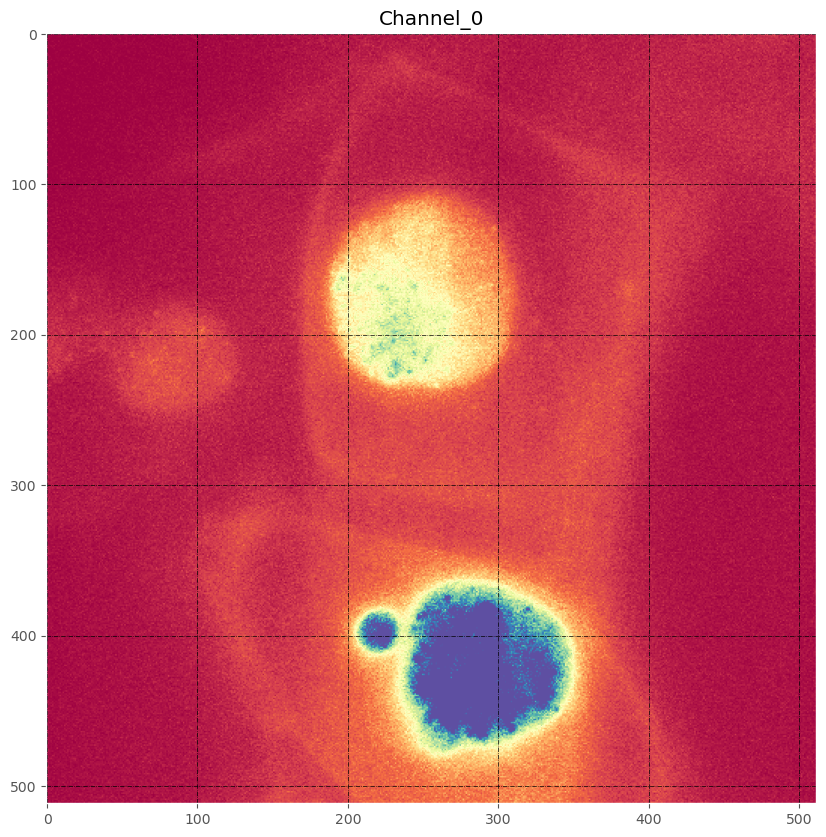

    Orginal Image Shape :                     [11, 512, 512, 1]
    Trimmed z_slices at each border :         2
    Image sharpness metric :                  1.137


INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model C:\Users\Jack\.cellpose\models\cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [0, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=103)
           2	LOAD_GLOBAL(arg=0, lineno=117)
           4	LOAD_METHOD(arg=1, lineno=117)
           6	LOAD_GLOBAL(arg=2, lineno=117)
           8	LOAD_FAST(arg=1, lineno=117)
          10	CALL_FUNCTION(arg=1, lineno=117)
          12	LOAD_CONST(arg=1, lineno=117)
          14	BUILD_TUPLE(arg=2, lineno=117)
          16	LOAD_CONST(arg=2, lineno=117)
          18	CALL_METHOD(arg=2, lineno=117)
          20	STORE_FAST(arg=2, lineno=117)
          22	LOAD_GLOBAL(arg=0, lineno=118)
          24	LOAD_METHO

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=15.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Jack\\miniconda3\\envs\\FISH_env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Jack\\miniconda3\\envs\\FISH_env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Jack\\miniconda3\\envs\\FISH_env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', si

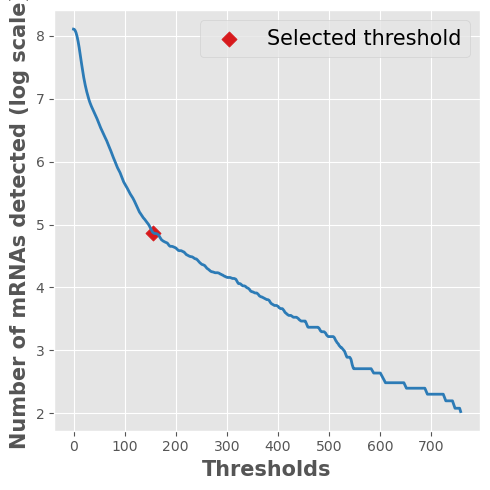

Z-Slice:  3


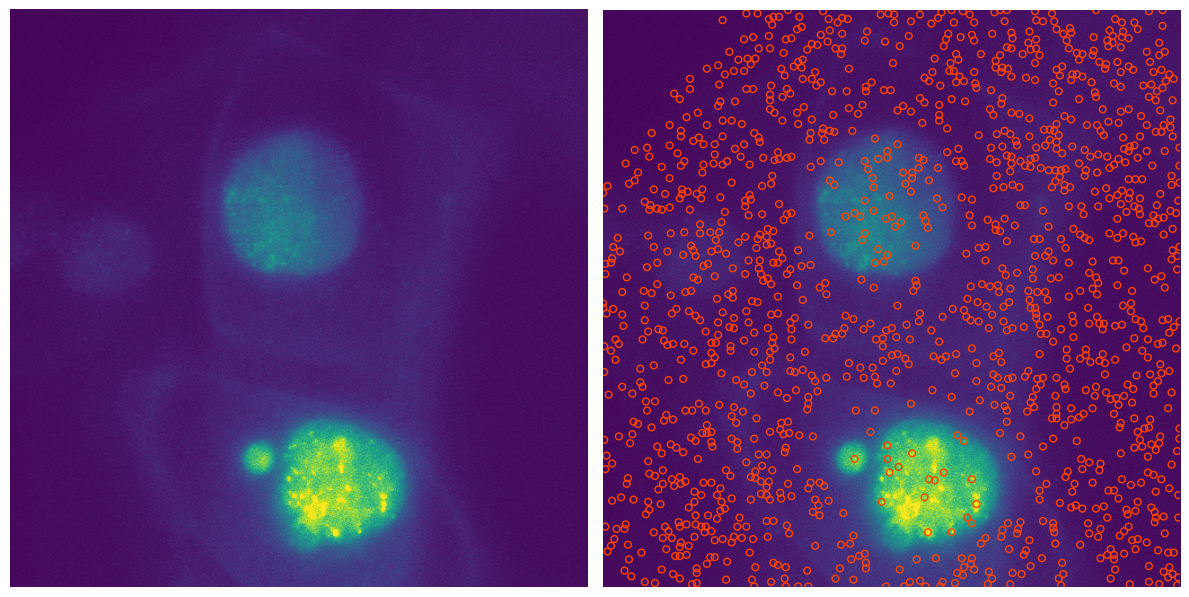

    Intensity threshold for spot detection :  [1089]
    Average detected spots per cell :         [271]
    Maximum detected spots per cell :         [433]


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Jack\\miniconda3\\envs\\FISH_env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Jack\\miniconda3\\envs\\FISH_env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Jack\\miniconda3\\envs\\FISH_env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', 

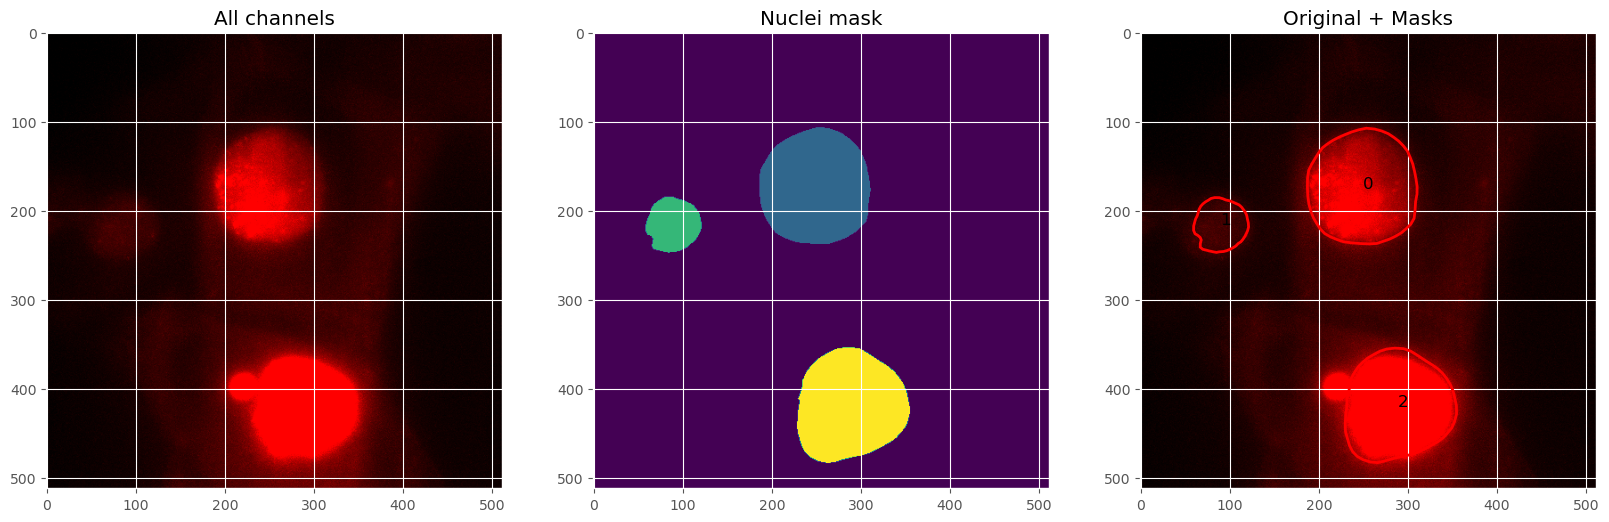

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

 ###################### 
        IMAGE : 1
 ###################### 
    Image Name :   H128_Tiles_100ms_5mW_Blue_15x15_10z_05step_NDTiffStack_tp_0_fov_1.tif


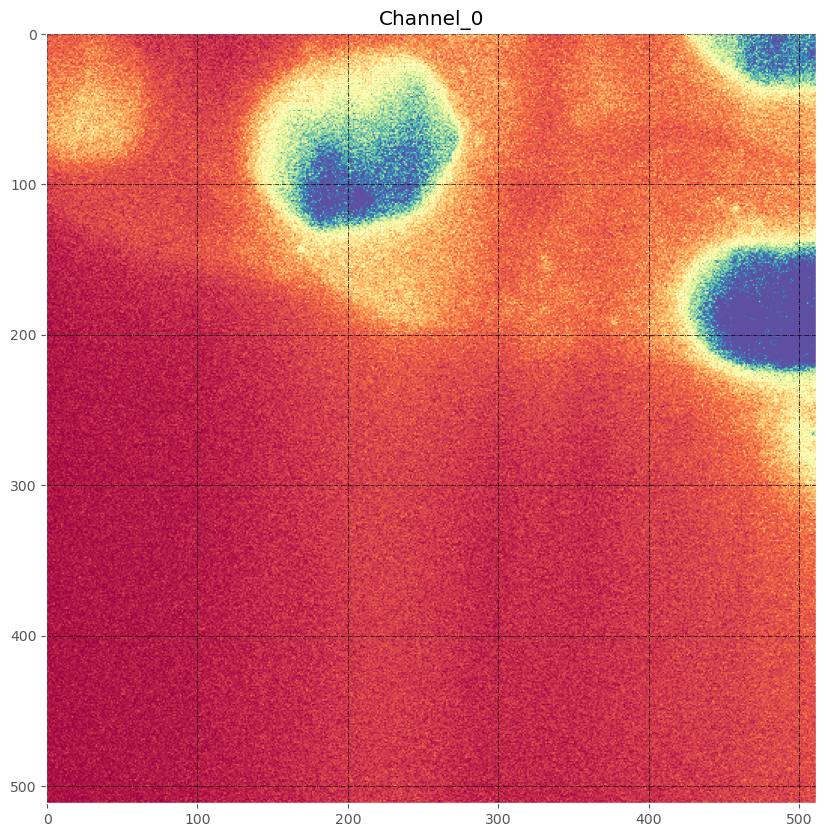

INFO:cellpose.core:** TORCH CUDA version installed and working. **


    Orginal Image Shape :                     [11, 512, 512, 1]
    Trimmed z_slices at each border :         2
    Image sharpness metric :                  1.135


INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model C:\Users\Jack\.cellpose\models\cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [0, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 0.27 sec
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model C:\Users\Jack\.cellpose\models\cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [0, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 0.26 sec
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>> cyto3 << model set

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


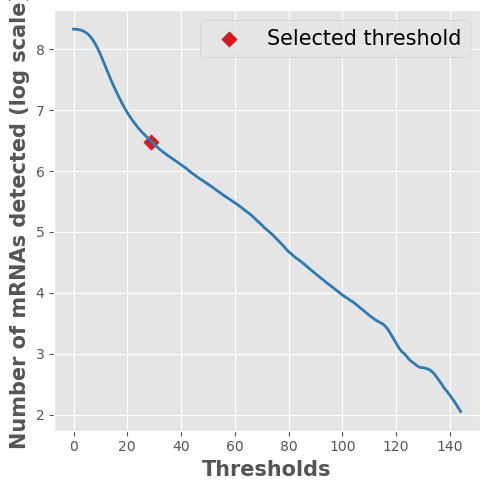

Z-Slice:  3


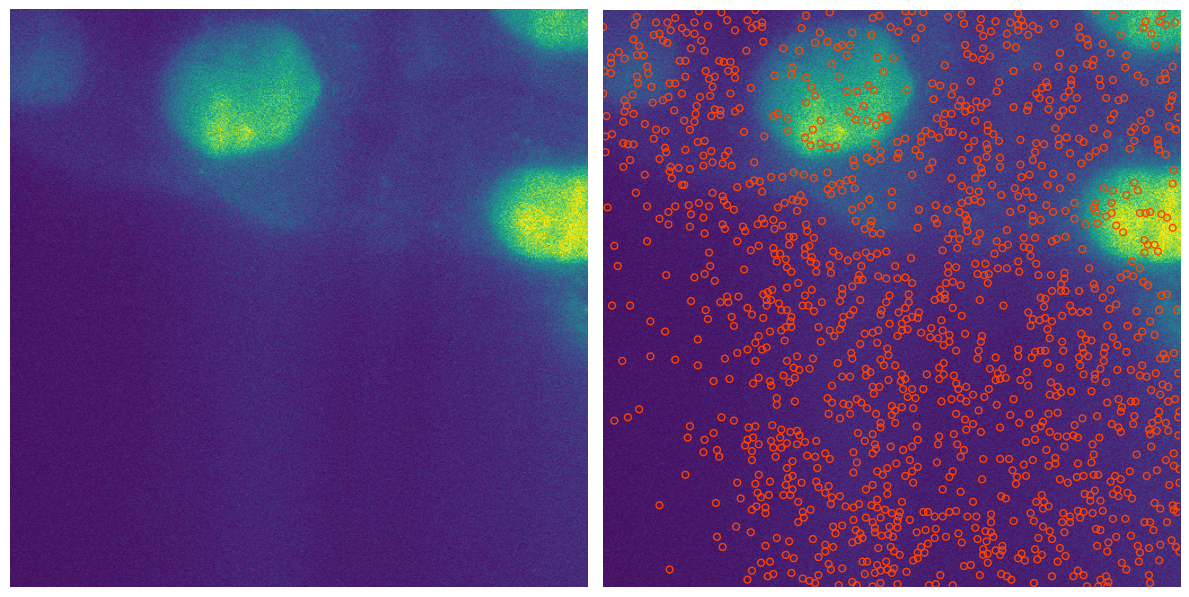

    Intensity threshold for spot detection :  [1089]
    Average detected spots per cell :         [312]
    Maximum detected spots per cell :         [595]


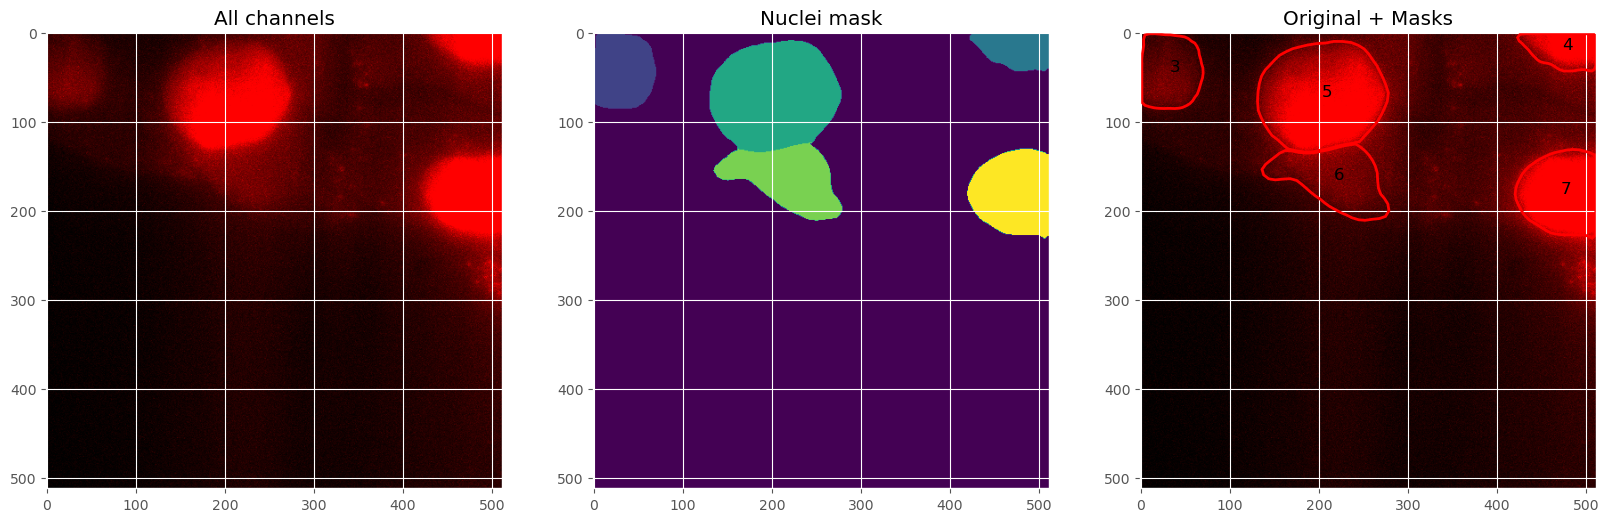

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Jack\\miniconda3\\envs\\FISH_env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Jack\\miniconda3\\envs\\FISH_env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Jack\\miniconda3\\envs\\FISH_env\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', s

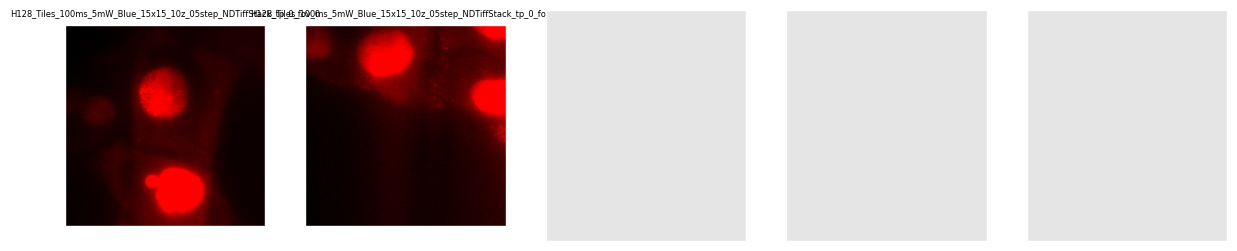

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'tEXt' 41 57
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 110 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 131 65536
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'tEXt' 41 57
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 110 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 131 65536
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'tEXt' 41 57
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 110 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 131 65536
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'tEXt' 41 57
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 110 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 131 65536
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:matplotlib.backends.backend_pdf:Assigning font /F1 = 'C:\\Users\\Jack\\miniconda3\\envs\\FISH_env\\Lib\\site-packages\\matplotli

In [37]:
# Load in data 
# Lets build these objects from the user inputs
pipelineSettings = PipelineSettings(return_data_to_NAS=send_data_to_NAS, 
                                    optimization_segmentation_method=optimization_segmentation_method,
                                    save_all_imgs=save_all_images,
                                    save_all_filtered_imgs=save_filtered_images,
                                    threshold_for_spot_detection=threshold_for_spot_detection,
                                    NUMBER_OF_CORES=4,
                                    NUMBER_Z_SLICES_TO_TRIM=2,
                                    remove_z_slices_borders=True,
                                    MINIMAL_NUMBER_OF_Z_SLICES_TO_CONSIDER_A_3D_IMAGE=5,
                                    User_Select_number_of_Images_to_run=2)

terminatorScope = ScopeClass()

experiment = Experiment(raw_data_dir, voxel_size_z=voxel_size_z)

NativeData = Pycromanager2NativeDataType(experiment, pipelineSettings, terminatorScope, r"C:\Users\Jack\Desktop\config.yml")

experiment.number_of_channels = NativeData.number_color_channels
experiment.number_of_timepoints = NativeData.number_of_timepoints
experiment.number_of_Z = NativeData.number_z_slices
experiment.number_of_FOVs = NativeData.number_of_fov
experiment.number_of_Timepoints = NativeData.number_of_timepoints
experiment.number_of_images_to_process = experiment.number_of_FOVs * experiment.number_of_timepoints
experiment.nucChannel = [0]
experiment.FISHChannel = [0]
experiment.list_initial_z_slices_per_image = NativeData.list_nZ
experiment.list_timepoints = NativeData.list_tps

pipelineData = PipelineDataClass(NativeData.local_data_dir, total_num_imgs=experiment.number_of_images_to_process, list_image_names=NativeData.list_files_names, list_images=NativeData.list_images)


# Create Pipeline 
prePipelineSteps = [ConsolidateImageShapes(),TrimZSlices(), CalculateSharpness(), AutomaticSpotDetection()]
pipelineSteps = [CellSegmentationStepClass(), SpotDetectionStepClass()]
postPipelineSteps = [SavePDFReport()]
pipeline = Pipeline(pipelineSettings, terminatorScope, experiment, pipelineData, prePipelineSteps, postPipelineSteps, pipelineSteps)


# Run pre pipeline steps
pipeline.run_pre_pipeline_steps()

pickle.dump(pipeline.pipelineData, open('pipelineData.pkl', 'wb'))
pipelineData = pickle.load(open('pipelineData.pkl', 'rb'))
pipeline.pipelineData = pipelineData

# Run pipeline steps
pipeline.run_pipeline_steps()


# Run post pipeline steps
pipeline.run_post_pipeline_steps()

